# Baseline IRIS Performance

In [2]:
%load_ext rpy2.ipython

#dependencies installed with:
#install.packages("ggplot2")
#install.packages("latex2exp")
#install.packages("remotes")
#remotes::install_github("zeehio/facetscales")
#conda install -c conda-forge r-magick
#conda install udunits2
#conda install gdal
#install.packages('magick')
#remotes::install_github("coolbutuseless/ggpattern")

### Collecting the Data

The Baseline latency and throughput of issuing different amounts of tasks is collected over our various systems.
The script to do the whole aquisition from `run-throughput-dgemm-on-all-platforms.sh` and `run-latency-klo-on-all-platforms.sh` located in the `apps/sc20` subdirectory.
Run this from the headnode and it will `ssh` into the correct host then run the benchmark applications.
The data is stored as `csv` files in the `apps/sc20/<latency/throughput>-results` subdirectory respectively.

### Loading the Data


In [1]:
import glob
application_files = glob.glob("../benchmarking/latency-results/kernellaunch-*.csv")

import pandas
df = None

for af in application_files:
    names = af.replace(".csv","")
    names = names.replace('../benchmarking/latency-results/',"")
    params = names.split("-")
    params.pop(0)
    num_launches = int(params.pop())
    system = params.pop()
    version = '-'.join([str(x) for x in params])
    builton = None
    if "opencl" in version:
        builton = "OpenCL"
    elif "cuda" in version:
        builton = "CUDA"
    else:
        builton = "HIP"
    runtime = None
    if len(params) == 1:
        runtime = "native"
    elif params[0] == "multigpu":
        runtime = "multigpu"
    else:
        runtime = "iris"
    ndf = pandas.DataFrame({'runtimes':pandas.read_csv(af,header=None,comment='#').values[0].tolist(),'num_launches':num_launches,'version':version,'system':system,'runtime':runtime,'builton':builton})
    if df is None:
        df = ndf
    else:
        df = pandas.merge(df,ndf,how='outer')

print(df)
kernellaunch = df

        runtimes  num_launches            version  system   runtime builton
0        803.232           100          iris-cuda  Zenith      iris    CUDA
1        683.546           100          iris-cuda  Zenith      iris    CUDA
2        723.362           100          iris-cuda  Zenith      iris    CUDA
3        714.540           100          iris-cuda  Zenith      iris    CUDA
4        768.185           100          iris-cuda  Zenith      iris    CUDA
...          ...           ...                ...     ...       ...     ...
143995   437.975            10  multigpu-iris-hip  Radeon  multigpu     HIP
143996   413.895            10  multigpu-iris-hip  Radeon  multigpu     HIP
143997   467.300            10  multigpu-iris-hip  Radeon  multigpu     HIP
143998   497.818            10  multigpu-iris-hip  Radeon  multigpu     HIP
143999   440.598            10  multigpu-iris-hip  Radeon  multigpu     HIP

[144000 rows x 6 columns]


In [2]:
kernellaunch

,runtimes,num_launches,version,system,runtime,builton
0,803.232,100,iris-cuda,Zenith,iris,CUDA
1,683.546,100,iris-cuda,Zenith,iris,CUDA
2,723.362,100,iris-cuda,Zenith,iris,CUDA
3,714.540,100,iris-cuda,Zenith,iris,CUDA
4,768.185,100,iris-cuda,Zenith,iris,CUDA
...,...,...,...,...,...,...
143995,437.975,10,multigpu-iris-hip,Radeon,multigpu,HIP
143996,413.895,10,multigpu-iris-hip,Radeon,multigpu,HIP
143997,467.300,10,multigpu-iris-hip,Radeon,multigpu,HIP
143998,497.818,10,multigpu-iris-hip,Radeon,multigpu,HIP


In [3]:
import glob
application_files = glob.glob("../benchmarking/compute-performance-results/dgemm-*.csv")

import pandas
df = None

for af in application_files:
    names = af.replace(".csv","")
    names = names.replace('../benchmarking/compute-performance-results/',"")
    params = names.split("-")
    params.pop(0)
    num_devices = params.pop()
    system = params.pop()
    version = '-'.join([str(x) for x in params])
    runtime = None
    if len(params) == 1:
        runtime = "native"
    elif params[0] == "multigpu":
        runtime = "multigpu"
    else:
        runtime = "iris"
    ops = pandas.read_csv(af,header=None,comment='#')[0].tolist()
    iops = pandas.read_csv(af,header=None,comment='#')[1].tolist()
    flops = pandas.read_csv(af,header=None,comment='#')[2].tolist()

    ndf = pandas.DataFrame({'OPs':ops,'IOPs':iops,'FLOPs':flops,'version':version,'system':system,'runtime':runtime,'num_devices':num_devices})
    if df is None:
        df = ndf
    else:
        df = pandas.merge(df,ndf,how='outer')

print(df)
throughput = df

            OPs        IOPs       FLOPs      version    system runtime  \
0    250.991605  167.327736   83.663868    iris-cuda   Leconte    iris   
1    251.048968  167.365979   83.682989    iris-cuda   Leconte    iris   
2    345.225196  230.150130  115.075065    iris-cuda   Leconte    iris   
3    345.858605  230.572403  115.286202    iris-cuda   Leconte    iris   
4    859.559985  573.039990  286.519995  iris-opencl  Explorer    iris   
..          ...         ...         ...          ...       ...     ...   
242   35.360374   23.573583   11.786791    iris-cuda    Oswald    iris   
243   35.365833   23.577222   11.788611    iris-cuda    Oswald    iris   
244  305.128144  203.418763  101.709381  iris-opencl    Oswald    iris   
245  296.789348  197.859565   98.929783  iris-opencl    Oswald    iris   
246  562.119994  374.746663  187.373331  iris-opencl    Radeon    iris   

    num_devices  
0            13  
1            13  
2             6  
3             6  
4             3  
.. 

In [6]:
import glob
application_files = glob.glob("../benchmarking/memory-results/*.csv")

#discard the csv files where are the timeline of task and device it was run, instead we only consider the aggregate summation time logs.
application_files =  [i for i in application_files if i.count('-') == 7]

import pandas
df = None

for af in application_files:
    names = af.replace(".csv","")
    names = names.replace('../benchmarking/memory-results/',"")
    params = names.split("-")
    params.pop(0)
    length = params.pop()
    size = params.pop()
    system = params.pop()
    version = params.pop()
    with open(af, encoding="utf-8") as file:
        content = [l.rstrip("\n") for l in file]
    times = content[0].split(',')
    times = [float(ele) for ele in times]
    ndf = pandas.DataFrame({'ms':times,'system':system,'version':version,'chain_length':length,'size':size})
    if df is None:
        df = ndf
    else:
        df = pandas.merge(df,ndf,how='outer')

print(df)
number_of_transfers = df

             ms   system version chain_length  size
0     84.070700  Leconte    cuda         1000  1024
1    109.207000  Leconte    cuda         1000  1024
2     99.494500  Leconte    cuda         1000  1024
3      0.629187  Leconte    cuda            1  1024
4      1.033070  Leconte    cuda            1  1024
..          ...      ...     ...          ...   ...
231    2.783060  Leconte    cuda           10  1024
232    1.683950  Leconte    cuda           10  1024
233    3.776550  Leconte    cuda           10  1024
234    1.636510  Leconte    cuda           10  1024
235    1.625060  Leconte    cuda           10  1024

[236 rows x 5 columns]


In [7]:
import glob
application_files = glob.glob("../membench/transfer-size-results/*.csv")

#discard the csv files where are the timeline of task and device it was run, instead we only consider the aggregate summation time logs.
application_files =  [i for i in application_files if i.count('-') == 6]

import pandas
df = None

for af in application_files:
    names = af.replace(".csv","")
    names = names.replace('../membench/transfer-size-results/',"")
    params = names.split("-")
    params.pop(0)
    length = params.pop()
    KiB = params.pop()
    system = params.pop()
    version = params.pop()
    with open(af, encoding="utf-8") as file:
        content = [l.rstrip("\n") for l in file]
    times = content[0].split(',')
    times = [float(ele) for ele in times]
    ndf = pandas.DataFrame({'ms':times,'system':system,'version':version,'chain_length':length,'KiB':KiB})
    if df is None:
        df = ndf
    else:
        df = pandas.merge(df,ndf,how='outer')

print(df)
transfer_size = df

            ms   system version chain_length     KiB
0     17.64230  Leconte    cuda           10  256KiB
1      4.32968  Leconte    cuda           10  256KiB
2      5.23782  Leconte    cuda           10  256KiB
3      2.45786  Leconte    cuda           10  256KiB
4      5.62000  Leconte    cuda           10  256KiB
...        ...      ...     ...          ...     ...
1095   1.72305  Leconte    cuda           10    8KiB
1096   1.71638  Leconte    cuda           10    8KiB
1097   1.70493  Leconte    cuda           10    8KiB
1098   1.71804  Leconte    cuda           10    8KiB
1099   1.73712  Leconte    cuda           10    8KiB

[1100 rows x 5 columns]


# Latency

The variance in latency is significantly higher on CUDA runtimes (both natively and through IRIS) and only matches the latency of OpenCL and HIP based runtimes when amortized over > 100 concurrent kernel launches. It is interesting that there is such large variability for small/few kernel runs just using the CUDA runtime, whereas the same devices with the OpenCL runtime have a more consistant performance---with a smaller spread of times. The following is a comparison broken down per system to verify this observation.

Let's present this data as a barchart rather than a box-and-whisker plot.

And on a landscape layout with ordering of the systems

In general, we see a higher variability in performance when adding IRIS to greater number of kernel launches regardless of backend/runtime used, particularly for ~1000 kernel launches. This could identify an area of improvement for IRIS---scalability on larger workloads which require many kernel tasks to complete.

When considering just the median task latency on each system, we see that native performance is better than when IRIS is added, however once we use IRIS the multigpu version generally performs almost as well as native runtimes. Of course, the abstraction that IRIS offers and once smart scheduling stategies can be employed we postulate that this will amortize the added per task latency in execution---which is the only downside to using IRIS.

It is consistant that more tasks to process will take longer to complete and we generally see this on all systems and all versions.
OpenCL performs as well as the CUDA and HIP versions and is comparable over the increasing number of kernel launches.

The systems have been arranged from fewest devices to most devices per row; the Nvidia systems on the top, and AMD GPUs on the bottom.

| System | GPU Vendor | GPU Series | # of GPUs | Runtimes |
| :-     | :-         | :-  | :-       | :-:      |
| Oswald00 | Nvidia | P100 | 1 | CUDA |
|  | |  |  | OpenCL |
| Equinox | Nvidia | V100 | 4 | CUDA |
|  | |  |  | OpenCL |
| Leconte | Nvidia | V100 | 6 | CUDA |
| Radeon | AMD | Vega20 | 1 | HIP |
|  | |  |  | OpenCL |
| Explorer | AMD | M160 | 2 | HIP |
|  | |  |  | OpenCL |

So we can compare the latency involved in executing tasks over an increasing number of devices; 1->3->6 Nvidia GPUs on the top, and 1->2 AMD GPUs on the bottom.

Comparing the scaling of Oswald (1xP100) to Equinox (3xV100) we see no significant difference in scaling dispite being a different generation of GPU, and is irrespective of whether CUDA or OpenCL is used in the backend.

The Explorer (6xV100) **TODO**: Investigate why this system is orders of magnitude worse than the other systems.

Without the Leconte results a closer comparison can be made.


R[write to console]: Loading required namespace: memoise

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




`summarise()` has grouped output by 'num_launches', 'system', 'version', 'runtime'. You can override using the `.groups` argument.


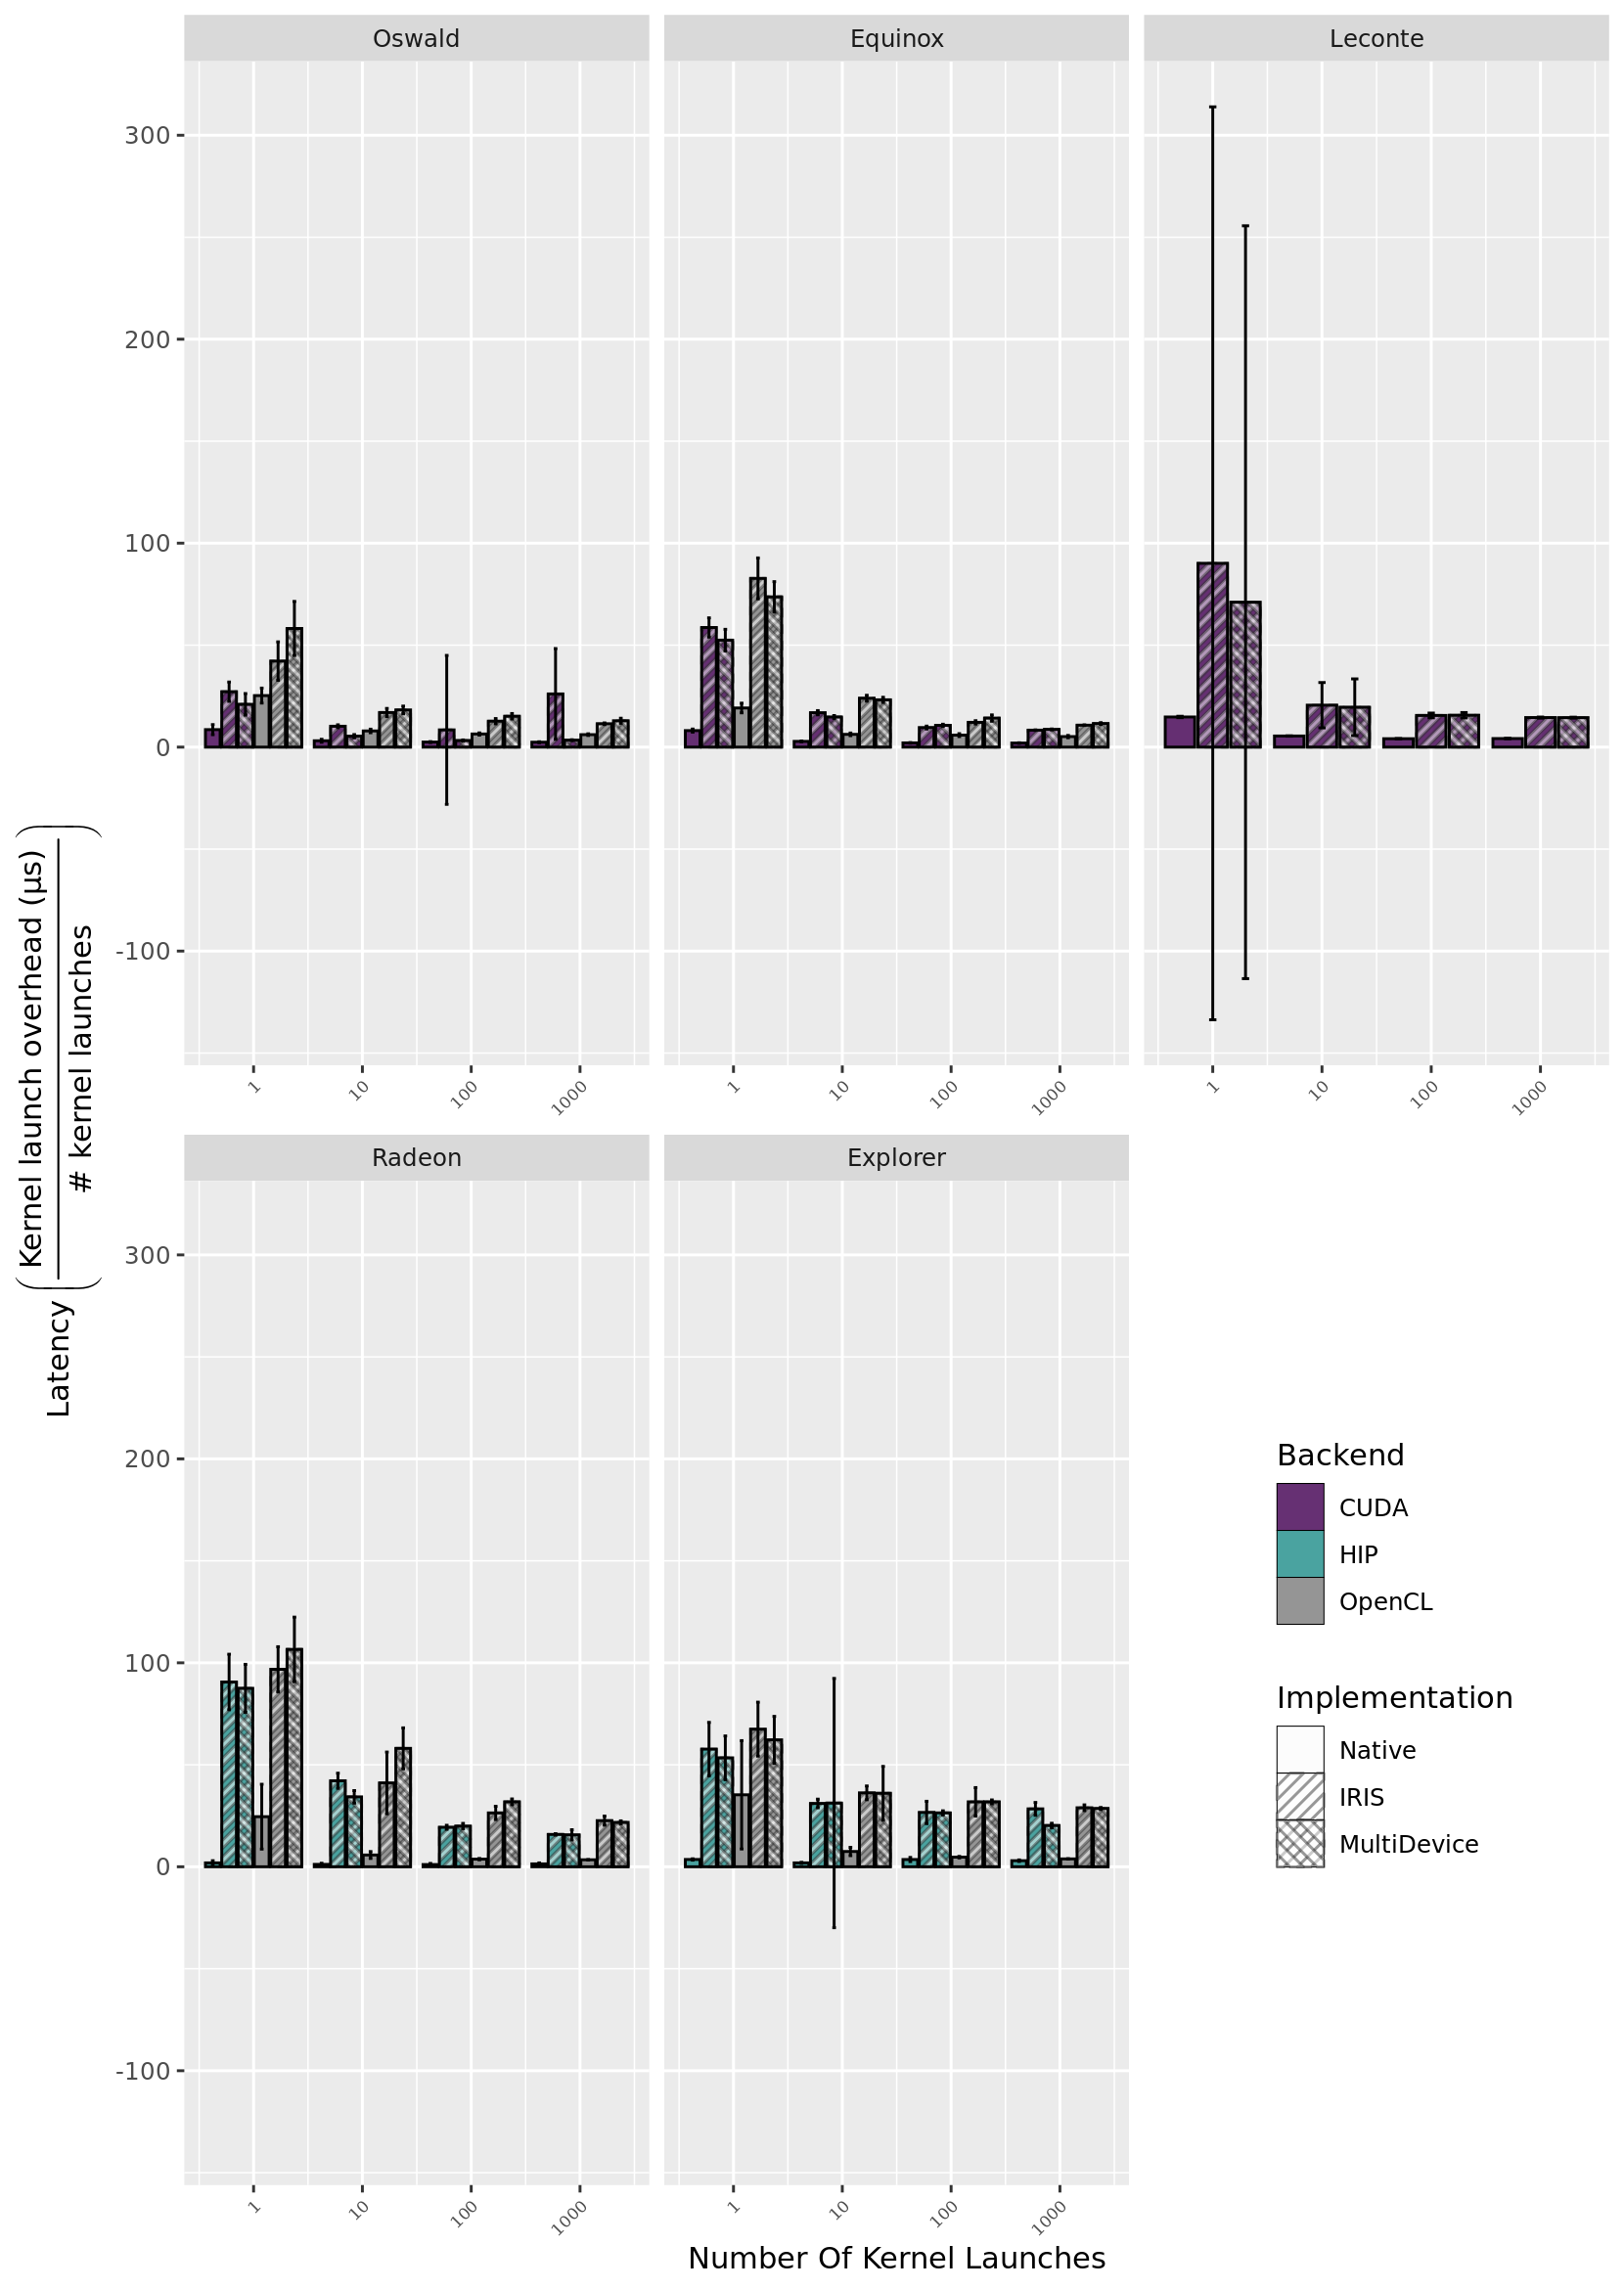

In [8]:
%%R -i kernellaunch -w 8.3 -h 11.7 --units in -r 200

outlier_size = 0.5

library('ggplot2')
library('latex2exp')
library('scales')
library('ggsci')
library("ggpattern")
library("dplyr")

desat <- function(cols, sat=0.5) {
    X <- diag(c(1, sat, 1)) %*% rgb2hsv(col2rgb(cols))
    hsv(X[1,], X[2,], X[3,])
}

#Create a custom color scale
#library(RColorBrewer)
#myColors <- pal_npg("nrc")(8)
myColors <- viridis_pal()(3)

myColors <- c(myColors[1], myColors[2], myColors[6]) 
#myColors <- c(rep(myColors[1],3),rep(myColors[2],3),rep(myColors[3],3))#copy each of the colours 3x

#change the saturation of the iris and multigpu runtimes
#for(i in seq(2,length(myColors),3)){
#    myColors[i] <- desat(myColors[i],0.6)
#}
#for(i in seq(3,length(myColors),3)){
#    myColors[i] <- desat(myColors[i],0.25)
#}

colScale <- scale_colour_manual(name = "Backend",values = myColors)
colFill <- scale_fill_manual(name="Backend",values=myColors)
kernellaunch$Backend <- kernellaunch$builton

#reorder according to base implementation.
kernellaunch$version <- factor(kernellaunch$version, levels = c("cuda", "iris-cuda", "multigpu-iris-cuda", "hip", "iris-hip", "multigpu-iris-hip", "opencl", "iris-opencl", "multigpu-iris-opencl"))
names(myColors) <- levels(kernellaunch$Backend)

#reorder systems
kernellaunch$system <- factor(kernellaunch$system, levels = c("Oswald", "Equinox", "Leconte", "Radeon", "Explorer"))

#rename and reorder implementations
#kernellaunch$runtime <- rename(kernellaunch$runtime, c("native" = "Native","iris" = "IRIS","multigpu" = "Multi-Device"))
kernellaunch$runtime <- recode(kernellaunch$runtime, native = "Native", iris = "IRIS", multigpu = "MultiDevice")
kernellaunch$runtime <- factor(kernellaunch$runtime,levels = c("Native","IRIS","MultiDevice"))
#drop Leconte
#kernellaunch %>% filter(system != "Leconte") %>% {. ->> kernellaunch}

#latency is the total duration times / the number of kernels invoked
kernellaunch$latency <- kernellaunch$runtimes / kernellaunch$num_launches

library(dplyr)

kernellaunch%>%
group_by(num_launches,system,  version, runtime, Backend)%>% 
summarise(Mean=mean(latency), Max=max(latency), Min=min(latency), Median=median(latency), Std=sd(latency)) %>%
{. ->> kl_sum }

#p1 <- ggplot(kl_sum, aes(x=num_launches, y=Median, fill=version, group=interaction(num_launches,version))) + theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 6)) + expand_limits(y = 0) + labs(colour = "Version", fill="Version", y=TeX("Latency $\\left( \\frac{$ Kernel launch overhead ($\\mu$s) $}{$ # kernel launches $} \\right)$")) + geom_bar(stat='identity',position="dodge2",alpha=0.5) + scale_x_log10("Number Of Kernel Launches", breaks = trans_breaks("log10", function(x) 10^x)) + expand_limits(y = 0) + facet_wrap( ~ system, strip.position = "top", scales = "free_x")
p1 <- ggplot(kl_sum, aes(x=num_launches, y=Median, fill=Backend, pattern=runtime, group=interaction(num_launches,version))) + theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 6)) + expand_limits(y = 0) + scale_x_log10("Number Of Kernel Launches", breaks = trans_breaks("log10", function(x) 10^x)) + expand_limits(y = 0) + facet_wrap( ~ system, strip.position = "top", scales = "free_x")
p1 <- p1 + geom_bar_pattern(stat='identity',position="dodge2",alpha=0.8, pattern_alpha=0.5, color = "black", pattern_fill = "white", pattern_angle = 45, pattern_density = 0.5, pattern_spacing = 0.025, pattern_key_scale_factor = 0.75) 
p1 <- p1 + scale_pattern_manual(values = c(Native = "none", IRIS = "stripe", MultiDevice = "crosshatch"))
p0 <- p1 + geom_errorbar(aes(ymin=Median-Std, ymax=Median+Std), width=.2, position=position_dodge(.9)) + colFill + colScale
p0 <- p0 + guides(fill   = guide_legend(override.aes = list(pattern = "none")))
p0 <- p0 + guides(pattern= guide_legend(override.aes = list(fill = "white")))
p0 <- p0 + labs(fill="Backend", pattern="Implementation", y=TeX("Latency $\\left( \\frac{$ Kernel launch overhead ($\\mu$s) $}{$ # kernel launches $} \\right)$"))
p0 <- p0 + theme(legend.position = c(0.85, 0.25))
print(p0)

ggsave(filename="latency.pdf",path="./iris-and-dagger-paper/figures",width=8.3,height=11.7,units="in",dpi="retina")


# Throughput

## CUDA and HIP

    Equinox    Explorer     Leconte      Oswald      Radeon 
"#0D0887FF" "#7E03A8FF" "#CC4678FF" "#F89441FF" "#F0F921FF" 
`summarise()` has grouped output by 'System', 'version'. You can override using the `.groups` argument.


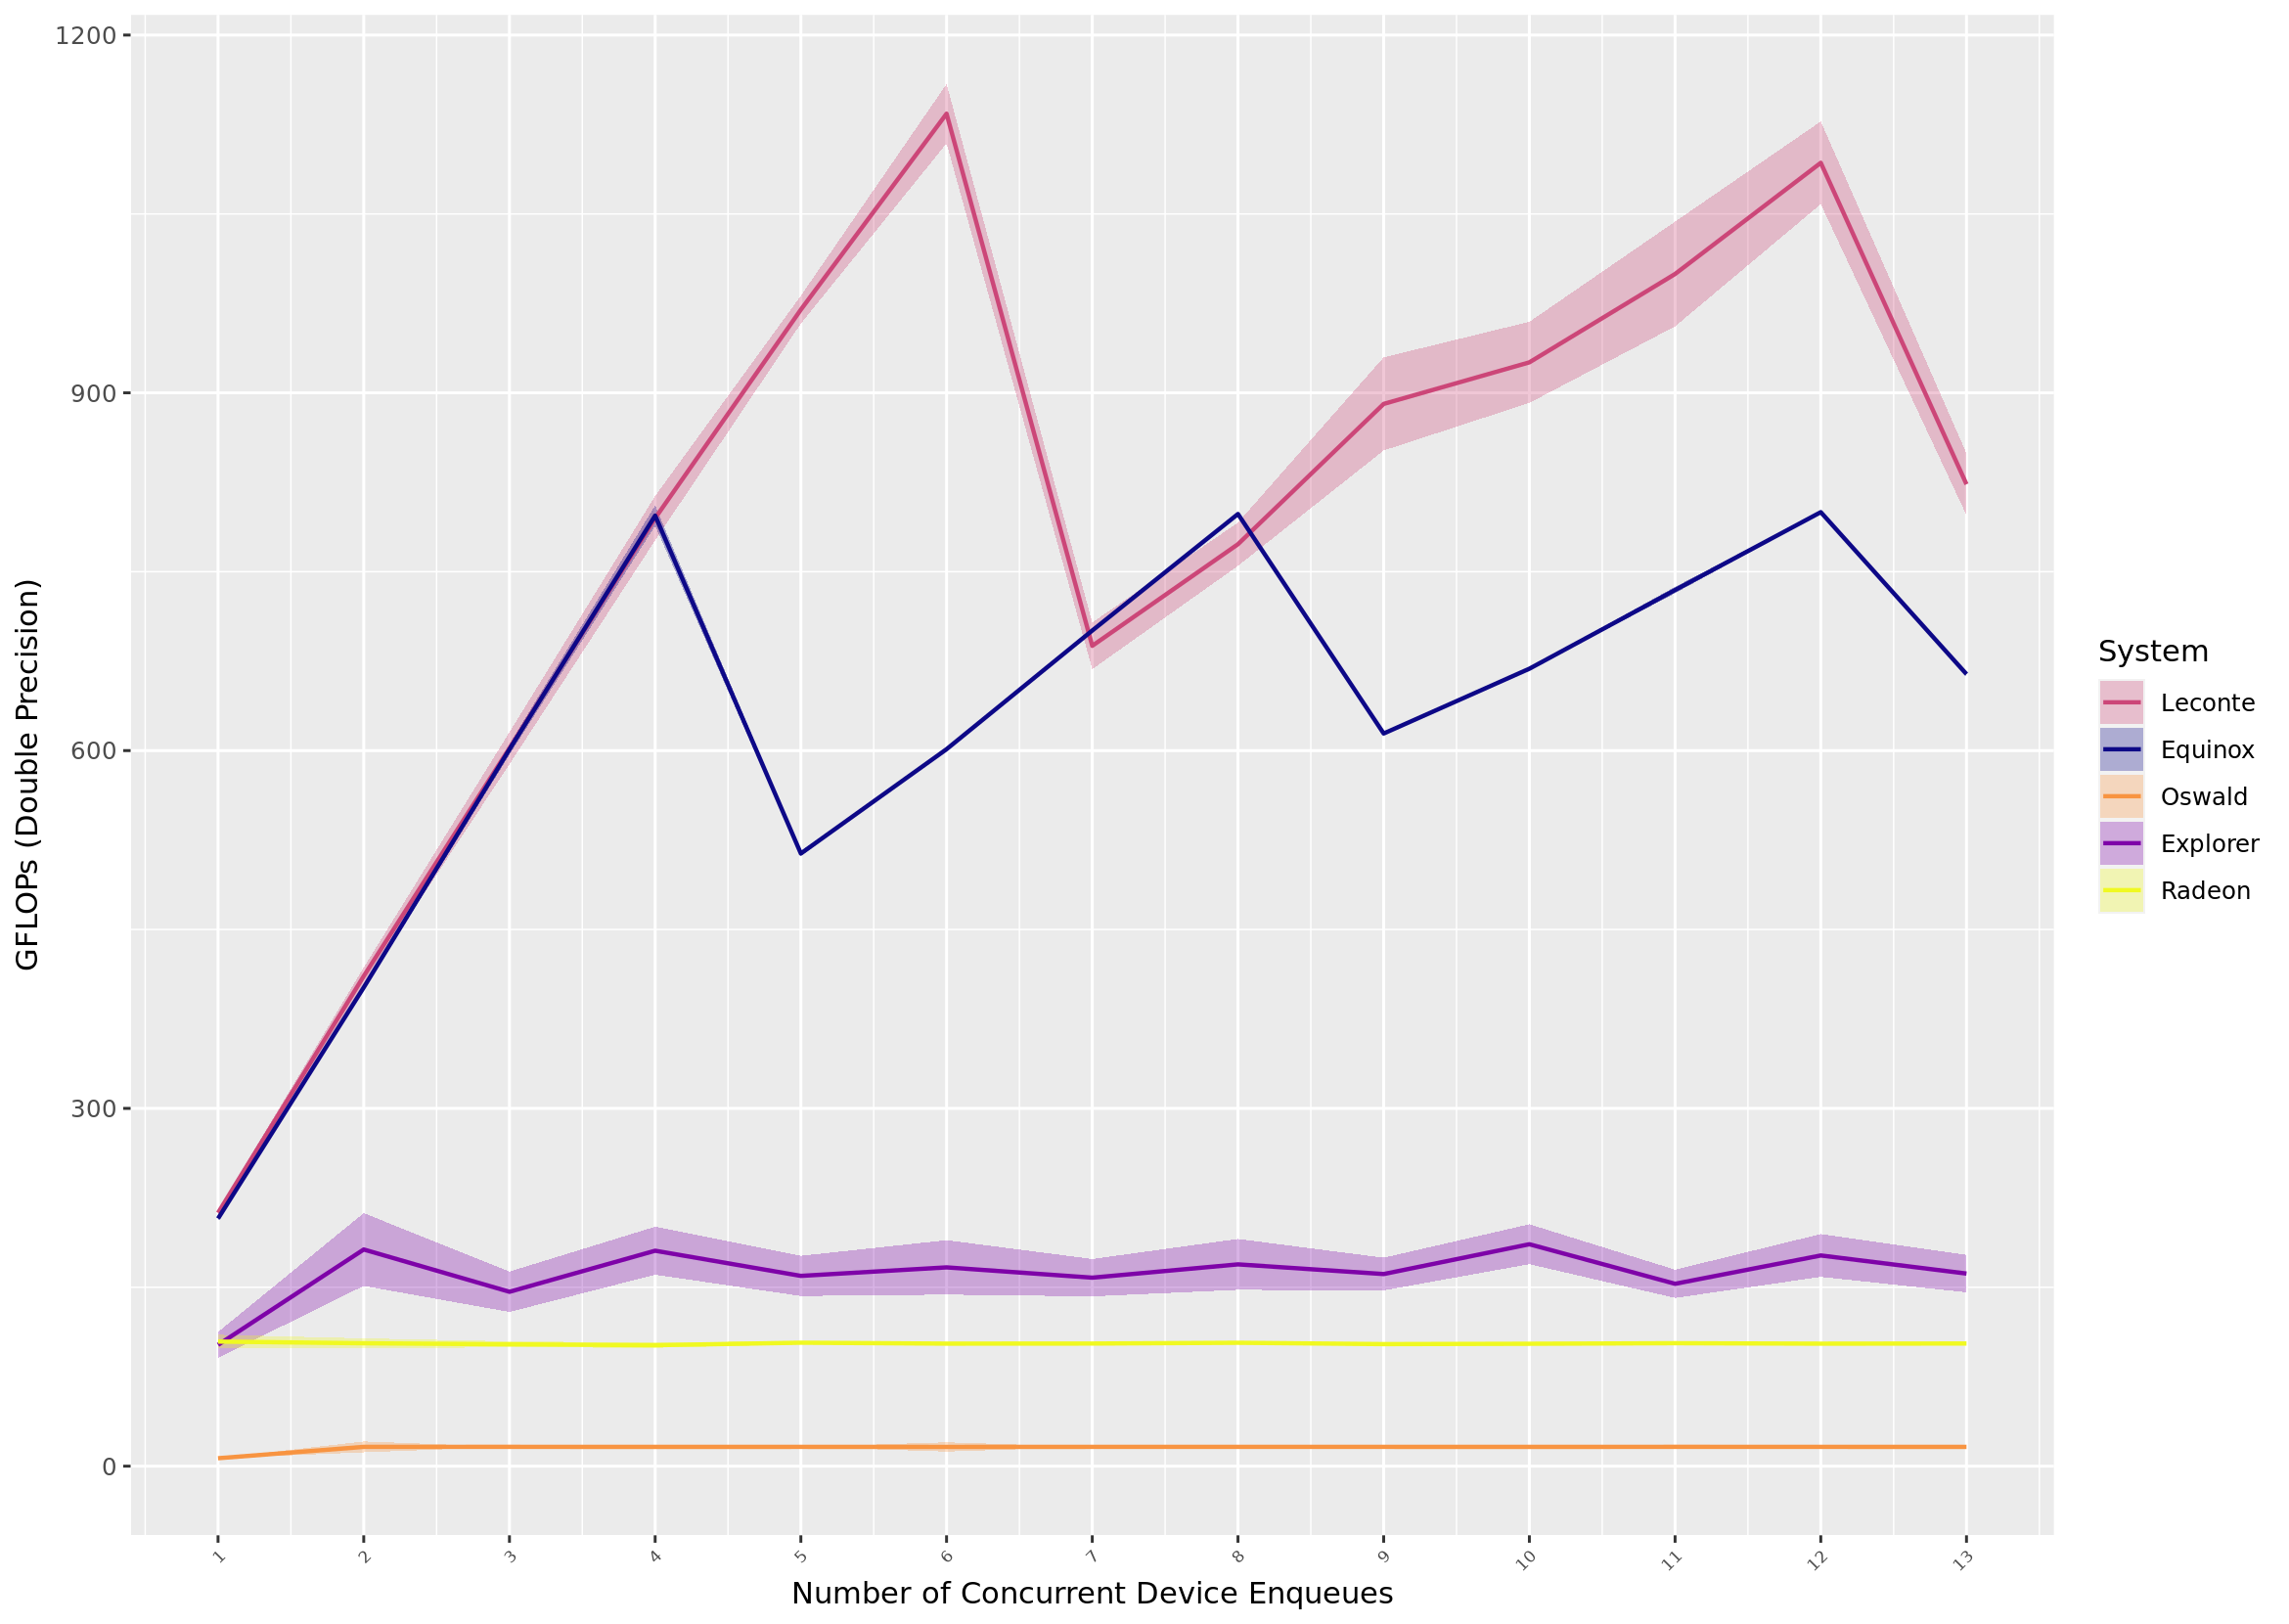

In [9]:
%%R -i throughput -h 8.3 -w 11.7 --units in -r 200

outlier_size = 0.5

library('ggplot2')
library('latex2exp')
library('scales')
library('ggsci')
library("ggpattern")
library("dplyr")
library("RColorBrewer")

desat <- function(cols, sat=0.5) {
    X <- diag(c(1, sat, 1)) %*% rgb2hsv(col2rgb(cols))
    hsv(X[1,], X[2,], X[3,])
}

#reorder systems
throughput$System <- throughput$system
throughput$System <- factor(throughput$System, levels = c("Leconte","Equinox","Oswald", "Explorer","Radeon"))

#Create a custom color scale
#myColors <- brewer.pal(n = 5, name = "Dark2")
myColors <- viridis_pal(option = "plasma")(5)
names(myColors) <- levels(factor(levels(throughput$System)))
print(myColors)
colScale <- scale_colour_manual(name="System",values=myColors)
colFill <- scale_fill_manual(name="System",values=myColors)

#reorder according to base implementation.
throughput$version <- recode(throughput$version, "iris-cuda" = "CUDA", "iris-hip" = "HIP", "iris-opencl" = "OpenCL")
throughput$version <- factor(throughput$version, levels = c("CUDA","HIP","OpenCL"))

throughput$num_devices <- as.integer(throughput$num_devices)

#drop OpenCL
throughput %>% filter(version != "OpenCL") %>% {. ->> throughput}

library(dplyr)

throughput%>%
group_by(System,  version, num_devices)%>% 
summarise(Mean=mean(FLOPs), Max=max(FLOPs), Min=min(FLOPs), Median=median(FLOPs), Std=sd(FLOPs)) %>%
{. ->> tp_sum }

p0 <- ggplot(tp_sum, aes(x=num_devices, y=Median, group=interaction(System,version), colour=System, fill=System)) + theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 6)) + expand_limits(y = 0) + labs(colour = "Version", fill="System", x="Number of Concurrent Device Enqueues", y=TeX("GFLOPs (Double Precision)"))
p0 <- p0 + geom_ribbon(aes(ymin = Median-Std, ymax = Median+Std),alpha=0.3, linetype = 0) + geom_line(aes(y = Median), alpha=1.0, size=0.75)
p0 <- p0 + colFill + colScale + scale_x_continuous(breaks=min(tp_sum$num_devices):max(tp_sum$num_devices))

print(p0)

ggsave(filename="throughput-native.pdf",path="./iris-and-dagger-paper/figures",height=8.3,width=11.7,units="in",dpi="retina")

#with patterns
#p1 <- ggplot(tp_sum, aes(x=num_devices, y=Median, group=interaction(System,version), colour=System)) + theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 6)) + expand_limits(y = 0) + labs(colour = "Version", fill="System", x="Number of Concurrent Device Enqueues", y=TeX("GFLOPs (Double Precision)"))
#p1 <- p1 + geom_ribbon_pattern(aes(ymin = Median-Std, ymax = Median+Std, colour=System, fill=System, pattern=version),alpha=0.25, pattern_alpha=0.5, color = "black", pattern_fill = "white", pattern_angle = 45, pattern_density = 0.5, pattern_spacing = 0.025, pattern_key_scale_factor = 0.75) + geom_path(aes(y = Median), alpha=1.0)
#p1 <- p1 + scale_pattern_manual(values = c(CUDA = "none", HIP = "stripe", OpenCL = "crosshatch"))
#p1 <- p1 + colFill + colScale
#p1 <- p1 + guides(fill   = guide_legend(override.aes = list(pattern = "none")))
#p1 <- p1 + guides(pattern= guide_legend(override.aes = list(fill = "white")))
#p0 <- p1 + geom_errorbar(aes(ymin=Median-Std, ymax=Median+Std), width=.2, position=position_dodge(.9)) + colFill + colScale
#p0 <- p0 + theme(legend.position = c(0.85, 0.25))
#print(p1)


## OpenCL

    Equinox    Explorer     Leconte      Oswald      Radeon 
"#0D0887FF" "#7E03A8FF" "#CC4678FF" "#F89441FF" "#F0F921FF" 
`summarise()` has grouped output by 'System', 'version'. You can override using the `.groups` argument.


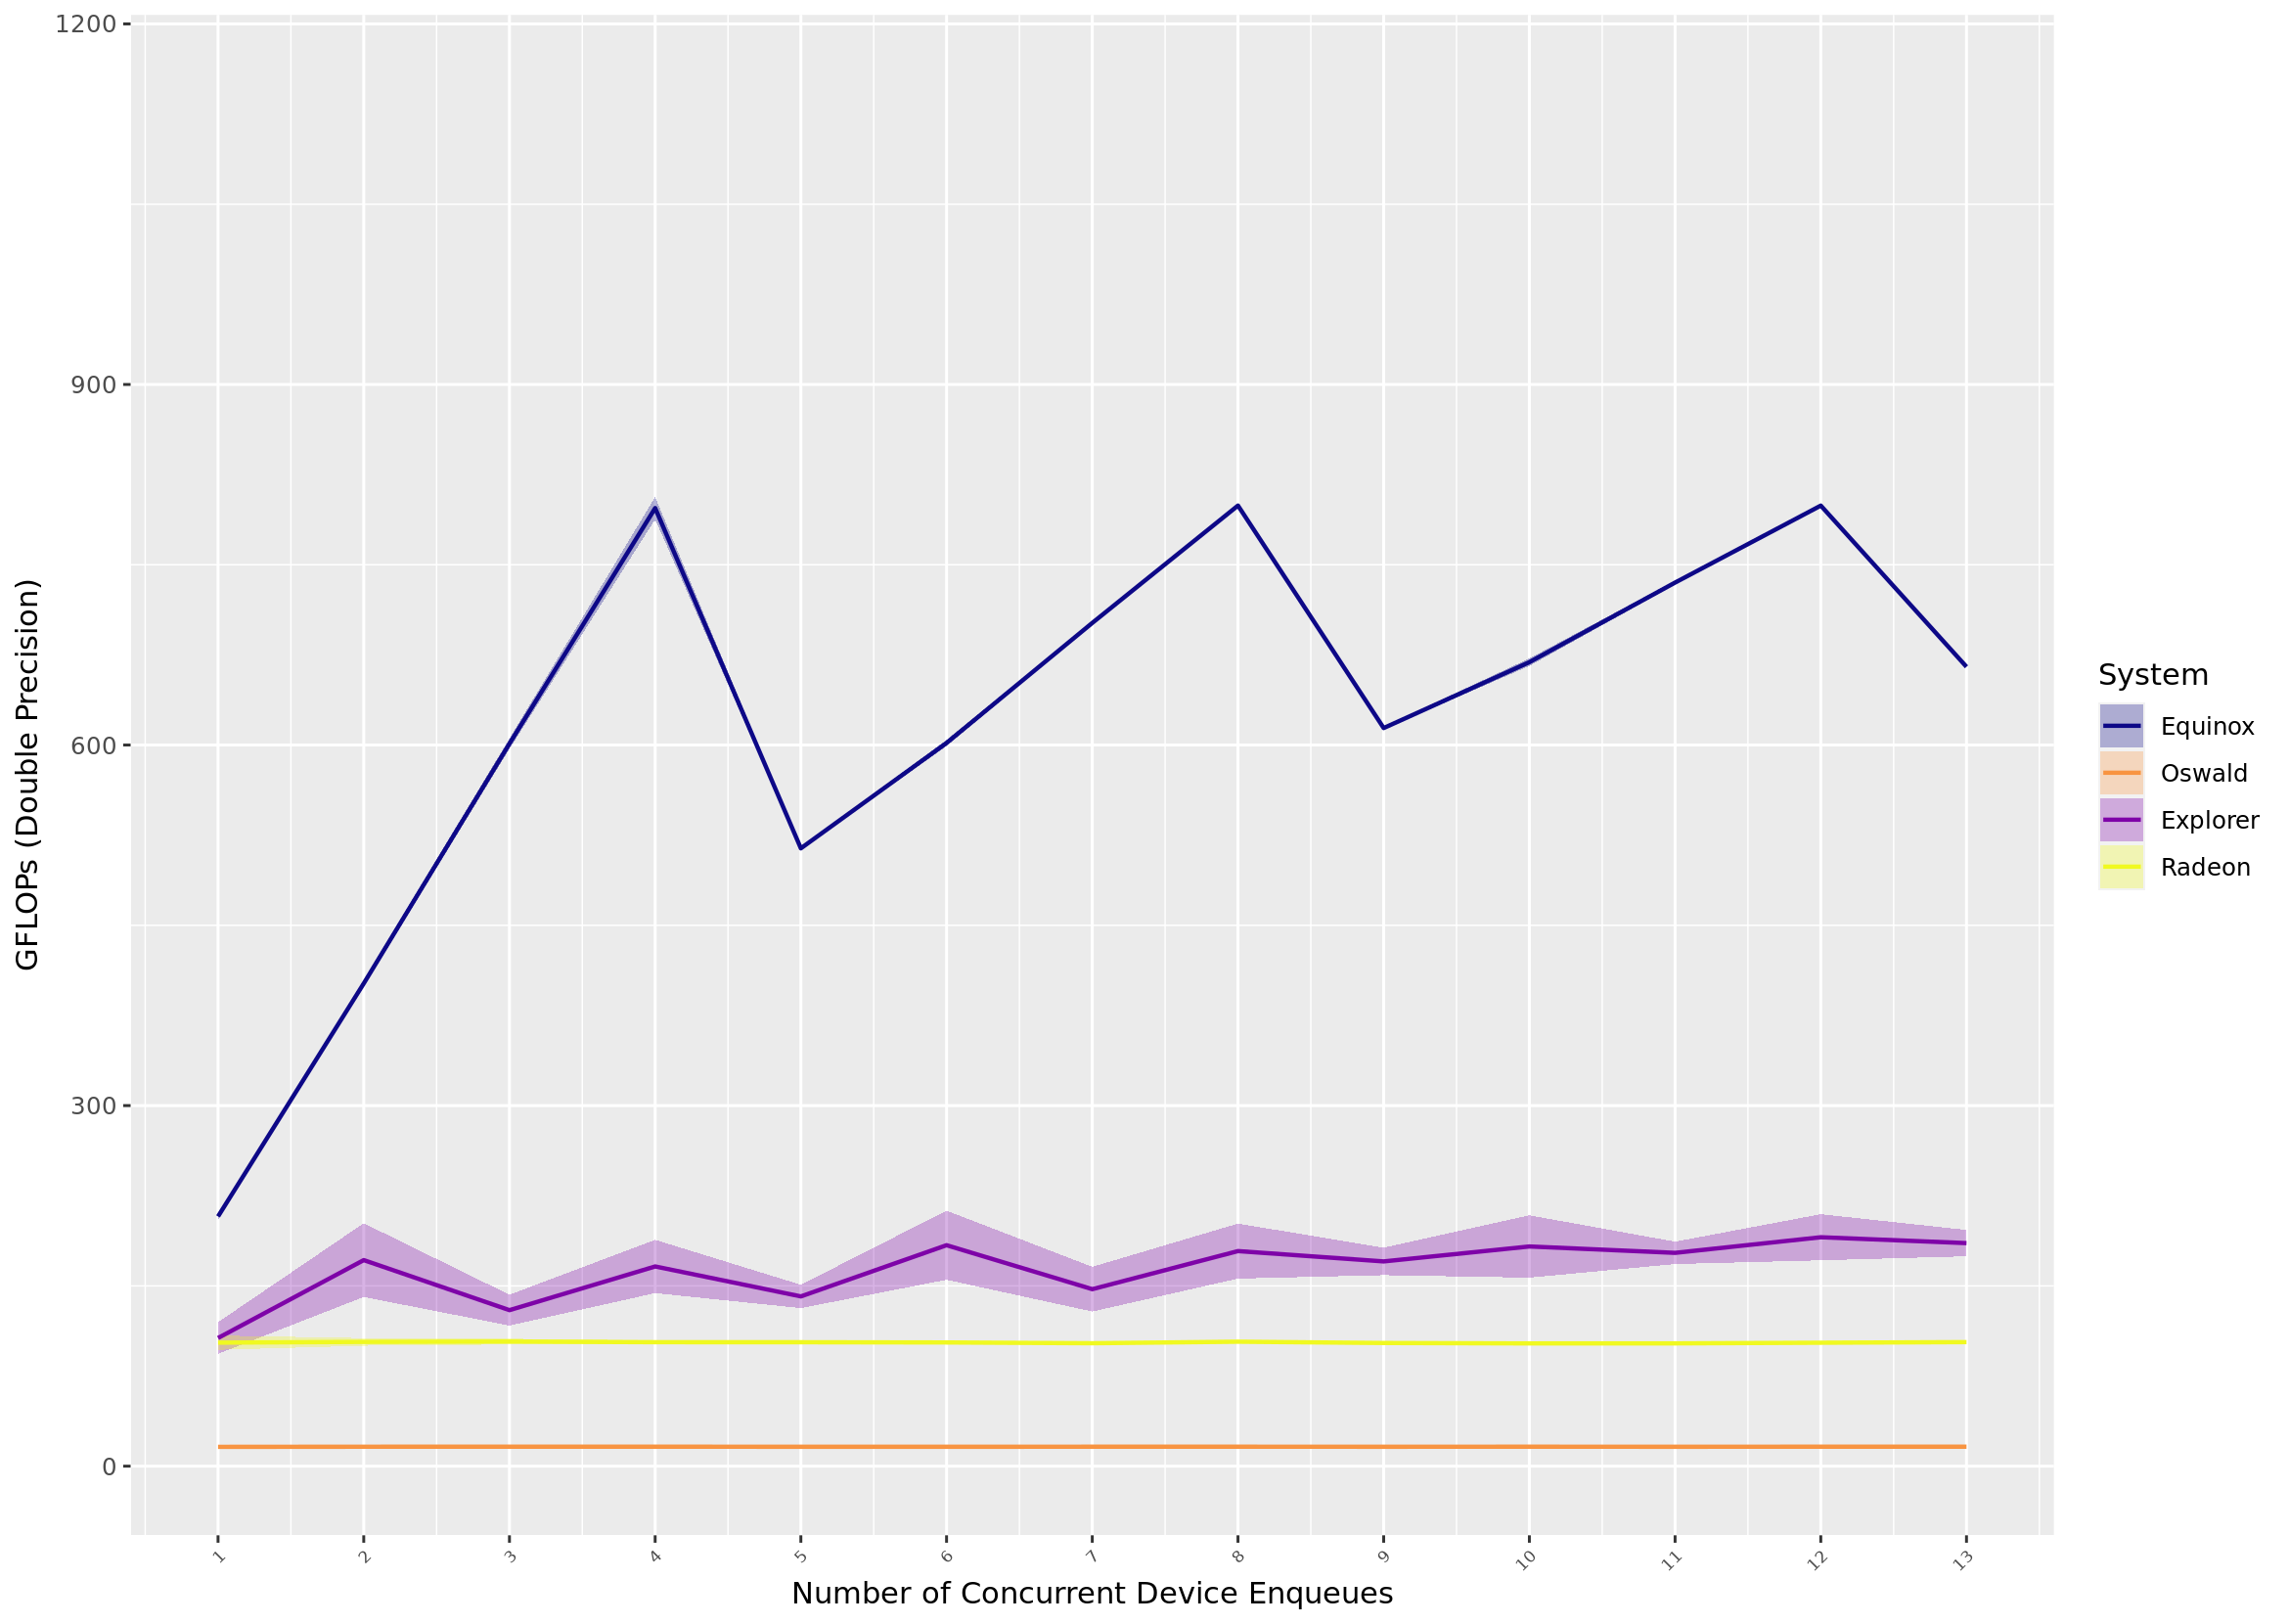

In [10]:
%%R -i throughput -h 8.3 -w 11.7 --units in -r 200

outlier_size = 0.5

library('ggplot2')
library('latex2exp')
library('scales')
library('ggsci')
library("ggpattern")
library("dplyr")

desat <- function(cols, sat=0.5) {
    X <- diag(c(1, sat, 1)) %*% rgb2hsv(col2rgb(cols))
    hsv(X[1,], X[2,], X[3,])
}

#reorder systems
throughput$System <- throughput$system
throughput$System <- factor(throughput$System, levels = c("Leconte","Equinox","Oswald", "Explorer","Radeon"))

#myColors <- brewer.pal(n = 5, name = "Dark2")
myColors <- viridis_pal(option="plasma")(5)
names(myColors) <- levels(factor(levels(throughput$System)))
print(myColors)
colScale <- scale_colour_manual(name = "System",values=myColors)
colFill <- scale_fill_manual(name="System",values=myColors)

#reorder according to base implementation.
throughput$version <- recode(throughput$version, "iris-cuda" = "CUDA", "iris-hip" = "HIP", "iris-opencl" = "OpenCL")
throughput$version <- factor(throughput$version, levels = c("CUDA","HIP","OpenCL"))

throughput$num_devices <- as.integer(throughput$num_devices)

#drop CUDA and HIP
throughput %>% filter(version == "OpenCL") %>% {. ->> throughput}

library(dplyr)

throughput%>%
group_by(System,  version, num_devices)%>% 
summarise(Mean=mean(FLOPs), Max=max(FLOPs), Min=min(FLOPs), Median=median(FLOPs), Std=sd(FLOPs)) %>%
{. ->> tp_sum }

p0 <- ggplot(tp_sum, aes(x=num_devices, y=Median, group=interaction(System,version), colour=System, fill=System)) + theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 6)) + expand_limits(y =  c(0:1150)) + labs(colour = "Version", fill="System", x="Number of Concurrent Device Enqueues", y=TeX("GFLOPs (Double Precision)"))
p0 <- p0 + geom_ribbon(aes(ymin = Median-Std, ymax = Median+Std),alpha=0.3, linetype = 0) + geom_line(aes(y = Median), alpha=1.0, size=0.75)
p0 <- p0 + colFill + colScale + scale_x_continuous(breaks=min(tp_sum$num_devices):max(tp_sum$num_devices))

print(p0)
ggsave(filename="throughput-opencl.pdf",path="./iris-and-dagger-paper/figures",height=8.3,width=11.7,units="in",dpi="retina")

# Memory

## Number of Transfers

**TODO:** Too few samples for larger numbers of transfers, because of a faster segmentation fault under IRIS


`summarise()` has grouped output by 'system', 'version', 'chain_length'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'system', 'version', 'chain_length'. You can override using the `.groups` argument.


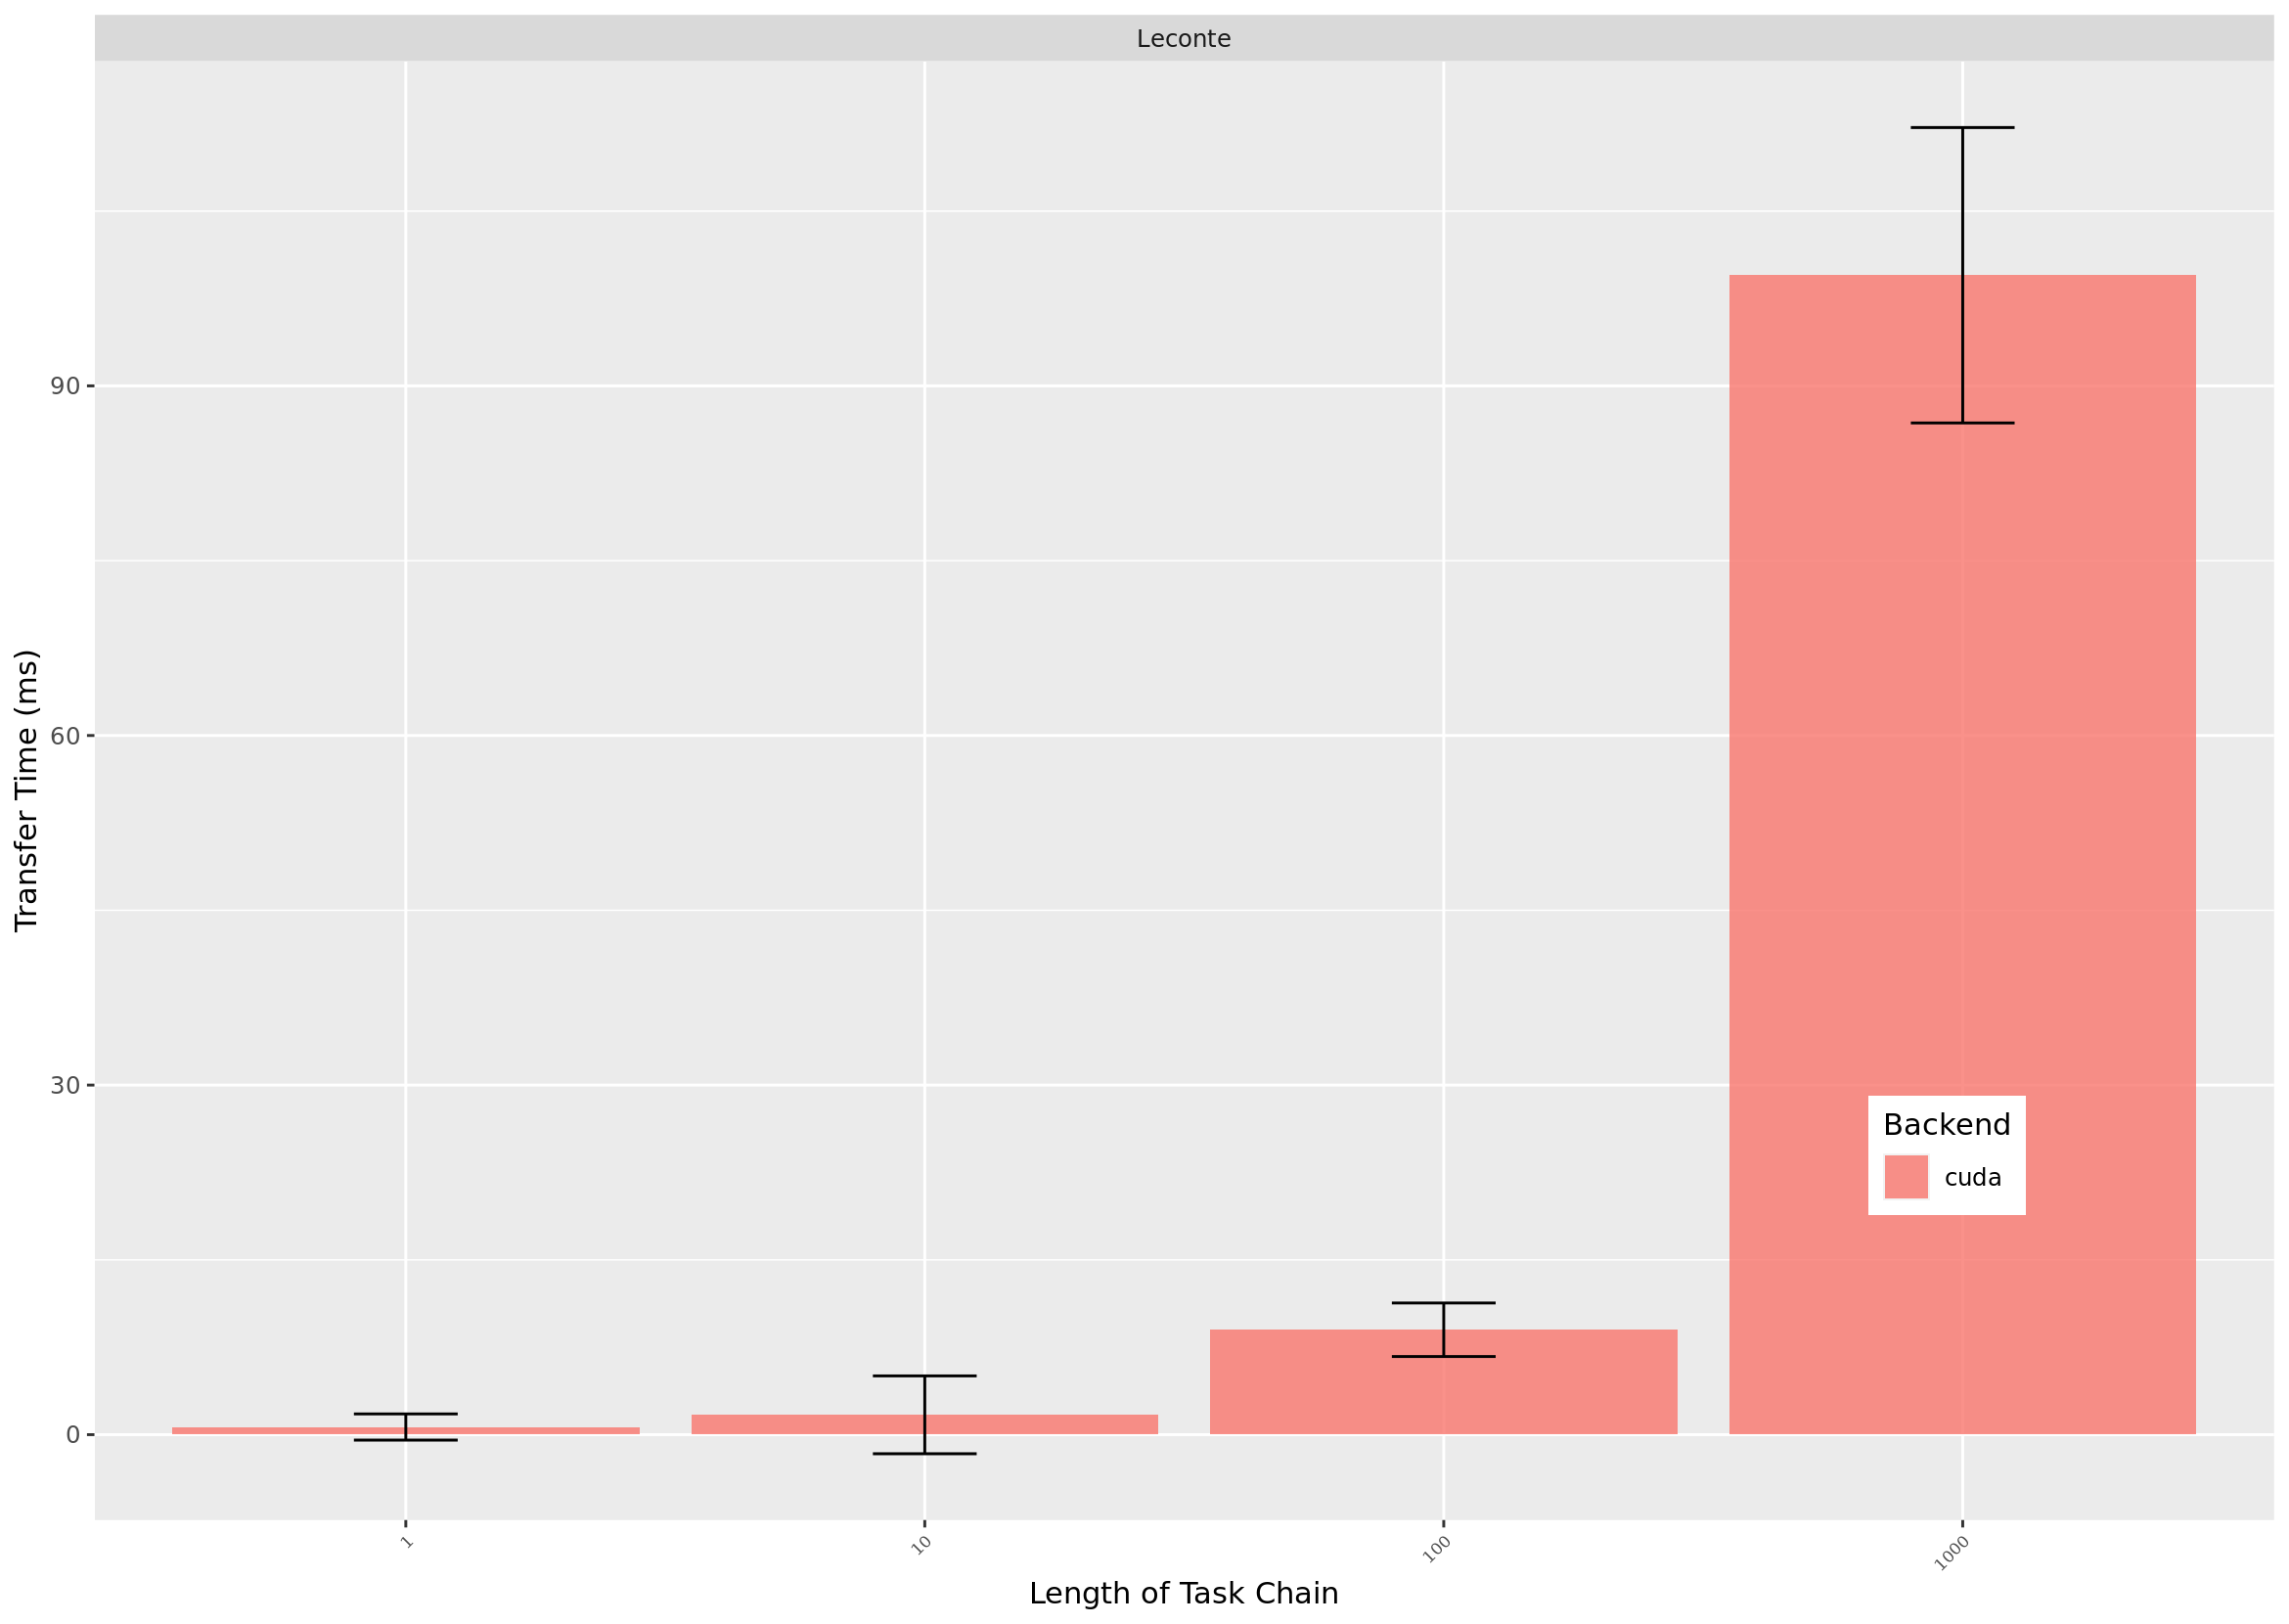

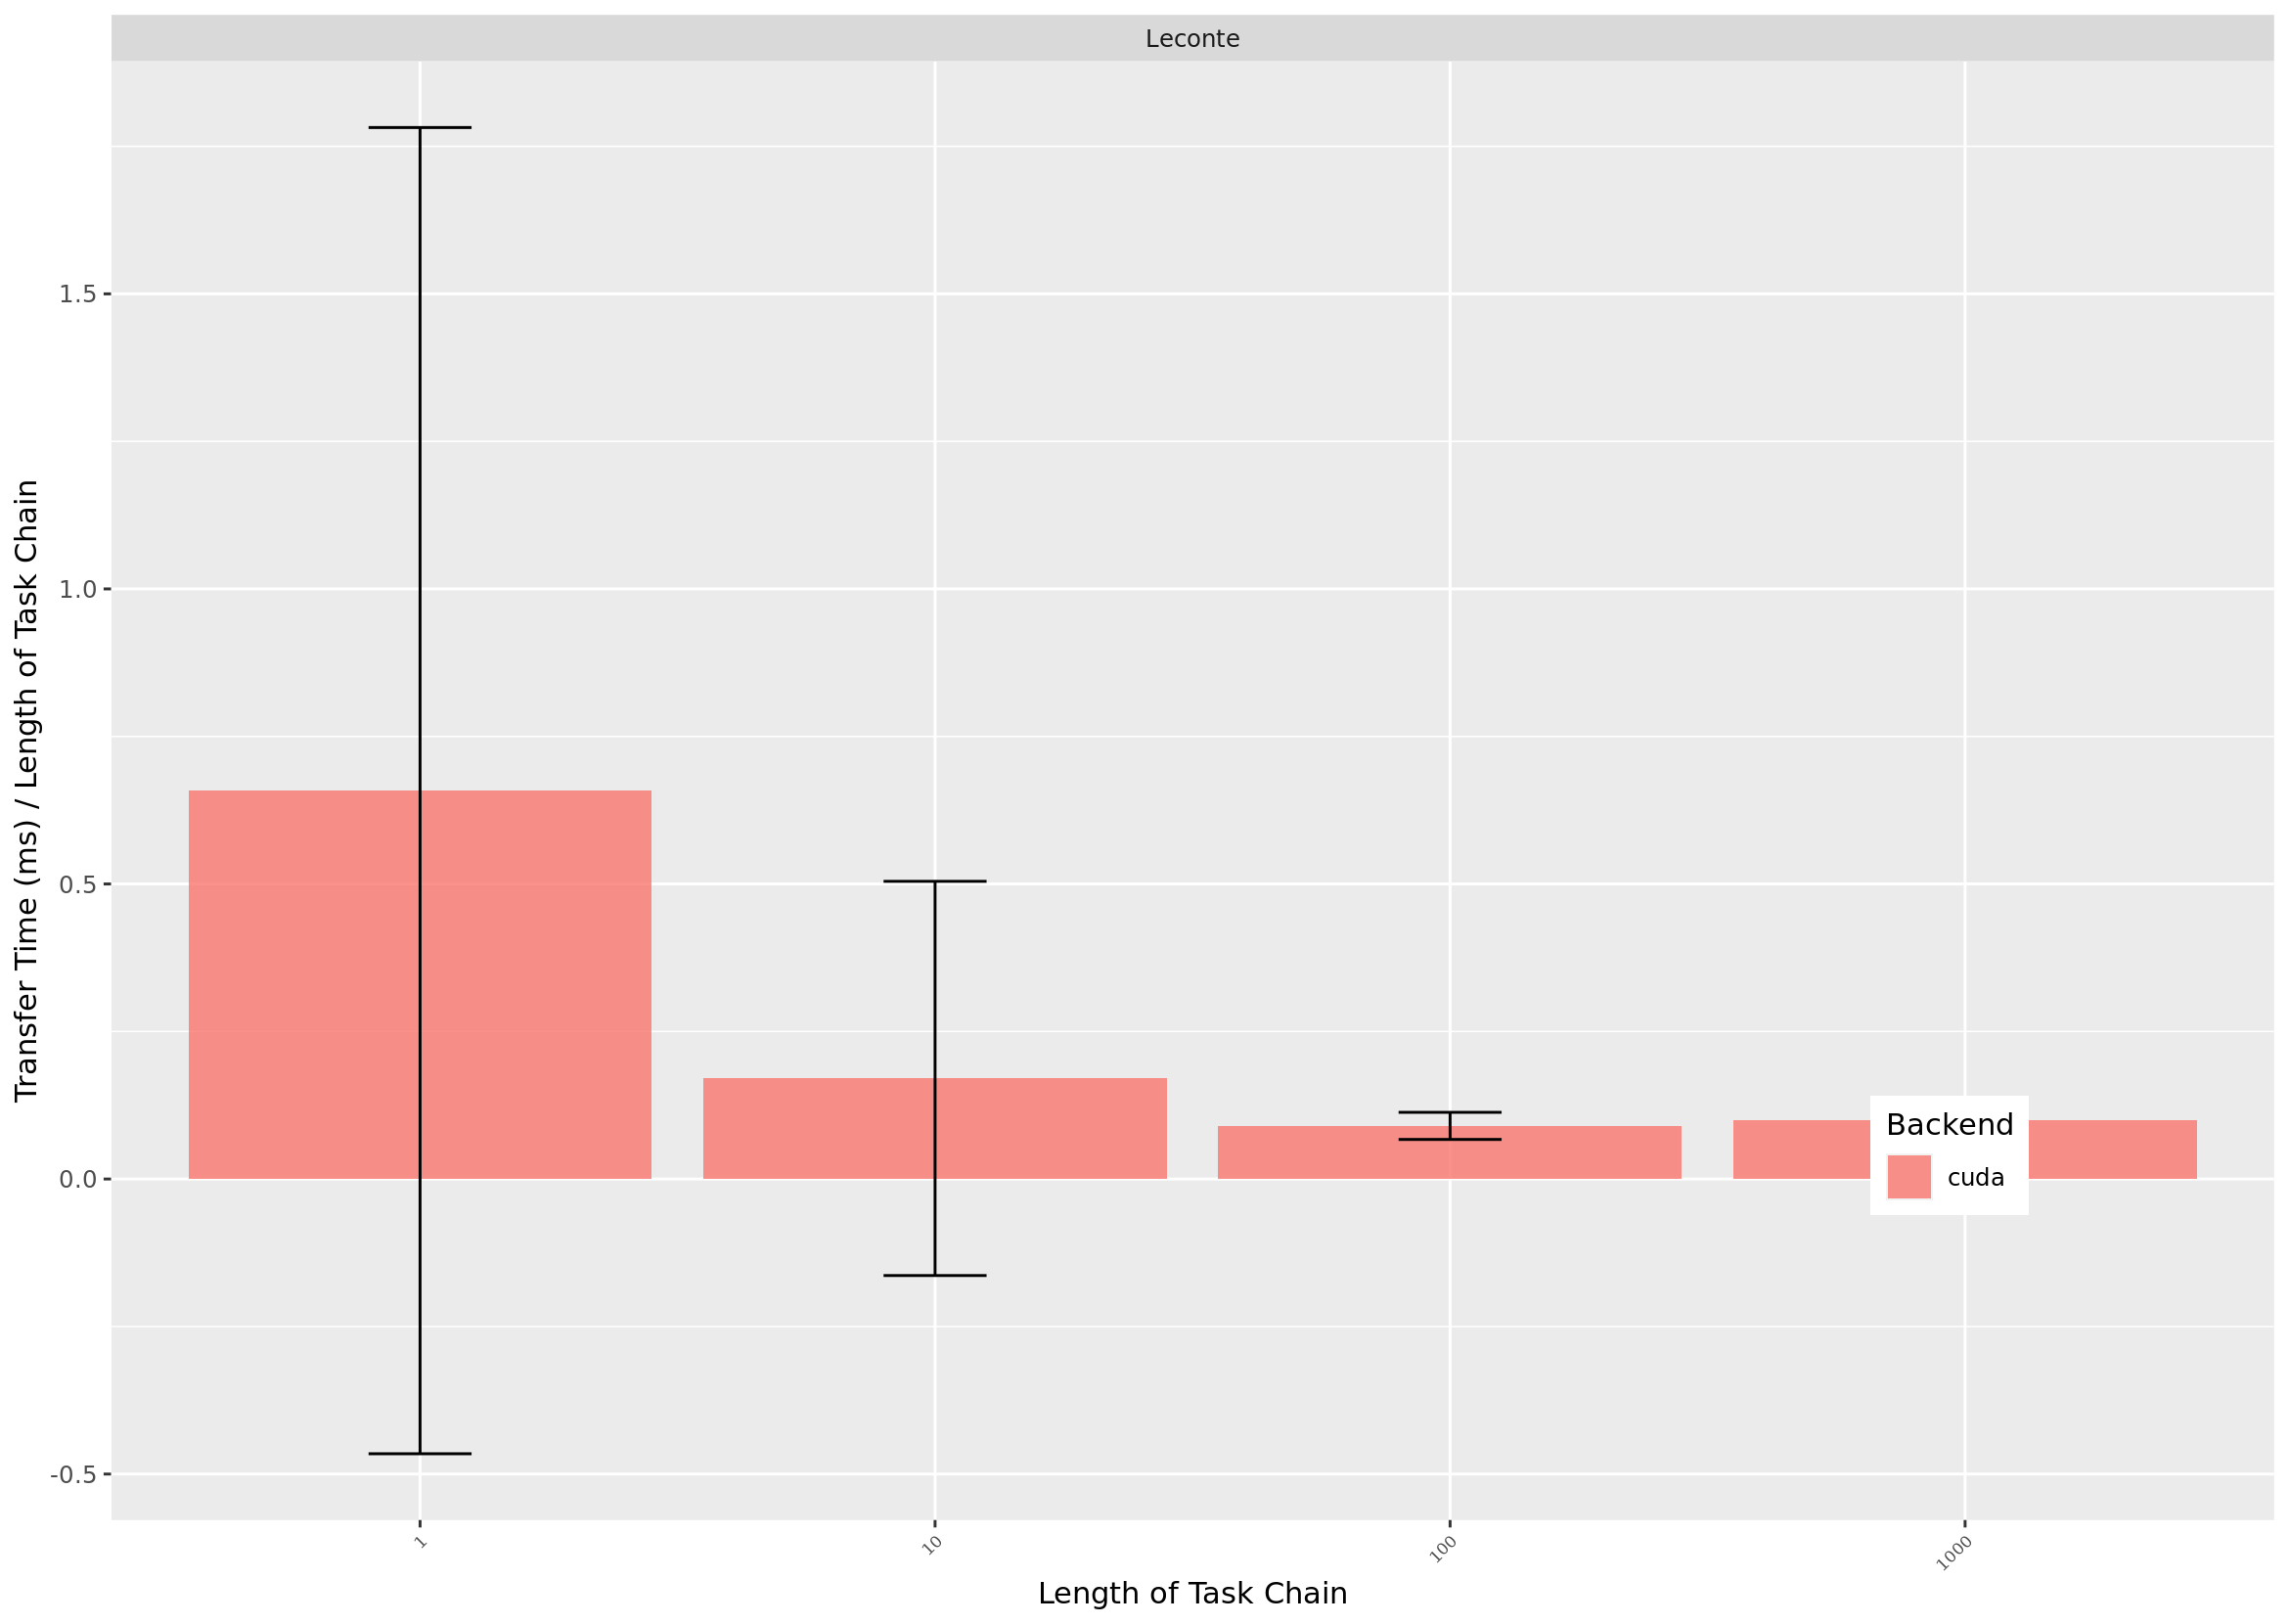

In [11]:
%%R -i number_of_transfers -h 8.3 -w 11.7 --units in -r 200

outlier_size = 0.5

library('ggplot2')
library('latex2exp')
library('scales')
library('ggsci')
library("ggpattern")
library("dplyr")

#reorder systems
number_of_transfers$system <- factor(number_of_transfers$system, levels = c("Oswald", "Equinox", "Leconte", "Radeon", "Explorer"))

library(dplyr)

number_of_transfers%>%
group_by(system,  version, chain_length, size)%>% 
summarise(Mean=mean(ms), Max=max(ms), Min=min(ms), Median=median(ms), Std=sd(ms)) %>%
{. ->> nt_sum }

p1 <- ggplot(nt_sum, aes(x=chain_length, y=Median, fill=version, group=interaction(chain_length,version))) + theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 6)) + expand_limits(y = 0) + expand_limits(y = 0) + facet_wrap( ~ system, strip.position = "top", scales = "free_x")# + scale_x_log10("Number Of Kernel Launches", breaks = trans_breaks("log10", function(x) 10^x)) + 

#p1 <- p1 + geom_bar_pattern(stat='identity',position="dodge2",alpha=0.8, pattern_alpha=0.5, color = "black", pattern_fill = "white", pattern_angle = 45, pattern_density = 0.5, pattern_spacing = 0.025, pattern_key_scale_factor = 0.75) 
#p1 <- p1 + scale_pattern_manual(values = c(Native = "none", IRIS = "stripe", MultiDevice = "crosshatch"))
p1 <- p1 + geom_bar(stat='identity', position="dodge2",alpha=0.8)
p0 <- p1 + geom_errorbar(aes(ymin=Median-Std, ymax=Median+Std), width=.2, position=position_dodge(.9))# + colFill + colScale
p0 <- p0 + guides(fill   = guide_legend(override.aes = list(pattern = "none")))
p0 <- p0 + guides(pattern= guide_legend(override.aes = list(fill = "white")))
p0 <- p0 + labs(fill="Backend", pattern="Implementation", y="Transfer Time (ms)", x="Length of Task Chain")
p0 <- p0 + theme(legend.position = c(0.85, 0.25))
print(p0)

ggsave(filename="num-transfers.pdf",path="./iris-and-dagger-paper/figures",width=8.3,height=11.7,units="in",dpi="retina")

#and normalized (divided by the number of items in the chain)
number_of_transfers$norm_ms <- number_of_transfers$ms / as.integer(number_of_transfers$chain_length)

number_of_transfers%>%
group_by(system,  version, chain_length, size)%>% 
summarise(Mean=mean(norm_ms), Max=max(norm_ms), Min=min(norm_ms), Median=median(norm_ms), Std=sd(norm_ms)) %>%
{. ->> nt_sum }

p1 <- ggplot(nt_sum, aes(x=chain_length, y=Median, fill=version, group=interaction(chain_length,version))) + theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 6)) + expand_limits(y = 0) + expand_limits(y = 0) + facet_wrap( ~ system, strip.position = "top", scales = "free_x")# + scale_x_log10("Number Of Kernel Launches", breaks = trans_breaks("log10", function(x) 10^x)) + 

#p1 <- p1 + geom_bar_pattern(stat='identity',position="dodge2",alpha=0.8, pattern_alpha=0.5, color = "black", pattern_fill = "white", pattern_angle = 45, pattern_density = 0.5, pattern_spacing = 0.025, pattern_key_scale_factor = 0.75) 
#p1 <- p1 + scale_pattern_manual(values = c(Native = "none", IRIS = "stripe", MultiDevice = "crosshatch"))
p1 <- p1 + geom_bar(stat='identity', position="dodge2",alpha=0.8)
p0 <- p1 + geom_errorbar(aes(ymin=Median-Std, ymax=Median+Std), width=.2, position=position_dodge(.9))# + colFill + colScale
p0 <- p0 + guides(fill   = guide_legend(override.aes = list(pattern = "none")))
p0 <- p0 + guides(pattern= guide_legend(override.aes = list(fill = "white")))
p0 <- p0 + labs(fill="Backend", pattern="Implementation", y="Transfer Time (ms) / Length of Task Chain", x="Length of Task Chain")
p0 <- p0 + theme(legend.position = c(0.85, 0.25))
print(p0)

ggsave(filename="norm_num-transfers.pdf",path="./iris-and-dagger-paper/figures",width=8.3,height=11.7,units="in",dpi="retina")



## Size of Transfers

`summarise()` has grouped output by 'system', 'version', 'chain_length'. You can override using the `.groups` argument.


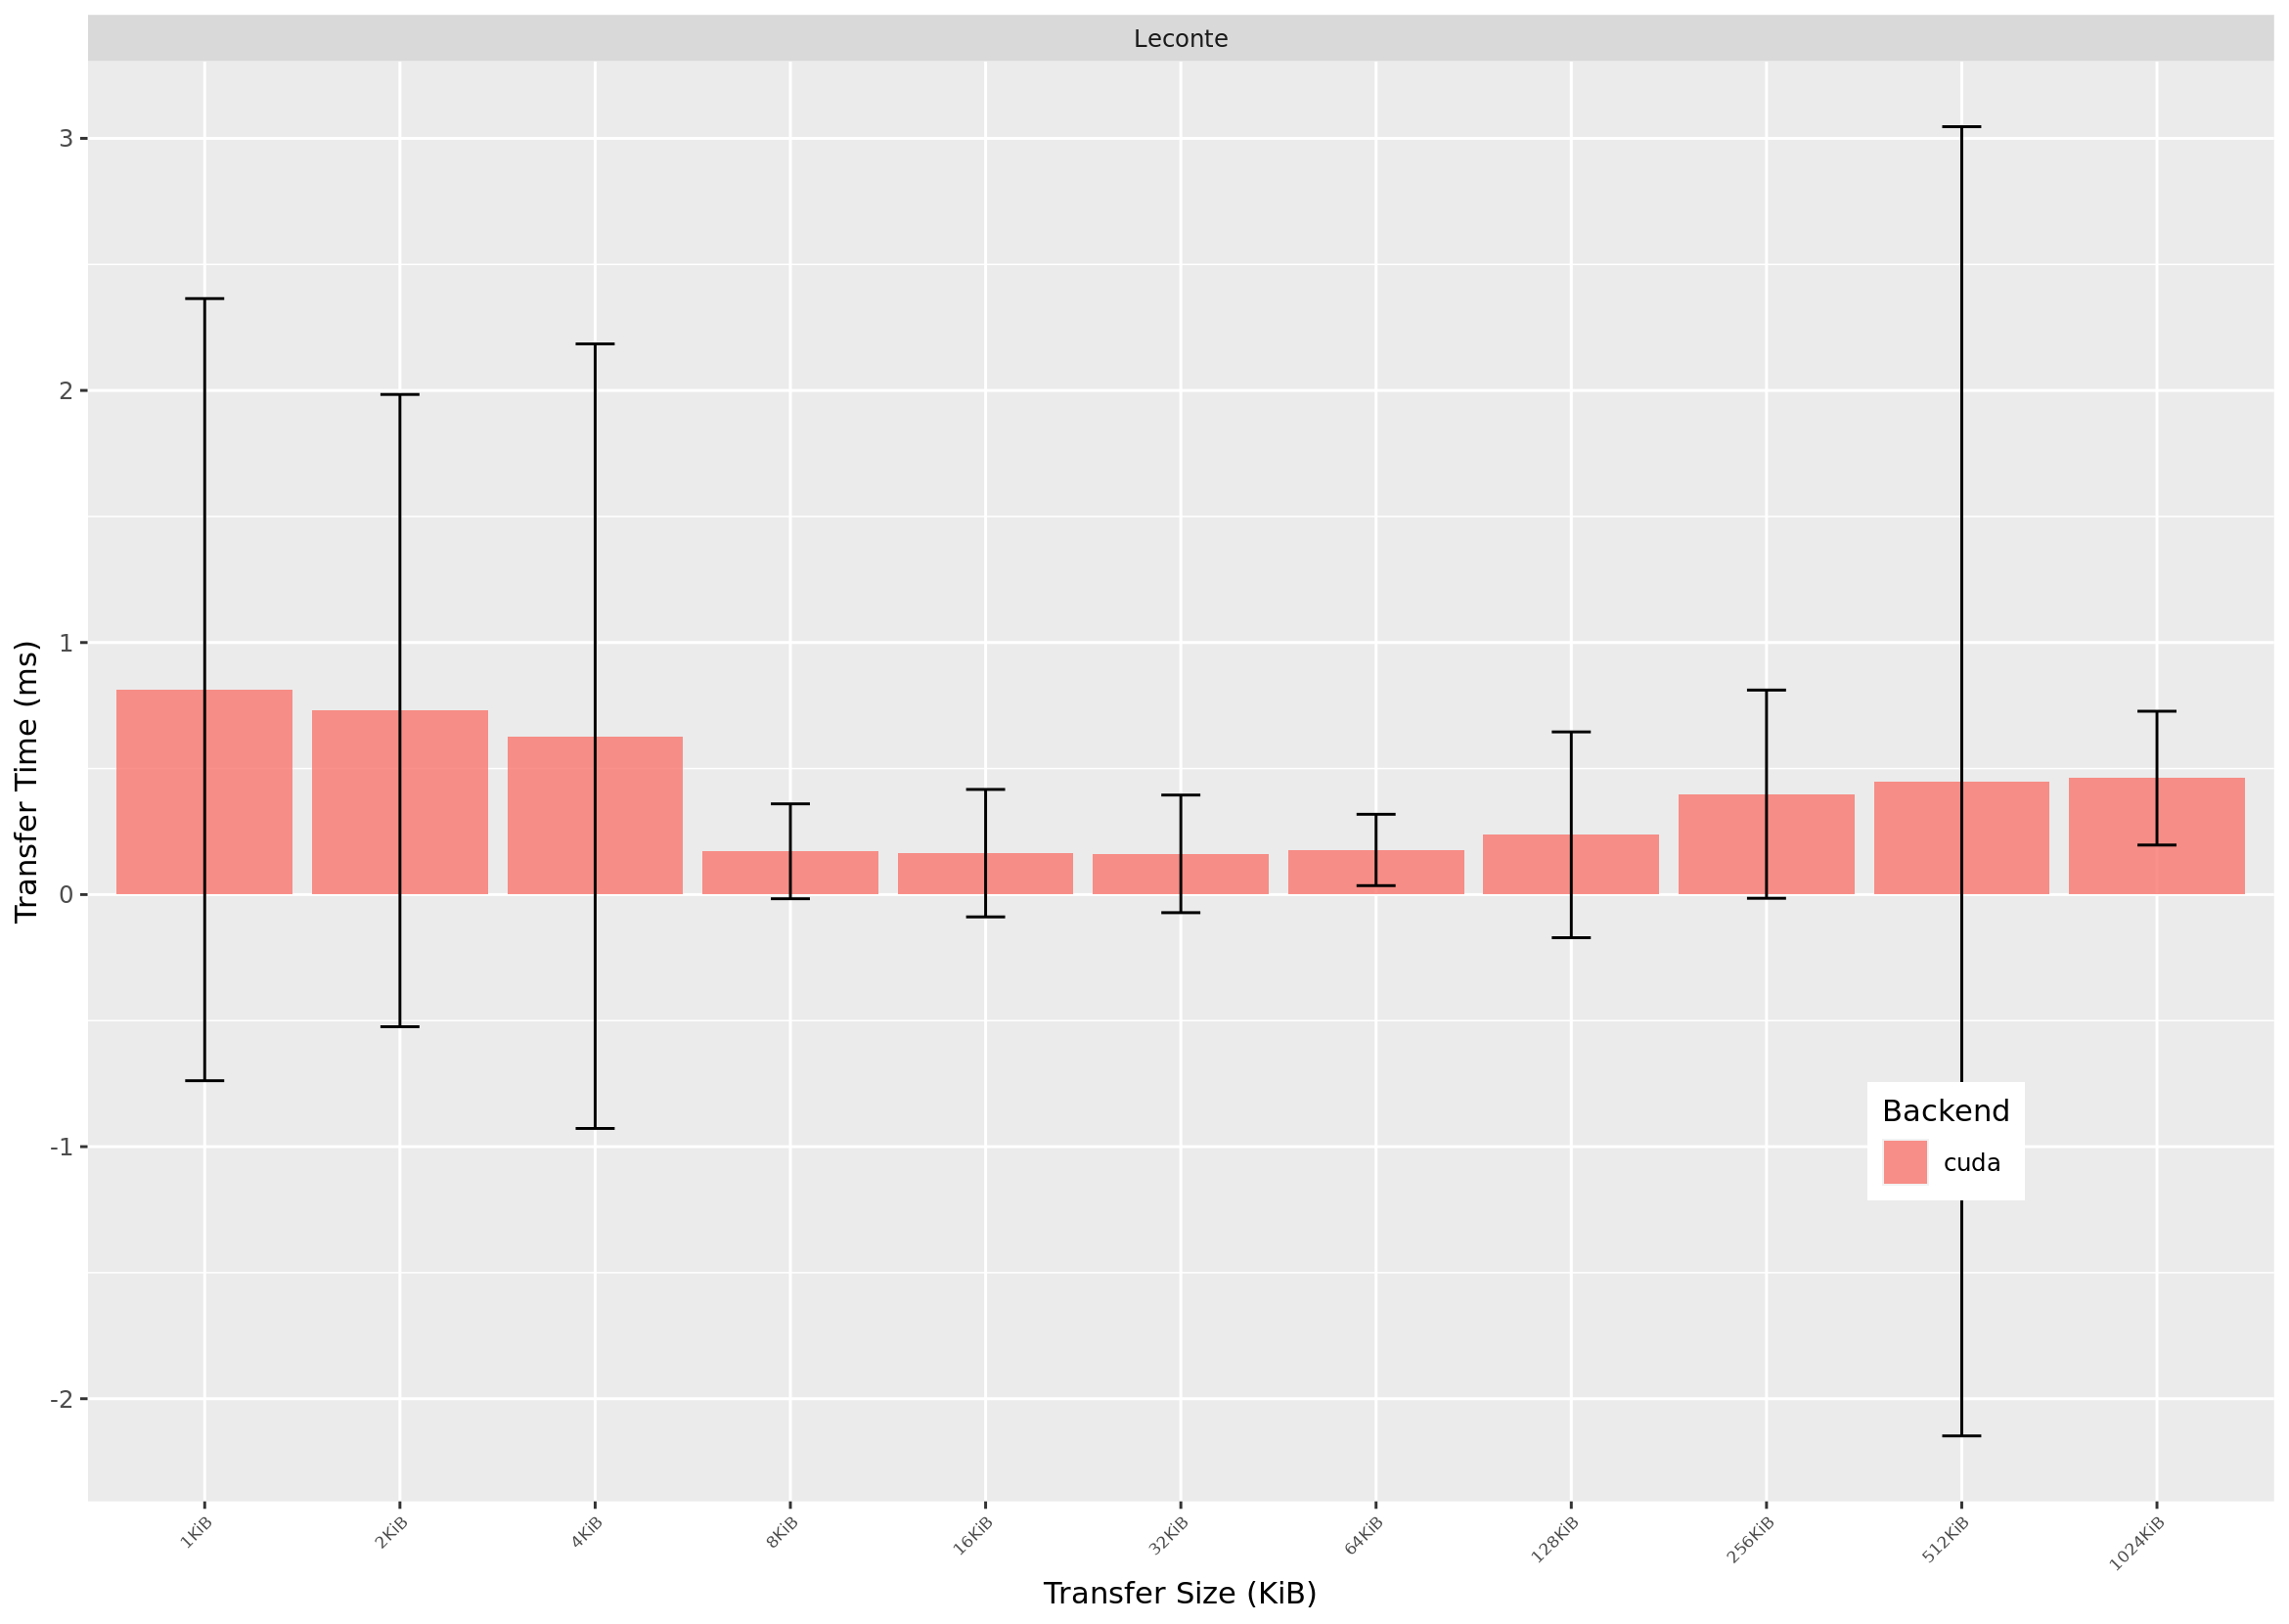

In [12]:
%%R -i transfer_size -h 8.3 -w 11.7 --units in -r 200

outlier_size = 0.5

library('ggplot2')
library('latex2exp')
library('scales')
library('ggsci')
library("ggpattern")
library("dplyr")

#reorder systems
transfer_size$system <- factor(transfer_size$system, levels = c("Oswald", "Equinox", "Leconte", "Radeon", "Explorer"))
#transfer_size$KiB <- transfer_size$KiB[order(as.integer(gsub("([0-9]+)KiB","\\1",transfer_size$KiB)))]
transfer_size$KiB <- factor(transfer_size$KiB, levels = c("1KiB","2KiB","4KiB","8KiB","16KiB","32KiB","64KiB","128KiB","256KiB","512KiB","1024KiB"))
transfer_size$chain_length = as.integer(transfer_size$chain_length)
transfer_size$norm_ms <- transfer_size$ms / transfer_size$chain_length

transfer_size%>%
group_by(system,  version, chain_length, KiB)%>%
summarise(Mean=mean(norm_ms), Max=max(norm_ms), Min=min(norm_ms), Median=median(norm_ms), Std=sd(norm_ms)) %>%
#summarise(Mean=mean(ms), Max=max(ms), Min=min(ms), Median=median(ms), Std=sd(ms)) %>%
{. ->> ts_sum }

p1 <- ggplot(ts_sum, aes(x=KiB, y=Median, fill=version, group=interaction(KiB,version))) + theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 6)) + expand_limits(y = 0) + expand_limits(y = 0) + facet_wrap( ~ system, strip.position = "top", scales = "free_x")# + scale_x_log10("Number Of Kernel Launches", breaks = trans_breaks("log10", function(x) 10^x)) + 

#p1 <- p1 + geom_bar_pattern(stat='identity',position="dodge2",alpha=0.8, pattern_alpha=0.5, color = "black", pattern_fill = "white", pattern_angle = 45, pattern_density = 0.5, pattern_spacing = 0.025, pattern_key_scale_factor = 0.75) 
#p1 <- p1 + scale_pattern_manual(values = c(Native = "none", IRIS = "stripe", MultiDevice = "crosshatch"))
p1 <- p1 + geom_bar(stat='identity', position="dodge2",alpha=0.8)
p0 <- p1 + geom_errorbar(aes(ymin=Median-Std, ymax=Median+Std), width=.2, position=position_dodge(.9))# + colFill + colScale
p0 <- p0 + guides(fill   = guide_legend(override.aes = list(pattern = "none")))
p0 <- p0 + guides(pattern= guide_legend(override.aes = list(fill = "white")))
p0 <- p0 + labs(fill="Backend", pattern="Implementation", y="Transfer Time (ms)", x="Transfer Size (KiB)")
p0 <- p0 + theme(legend.position = c(0.85, 0.25))
print(p0)

ggsave(filename="transfer-size.pdf",path="./iris-and-dagger-paper/figures",width=8.3,height=11.7,units="in",dpi="retina")


## Summary

In [13]:
%%R -i transfer_size -i number_of_transfers -i kernellaunch

library('scales')
library("dplyr")

transfer_size$system <- factor(transfer_size$system, levels = c("Oswald", "Equinox", "Leconte", "Radeon", "Explorer"))
transfer_size$KiB <- factor(transfer_size$KiB, levels = c("1KiB","2KiB","4KiB","8KiB","16KiB","32KiB","64KiB","128KiB","256KiB","512KiB","1024KiB"))
transfer_size$chain_length = as.integer(transfer_size$chain_length)
transfer_size$norm_ms <- transfer_size$ms / transfer_size$chain_length
transfer_size%>%
group_by(system,  version, chain_length, KiB)%>% 
summarise(Mean=mean(norm_ms), Max=max(norm_ms), Min=min(norm_ms), Median=median(norm_ms), Std=sd(norm_ms)) %>%
{. ->> ts_sum }

number_of_transfers$system <- factor(number_of_transfers$system, levels = c("Oswald", "Equinox", "Leconte", "Radeon", "Explorer"))
number_of_transfers$chain_length = as.integer(number_of_transfers$chain_length)
number_of_transfers$norm_ms <- number_of_transfers$ms / number_of_transfers$chain_length
number_of_transfers%>%
group_by(system,  version, chain_length, size)%>% 
summarise(Mean=mean(norm_ms), Max=max(norm_ms), Min=min(norm_ms), Median=median(norm_ms), Std=sd(norm_ms)) %>%
{. ->> nt_sum }

#print(nt_sum$Median/nt_sum$chain_length)
print(paste("Median (ms) time to move a buffer: ",round(median(nt_sum$Median),2)))

cat("\n\n")
print("Compare this to the Kernel Launch Latency results (from earlier)")

# But kernel latency has already been computed---these tasks take no payload whatsoever and thus should be smaller
# Let's see how they compare!
kernellaunch$Backend <- kernellaunch$builton
kernellaunch$version <- factor(kernellaunch$version, levels = c("cuda", "iris-cuda", "multigpu-iris-cuda", "hip", "iris-hip", "multigpu-iris-hip", "opencl", "iris-opencl", "multigpu-iris-opencl"))
kernellaunch$system <- factor(kernellaunch$system, levels = c("Oswald", "Equinox", "Leconte", "Radeon", "Explorer"))
kernellaunch$runtime <- recode(kernellaunch$runtime, native = "Native", iris = "IRIS", multigpu = "MultiDevice")
kernellaunch$runtime <- factor(kernellaunch$runtime,levels = c("Native","IRIS","MultiDevice"))
kernellaunch %>% filter(system == "Leconte", runtime == "IRIS", Backend == "CUDA") %>% {. ->> kernellaunch} # only show leconte
kernellaunch$latency <- kernellaunch$runtimes / kernellaunch$num_launches # latency is the total duration times / the number of kernels invoked
kernellaunch%>%
group_by(num_launches,system,  version, runtime, Backend)%>% 
summarise(Mean=mean(latency), Max=max(latency), Min=min(latency), Median=median(latency), Std=sd(latency)) %>%
{. ->> kl_sum }
print(kl_sum)
cat("Note: These times are reported in *microseconds* (us)\n")
cat(paste("Chains of 10 tasks have a median of ",round(kl_sum[kl_sum$num_launches == 10,]$Median,2)," us\n"))
cat(paste("\t\t\t\t or ",round(kl_sum[kl_sum$num_launches == 10,]$Median*10**-3,2)," ms\n\n"))

av_mem_latency <- round(median(nt_sum$Median),2)
no_mem_latency <- round(kl_sum[kl_sum$num_launches == 10,]$Median*10**-3,2)
cat(paste("The latency of issuing an empty task = ",no_mem_latency,"\n\n"))

print("Time to move a buffer of different sizes:")
cat(paste("\t",ts_sum$KiB, "\ttakes: ", round( (ts_sum$Median) - no_mem_latency ,2), "ms\n"))

print("Can we guess the time taken to transmit 10 (4KiB) memory transfer tasks")
cat(paste("Experimental result: ", round( nt_sum[nt_sum$chain_length==10,]$Median,2),"ms\n"))
cat(paste("Guessed: 0.14 ms, Took: ", round( nt_sum[nt_sum$chain_length==10,]$Median - no_mem_latency,2),"ms\n"))

print(nt_sum)
#cat(paste("\t",ts_sum$KiB, "\ttakes: ", round( (ts_sum$Median/ts_sum$chain_length) - av_mem_latency ,2), "ms\n"))





`summarise()` has grouped output by 'system', 'version', 'chain_length'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'system', 'version', 'chain_length'. You can override using the `.groups` argument.
[1] "Median (ms) time to move a buffer:  0.13"


[1] "Compare this to the Kernel Launch Latency results (from earlier)"
`summarise()` has grouped output by 'num_launches', 'system', 'version', 'runtime'. You can override using the `.groups` argument.
# A tibble: 4 × 10
# Groups:   num_launches, system, version, runtime [4]
  num_launches system  version runtime Backend  Mean    Max   Min Median     Std
         <int> <fct>   <fct>   <fct>   <chr>   <dbl>  <dbl> <dbl>  <dbl>   <dbl>
1            1 Leconte iris-c… IRIS    CUDA    174.  1403.   37.2   90.1 224.   
2           10 Leconte iris-c… IRIS    CUDA     22.6  206.   18.5   20.6  11.1  
3          100 Leconte iris-c… IRIS    CUDA     15.7   32.6  14.9   15.5   1.17 
4         1000 Leconte iris-c…

We see each memory transfer tends to have a minimum overhead of 170 μs, this corresponds to the latency involved in performing the memory transfer reguardless of amount of data to move around. 

# Miscellaneous

### Analysis of distributions of kernel launch overhead times for 100 sample runs.

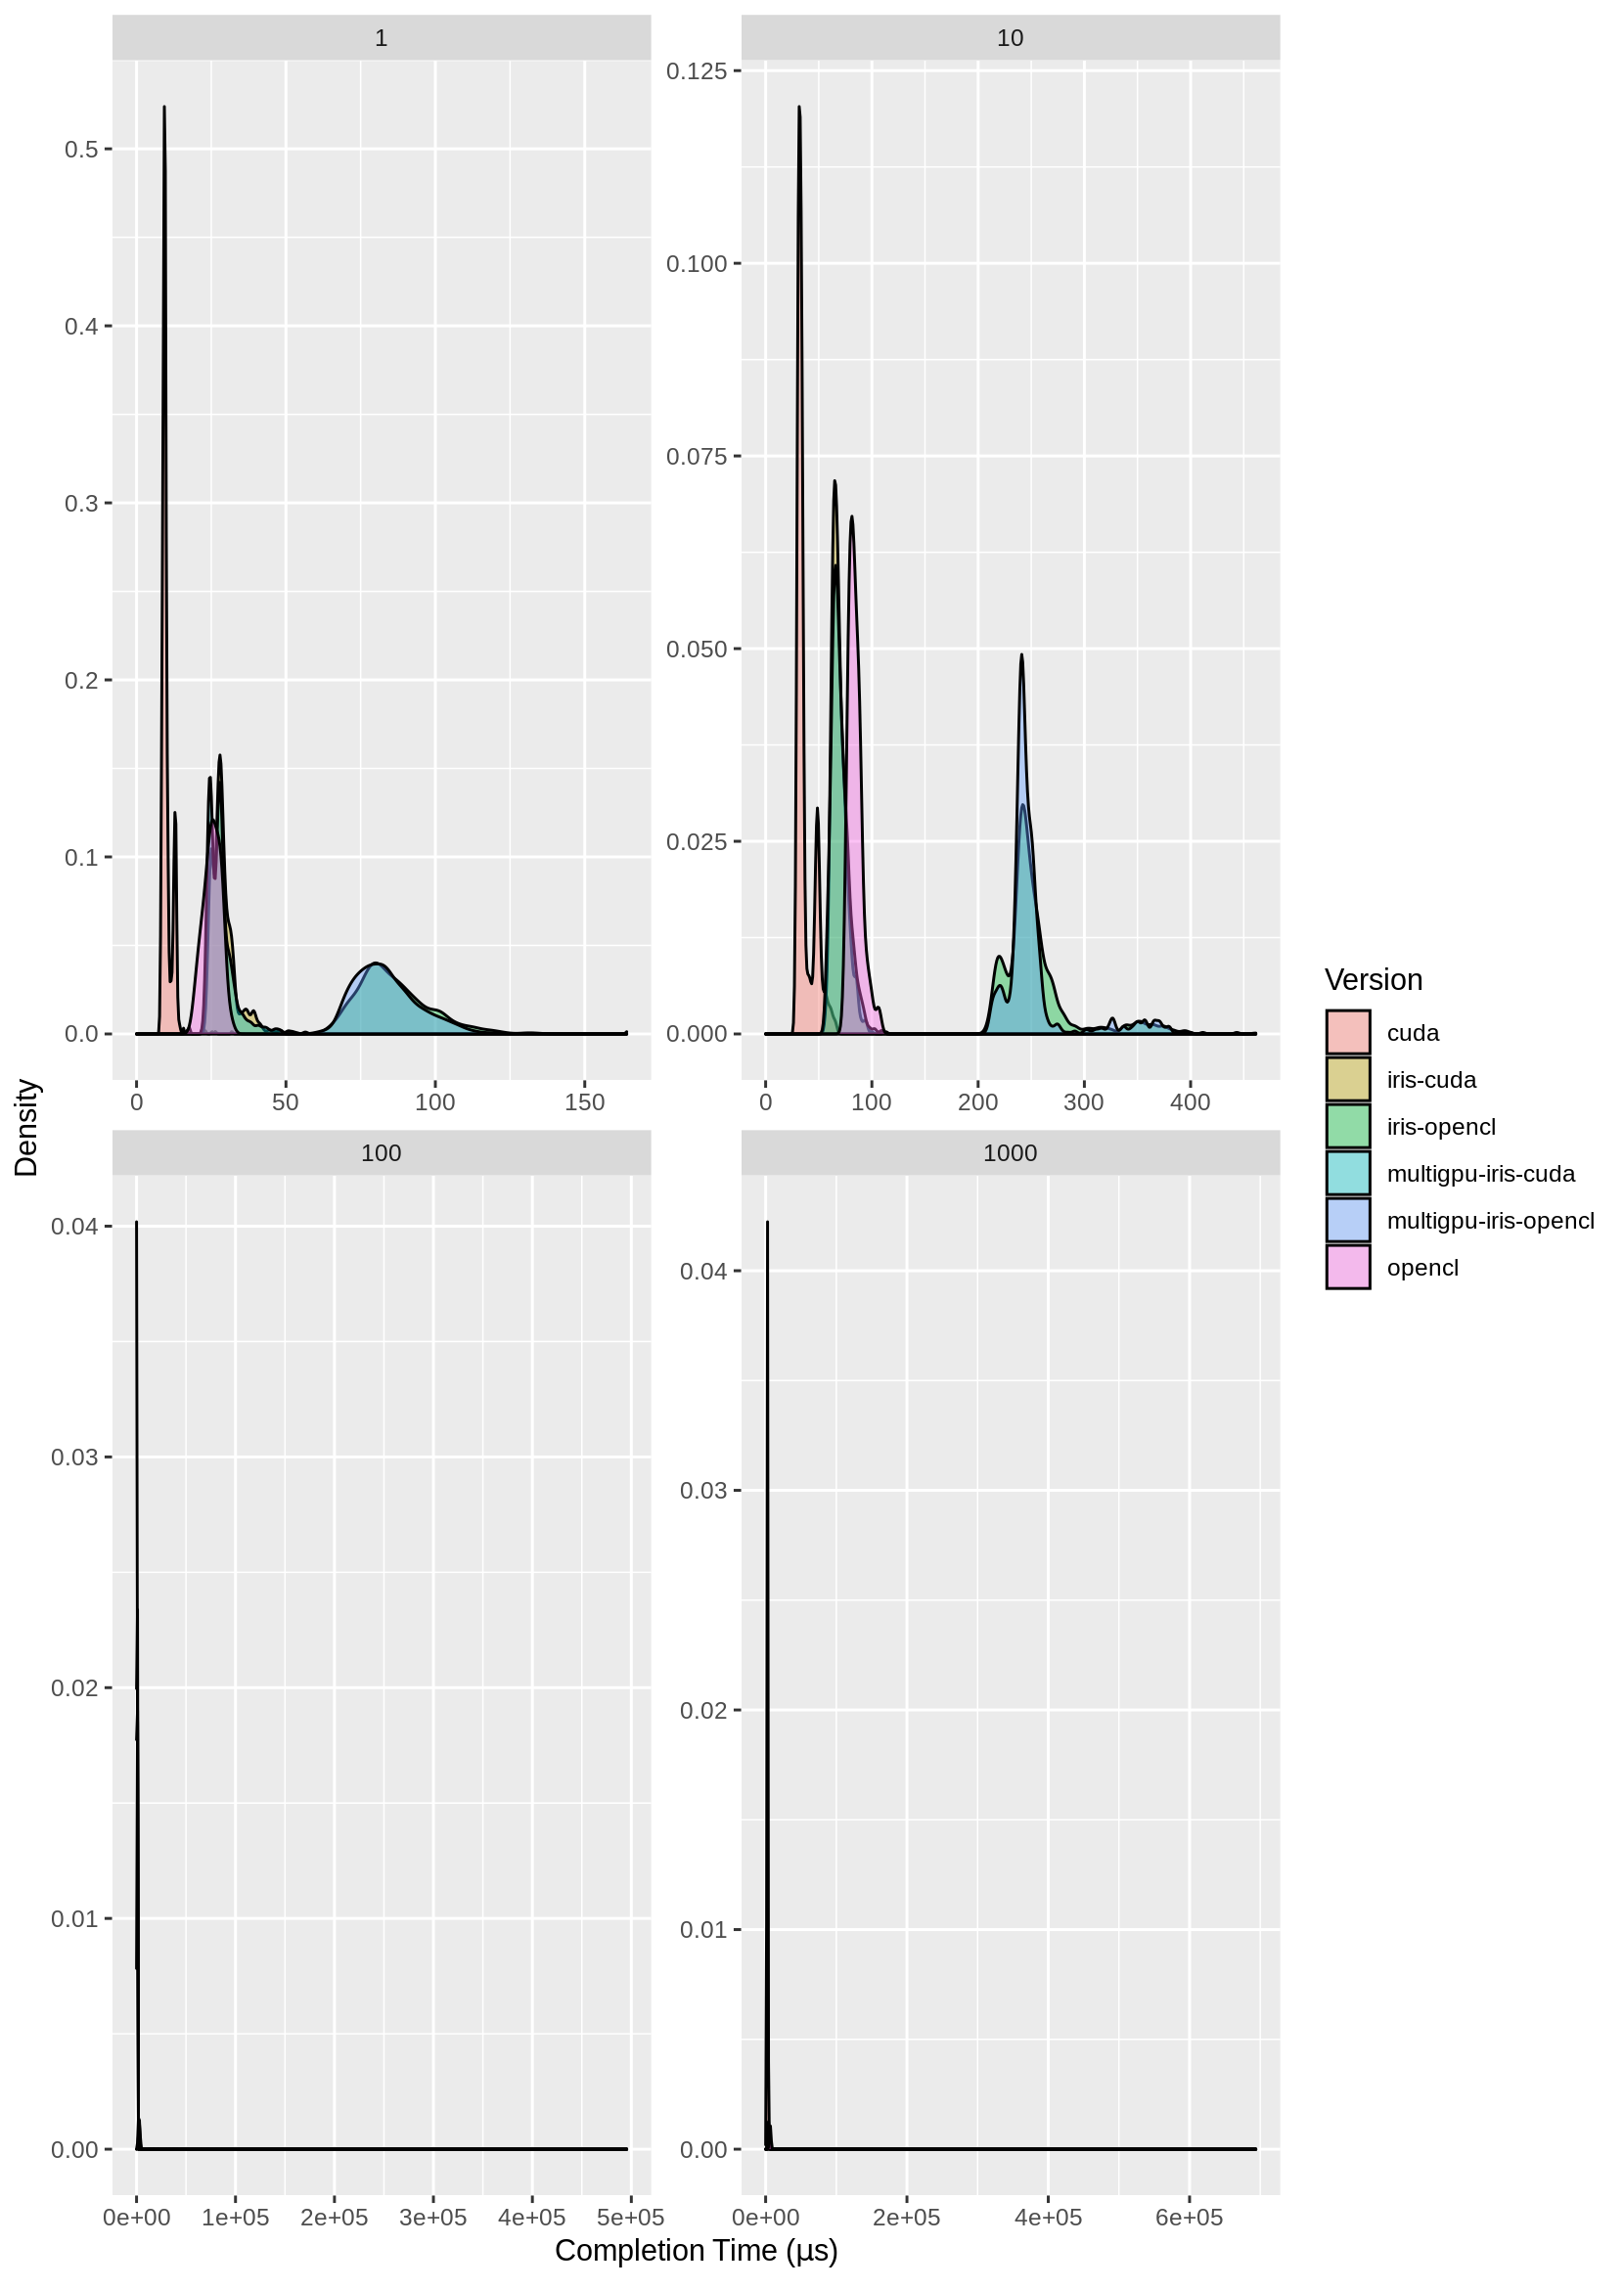

In [6]:
%%R -i kernellaunch -w 8.3 -h 11.7 --units in -r 200

outlier_size = 0.50

library('ggplot2')
library('latex2exp')
library('facetscales')

ggplot(kernellaunch, aes(x=runtimes, fill=version)) +
    expand_limits(y = 0, x = 0) + geom_density(alpha=0.4) + 
    guides(fill = "legend", colour = "none") + labs(fill="Version", x=TeX("Completion Time ($\\mu$s)"))+ #labs(fill = "Version", x="Completion Time (ms)") + #x=TeX("Completion Time ($\\mu$s)")) +
    scale_y_continuous(name = "Density") + facet_wrap(vars(num_launches),scales="free")

Visually, the distributions appear to be non-uniform. Still, perform a quick statistical test for to test if uniformly distributed data.

In [7]:
%%R -i kernellaunch

kernellaunch.iris <- subset(kernellaunch,version=='iris-hip' & num_launches==100)
#print(kernellaunch.iris)
kt <- kruskal.test(kernellaunch.iris)
print(kt)
if (kt$p.value < .05){
    print("statistically significantly different")
} else {
    print("identical data distributions")
}

R[write to console]: Error in kruskal.test.default(kernellaunch.iris) : 
  all groups must contain data

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In kruskal.test.default(kernellaunch.iris) :
R[write to console]: 
 
R[write to console]:  some elements of 'x' are not numeric and will be coerced to numeric




Error in kruskal.test.default(kernellaunch.iris) : 
  all groups must contain data


Not all distributions appear to be normally distributed and thus reporting the mean shouldn't be sufficient, instead we should report median with variance.

## Deeper Analysis for Linear Transfer Times

In [392]:
import glob
application_files = glob.glob("../membench/extensive-transfer-size-results/*.csv")

#discard the csv files where are the timeline of task and device it was run, instead we only consider the aggregate summation time logs.
application_files =  [i for i in application_files if i.count('-') == 6]

import pandas
df = None

for af in application_files:
    names = af.replace(".csv","")
    names = names.replace('../membench/extensive-transfer-size-results/',"")
    params = names.split("-")
    params.pop(0)
    elements = params.pop()
    system = params.pop()
    version = params.pop()
    with open(af, encoding="utf-8") as file:
        content = [l.rstrip("\n") for l in file]
    times = content[0].split(',')
    times = [float(ele) for ele in times]
    ndf = pandas.DataFrame({'ms':times,'system':system,'version':version,"elements":elements,'KiB':(int(elements)*4)/1024})
    if df is None:
        df = ndf
    else:
        df = pandas.merge(df,ndf,how='outer')

print(df)
full_transfer_size = df
extensive_transfer_size = df[df['system'] == "Leconte"]

               ms    system version elements     KiB
0      506.518000  Explorer     hip     8192    32.0
1        0.831604  Explorer     hip     8192    32.0
2        0.730276  Explorer     hip     8192    32.0
3        0.761032  Explorer     hip     8192    32.0
4        0.629425  Explorer     hip     8192    32.0
...           ...       ...     ...      ...     ...
49995    5.749230   Leconte    cuda  2097152  8192.0
49996    6.373410   Leconte    cuda  2097152  8192.0
49997    5.702260   Leconte    cuda  2097152  8192.0
49998    5.760430   Leconte    cuda  2097152  8192.0
49999    5.721330   Leconte    cuda  2097152  8192.0

[50000 rows x 5 columns]


`summarise()` has grouped output by 'system', 'version'. You can override using the `.groups` argument.


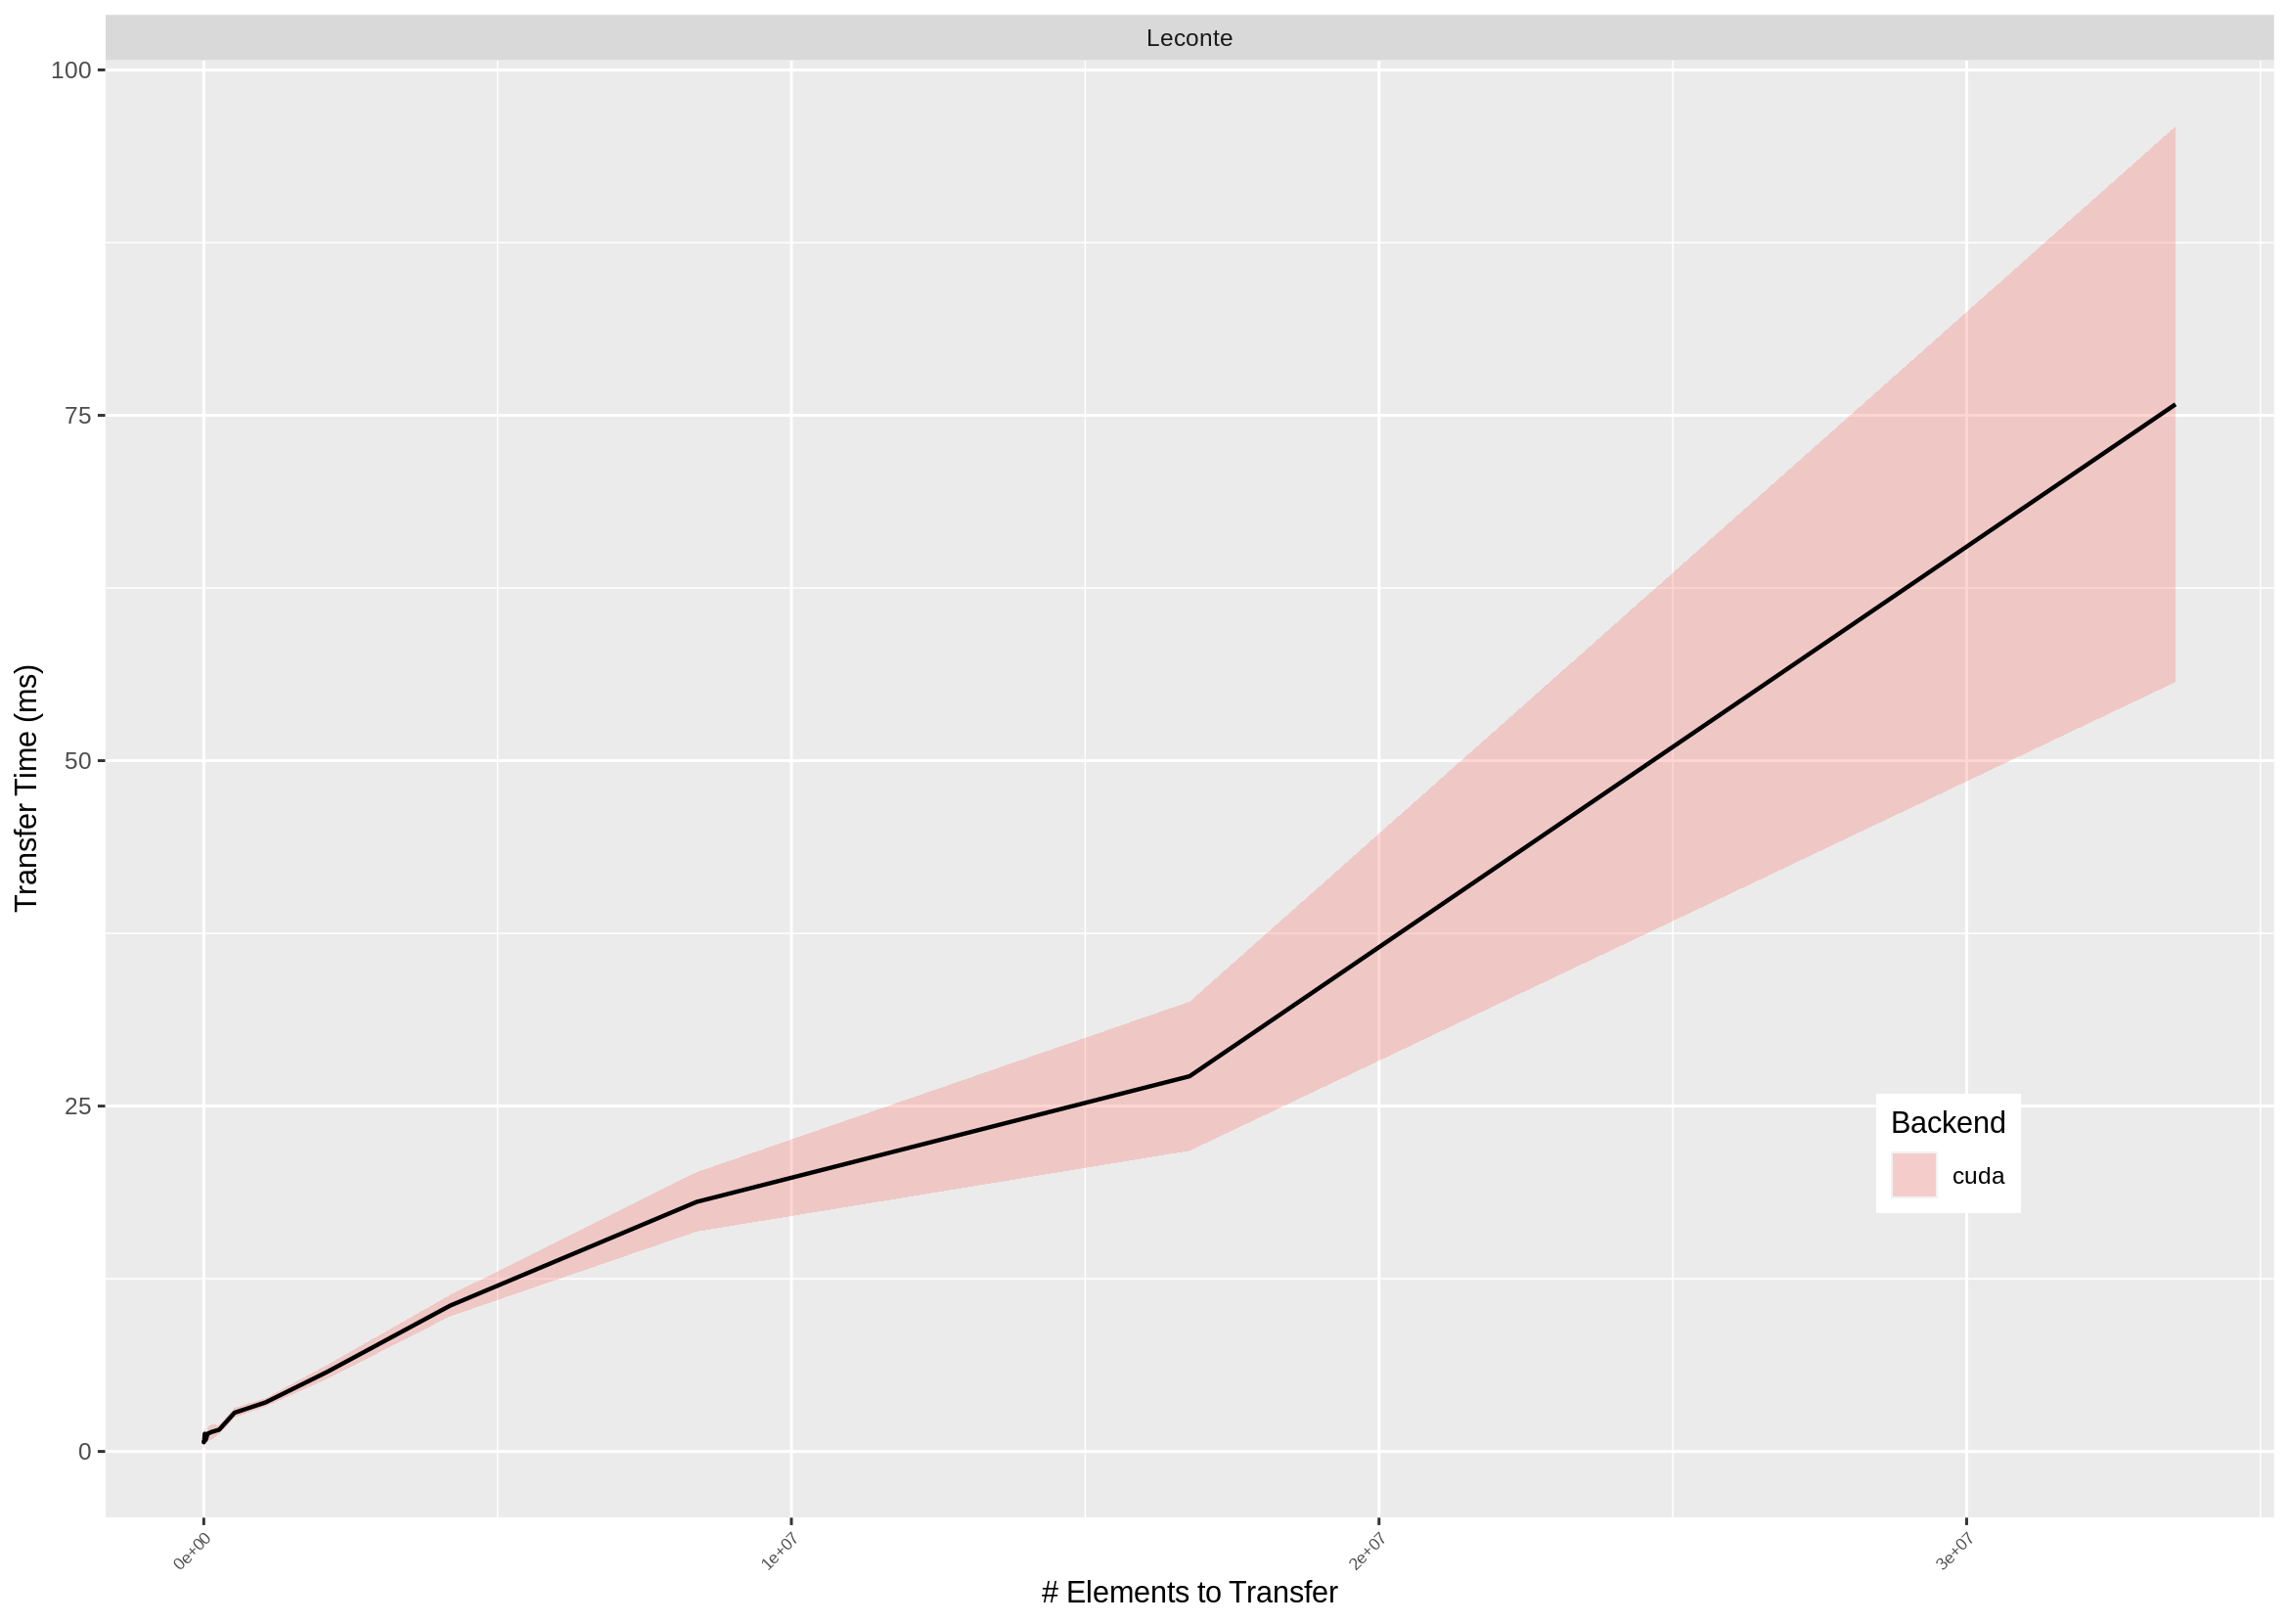

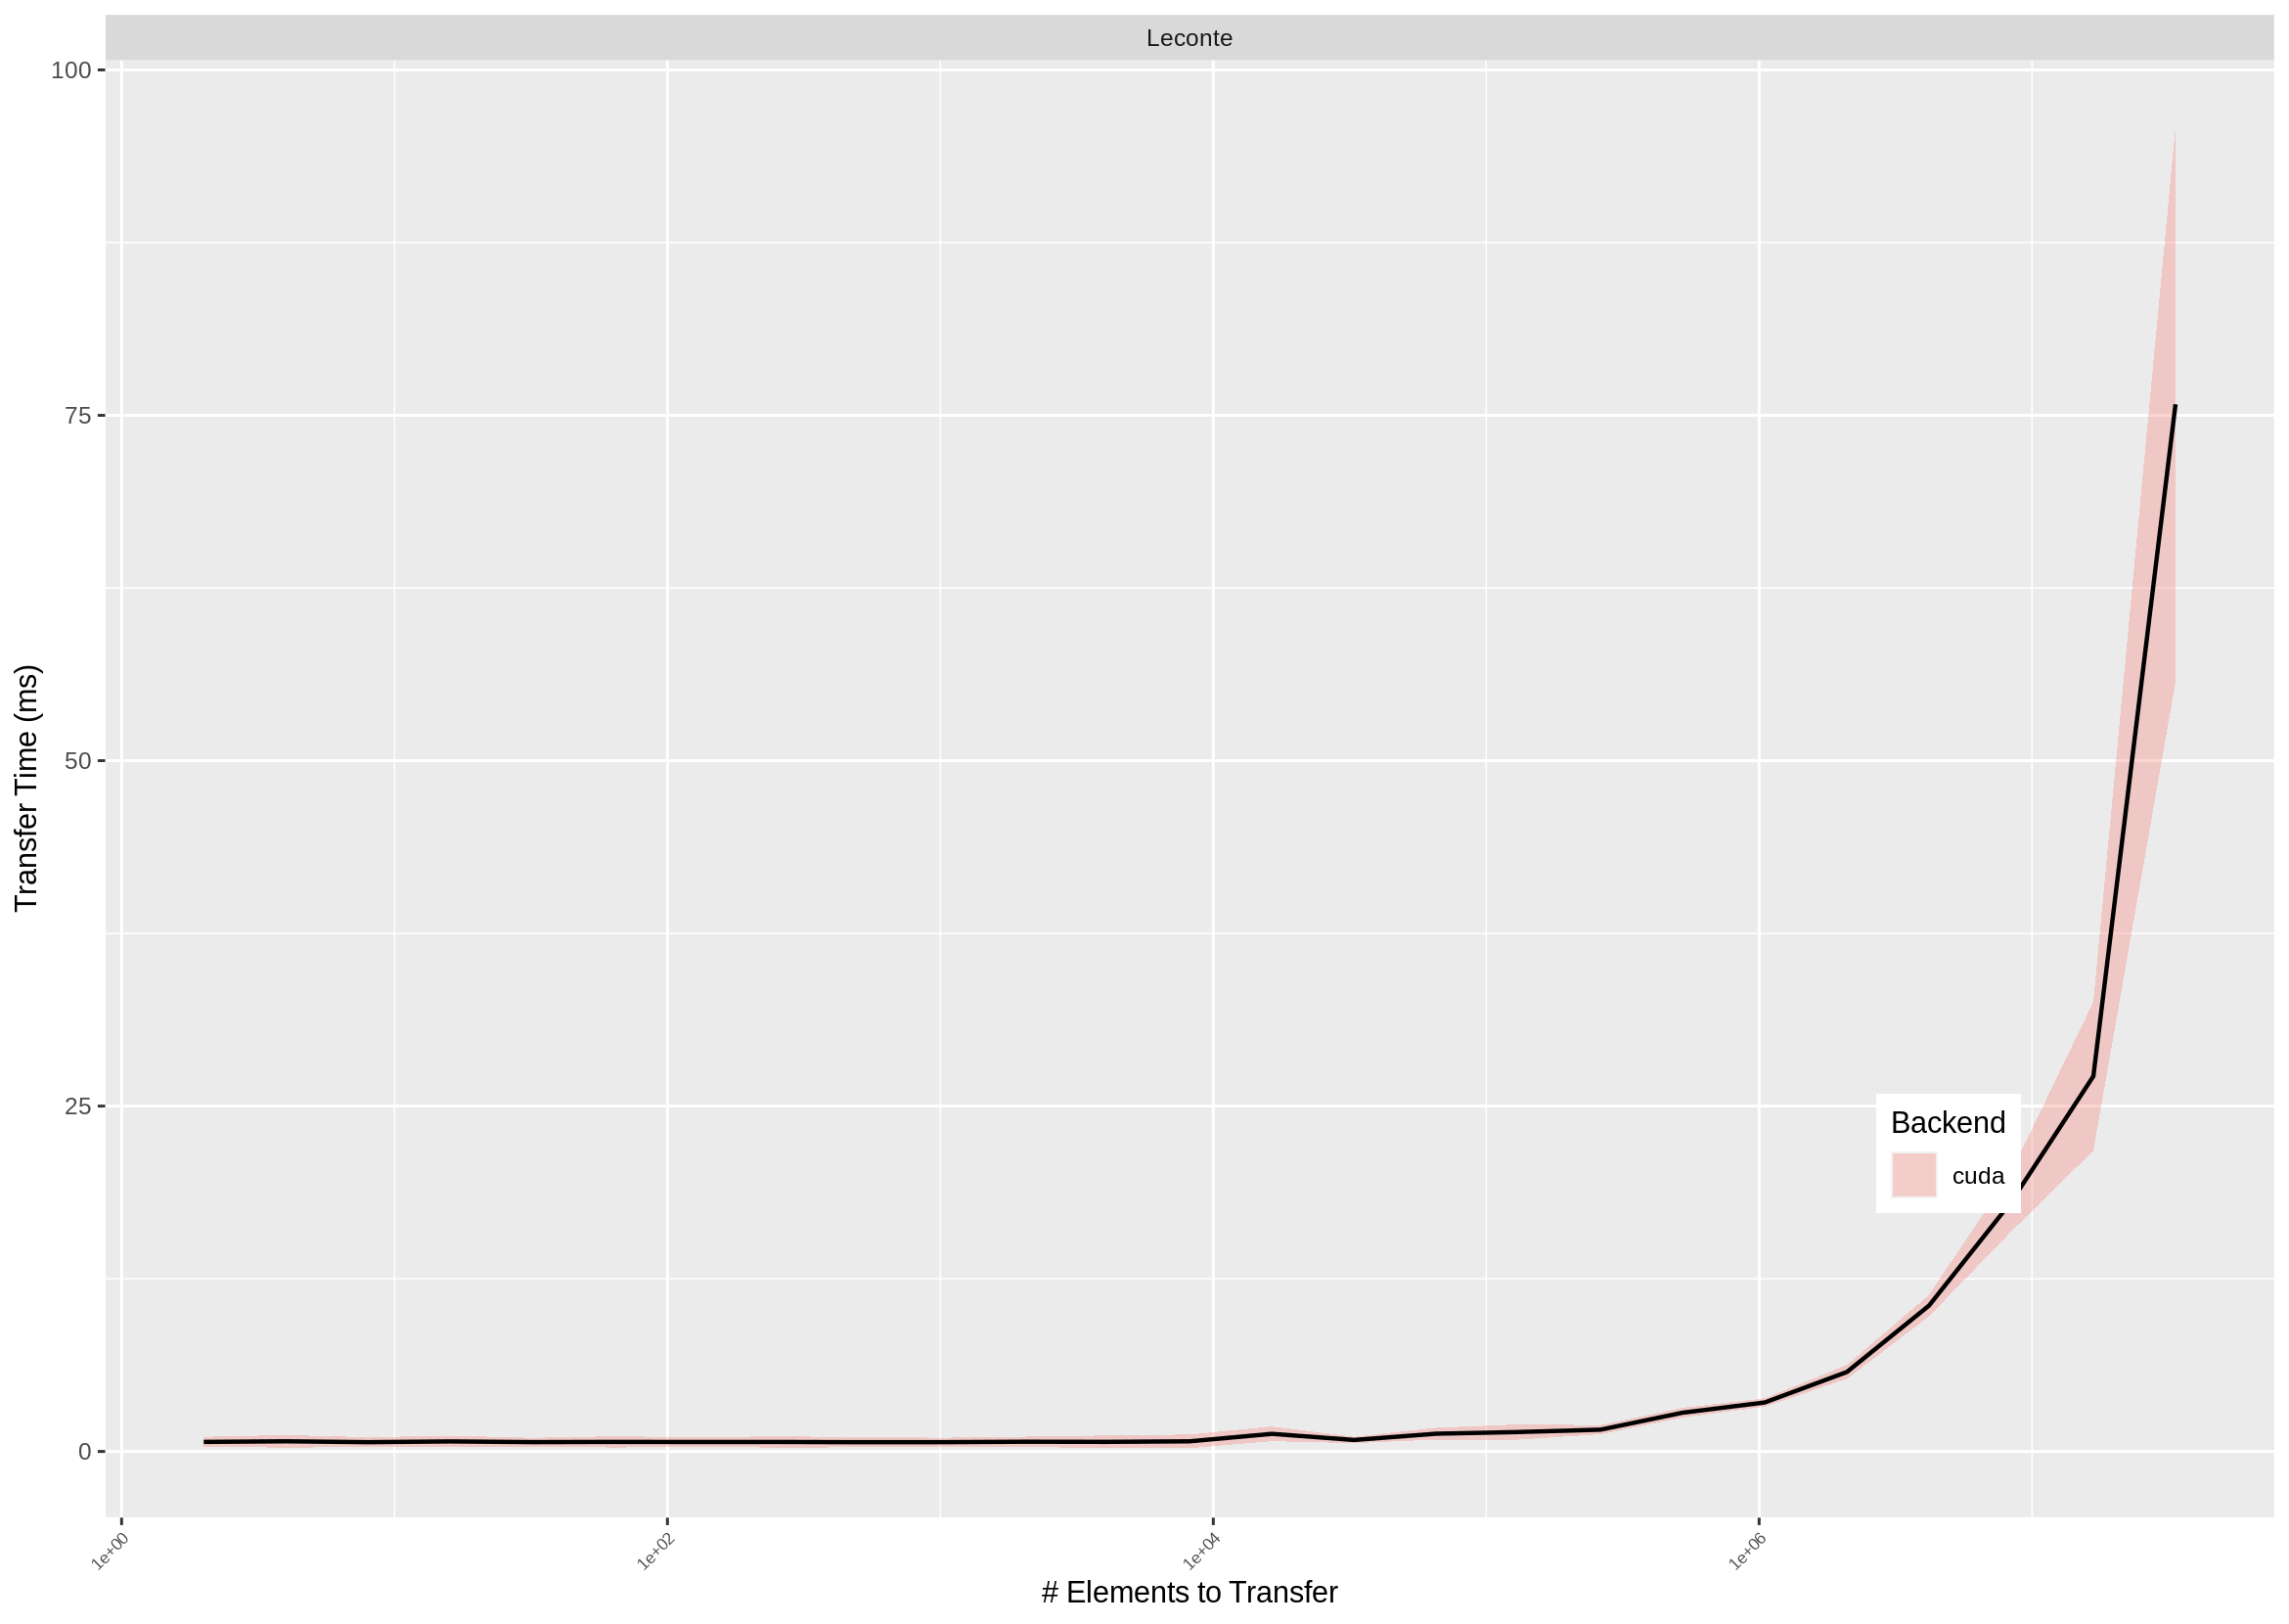

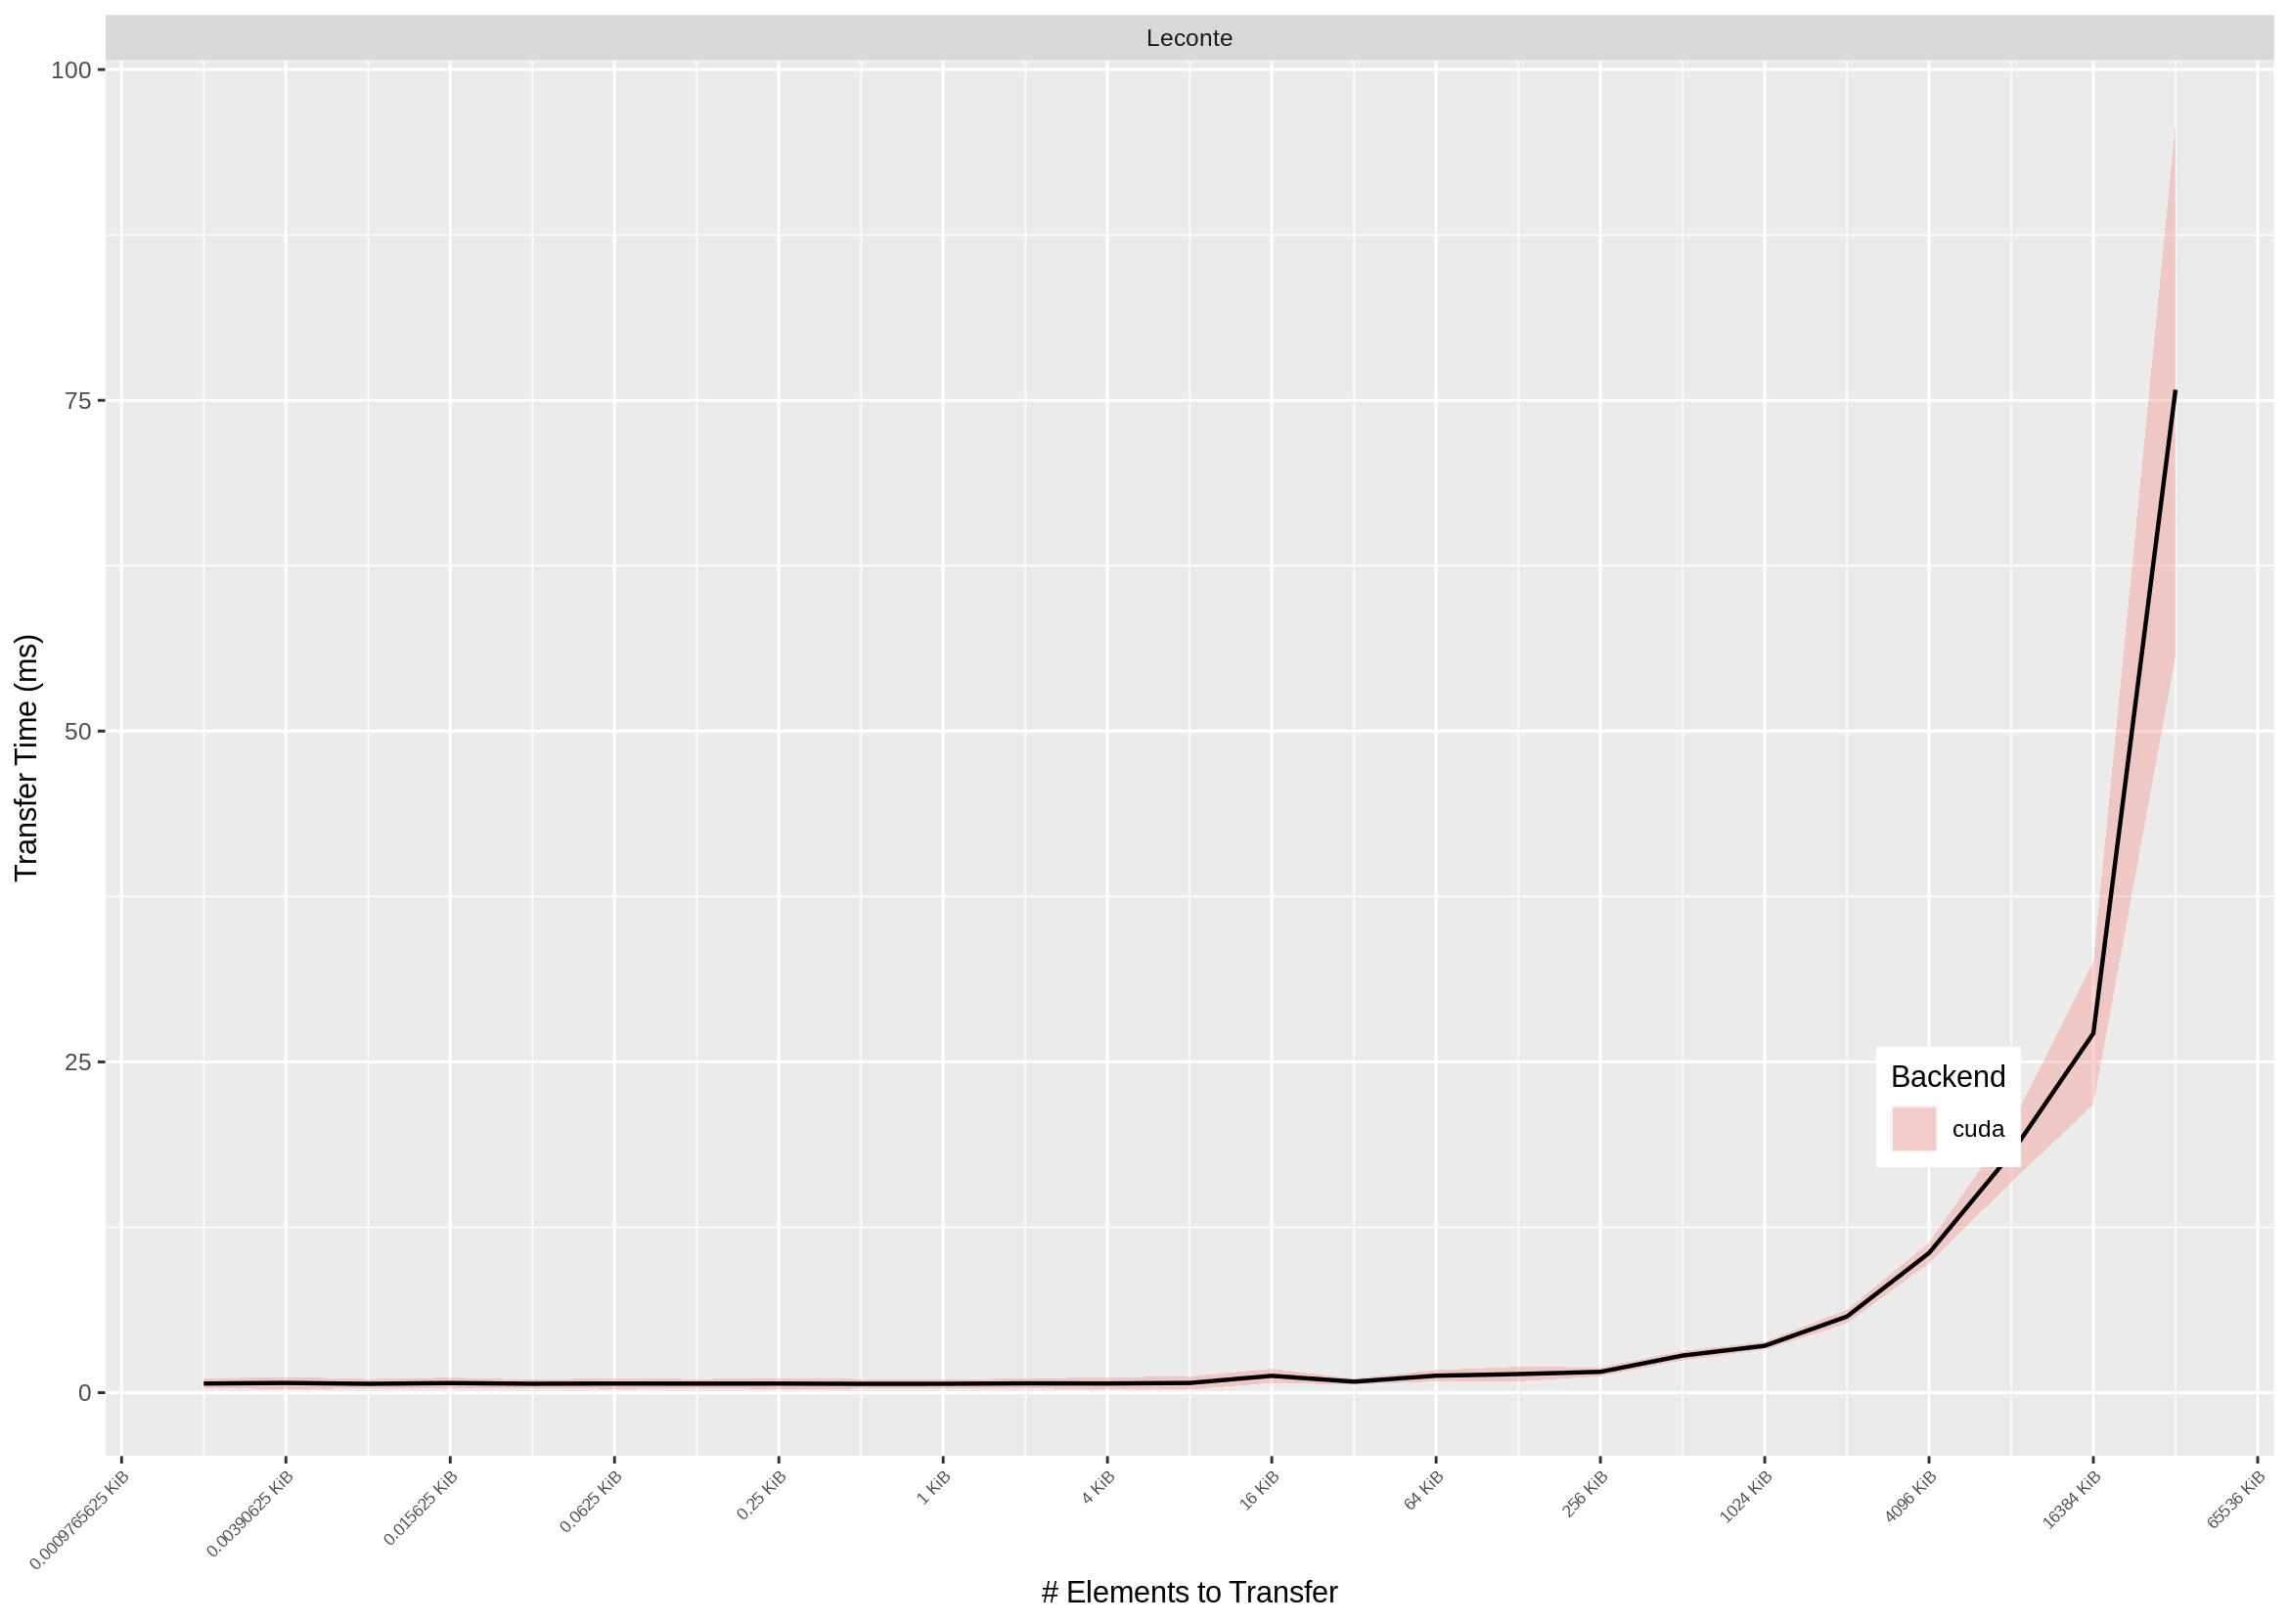

In [379]:
%%R -i extensive_transfer_size -h 8.3 -w 11.7 --units in -r 200

outlier_size = 0.5

library('ggplot2')
library('latex2exp')
library("dplyr")

extensive_transfer_size$system <- factor(extensive_transfer_size$system, levels = c("Oswald", "Equinox", "Leconte", "Radeon", "Explorer"))
extensive_transfer_size$elements <- as.integer(extensive_transfer_size$elements)


extensive_transfer_size%>%
group_by(system,  version, elements)%>%
summarise(Mean=mean(ms), Max=max(ms), Min=min(ms), Median=median(ms), Std=sd(ms)) %>%
{. ->> xts_sum }

p0 <- ggplot(xts_sum, aes(x=elements, y=Median, fill=version, group=interaction(version))) + theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 6)) + expand_limits(y = 0) + expand_limits(y = 0) + facet_wrap( ~ system, strip.position = "top", scales = "free_x")
p0 <- p0 + geom_ribbon(aes(ymin = Median-Std, ymax = Median+Std),alpha=0.3, linetype = 0)
p0 <- p0 + geom_line(aes(y = Median), alpha=1.0, size=0.75)
p0 <- p0 + guides(fill   = guide_legend(override.aes = list(pattern = "none")))
p0 <- p0 + guides(pattern= guide_legend(override.aes = list(fill = "white")))
p0 <- p0 + labs(fill="Backend", pattern="Implementation", y="Transfer Time (ms)", x="# Elements to Transfer") #x="Transfer Size (KiB)")
p0 <- p0 + theme(legend.position = c(0.85, 0.25))
print(p0)

ggsave(filename="extensive-transfer-size.pdf",path="./iris-and-dagger-paper/figures",width=8.3,height=11.7,units="in",dpi="retina")


p0 <- ggplot(xts_sum, aes(x=elements, y=Median, fill=version, group=interaction(version))) + theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 6)) + expand_limits(y = 0) + expand_limits(y = 0) + facet_wrap( ~ system, strip.position = "top", scales = "free_x") + scale_x_log10("# Elements to Transfer", breaks = trans_breaks("log10", function(x) 10^x))
p0 <- p0 + geom_ribbon(aes(ymin = Median-Std, ymax = Median+Std),alpha=0.3, linetype = 0)
p0 <- p0 + geom_line(aes(y = Median), alpha=1.0, size=0.75)
p0 <- p0 + guides(fill   = guide_legend(override.aes = list(pattern = "none")))
p0 <- p0 + guides(pattern= guide_legend(override.aes = list(fill = "white")))
p0 <- p0 + labs(fill="Backend", pattern="Implementation", y="Transfer Time (ms)", x="# Elements to Transfer") #x="Transfer Size (KiB)")
p0 <- p0 + theme(legend.position = c(0.85, 0.25))
print(p0)

ggsave(filename="extensive-transfer-size-log10.pdf",path="./iris-and-dagger-paper/figures",width=8.3,height=11.7,units="in",dpi="retina")


p0 <- ggplot(xts_sum, aes(x=elements, y=Median, fill=version, group=interaction(version))) + theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 6)) + expand_limits(y = 0) + expand_limits(y = 0) + facet_wrap( ~ system, strip.position = "top", scales = "free_x") + scale_x_continuous(trans='log2',  breaks = trans_breaks("log2", function(x) 2^x, n = 12), labels = function(x) paste(x/1024,"KiB") )#+ scale_x_log10("Transfer Size (KiB)", breaks = trans_breaks("log2", function(x) 2^x), labels = function(x) paste(x/1024,"KiB"))
p0 <- p0 + geom_ribbon(aes(ymin = Median-Std, ymax = Median+Std),alpha=0.3, linetype = 0)
p0 <- p0 + geom_line(aes(y = Median), alpha=1.0, size=0.75)
p0 <- p0 + guides(fill   = guide_legend(override.aes = list(pattern = "none")))
p0 <- p0 + guides(pattern= guide_legend(override.aes = list(fill = "white")))
p0 <- p0 + labs(fill="Backend", pattern="Implementation", y="Transfer Time (ms)", x="# Elements to Transfer") #x="Transfer Size (KiB)")
p0 <- p0 + theme(legend.position = c(0.85, 0.25))
print(p0)

ggsave(filename="extensive-transfer-size-log10-relabelled.pdf",path="./iris-and-dagger-paper/figures",width=8.3,height=11.7,units="in",dpi="retina")

### Exponential Model

Looking at the data it seems fitting an exponential model should be able to accurately predict the memory transfer time.

In [384]:
%%R -i extensive_transfer_size -o model -o xts_data

library("dplyr")

extensive_transfer_size$system <- factor(extensive_transfer_size$system, levels = c("Oswald", "Equinox", "Leconte", "Radeon", "Explorer"))
extensive_transfer_size$elements <- as.integer(extensive_transfer_size$elements)

extensive_transfer_size%>%
group_by(system,  version, elements)%>%
summarise(Mean=mean(ms), Max=max(ms), Min=min(ms), Median=median(ms), Std=sd(ms)) %>%
{. ->> xts_data }

model <- lm(log(Median)~elements,data=xts_data)
summary(model)

`summarise()` has grouped output by 'system', 'version'. You can override using the `.groups` argument.

Call:
lm(formula = log(Median) ~ elements, data = xts_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.9901 -0.4915 -0.4262  0.2989  1.5919 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.147e-01  1.585e-01   0.723    0.477    
elements    1.551e-07  2.045e-08   7.583 1.06e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7433 on 23 degrees of freedom
Multiple R-squared:  0.7143,	Adjusted R-squared:  0.7019 
F-statistic:  57.5 on 1 and 23 DF,  p-value: 1.062e-07



High F value and low p-value indicates that this model is useful
The fitted exponential regression equation is:

    log(y) = -6.505e-02 + 1.528e-07(x)

Where x is the `elements` variable.
Reworking the equation by applying exp to both sides yeilds:

    y = 0.94 + 1.0000001^x
    
Now let's see what we can predict with it!

In [385]:
%%R -i model -i xts_data

pred <- function(x){
    return(0.94 + 1.0000001**x)
}

#for each x position in the number of elements see the difference between the models prediction and the measured
for(x in unique(xts_data$elements)){
    p <- pred(x)
    m <- xts_data[xts_data$elements == x,]$Median
    cat(paste("Elements: ", x, "\tPredicted: ", p, "\tMeasured: ", m, "\tDifference: ", abs(p-m), "\n"))
}


Elements:  2 	Predicted:  1.94000020000001 	Measured:  0.689864 	Difference:  1.25013620000001 
Elements:  4 	Predicted:  1.94000040000006 	Measured:  0.7344485 	Difference:  1.20555190000006 
Elements:  8 	Predicted:  1.94000080000028 	Measured:  0.670433 	Difference:  1.26956780000028 
Elements:  16 	Predicted:  1.9400016000012 	Measured:  0.7250305 	Difference:  1.2149711000012 
Elements:  32 	Predicted:  1.94000320000496 	Measured:  0.674486 	Difference:  1.26551720000496 
Elements:  64 	Predicted:  1.94000640002016 	Measured:  0.690222 	Difference:  1.24978440002016 
Elements:  128 	Predicted:  1.94001280008129 	Measured:  0.6827115 	Difference:  1.25730130008129 
Elements:  256 	Predicted:  1.94002560032642 	Measured:  0.6860495 	Difference:  1.25397610032642 
Elements:  512 	Predicted:  1.94005120130821 	Measured:  0.668049 	Difference:  1.27200220130821 
Elements:  1024 	Predicted:  1.940102405238 	Measured:  0.671387 	Difference:  1.268715405238 
Elements:  2048 	Predicted:  1

**Pretty Aweful predictions!**

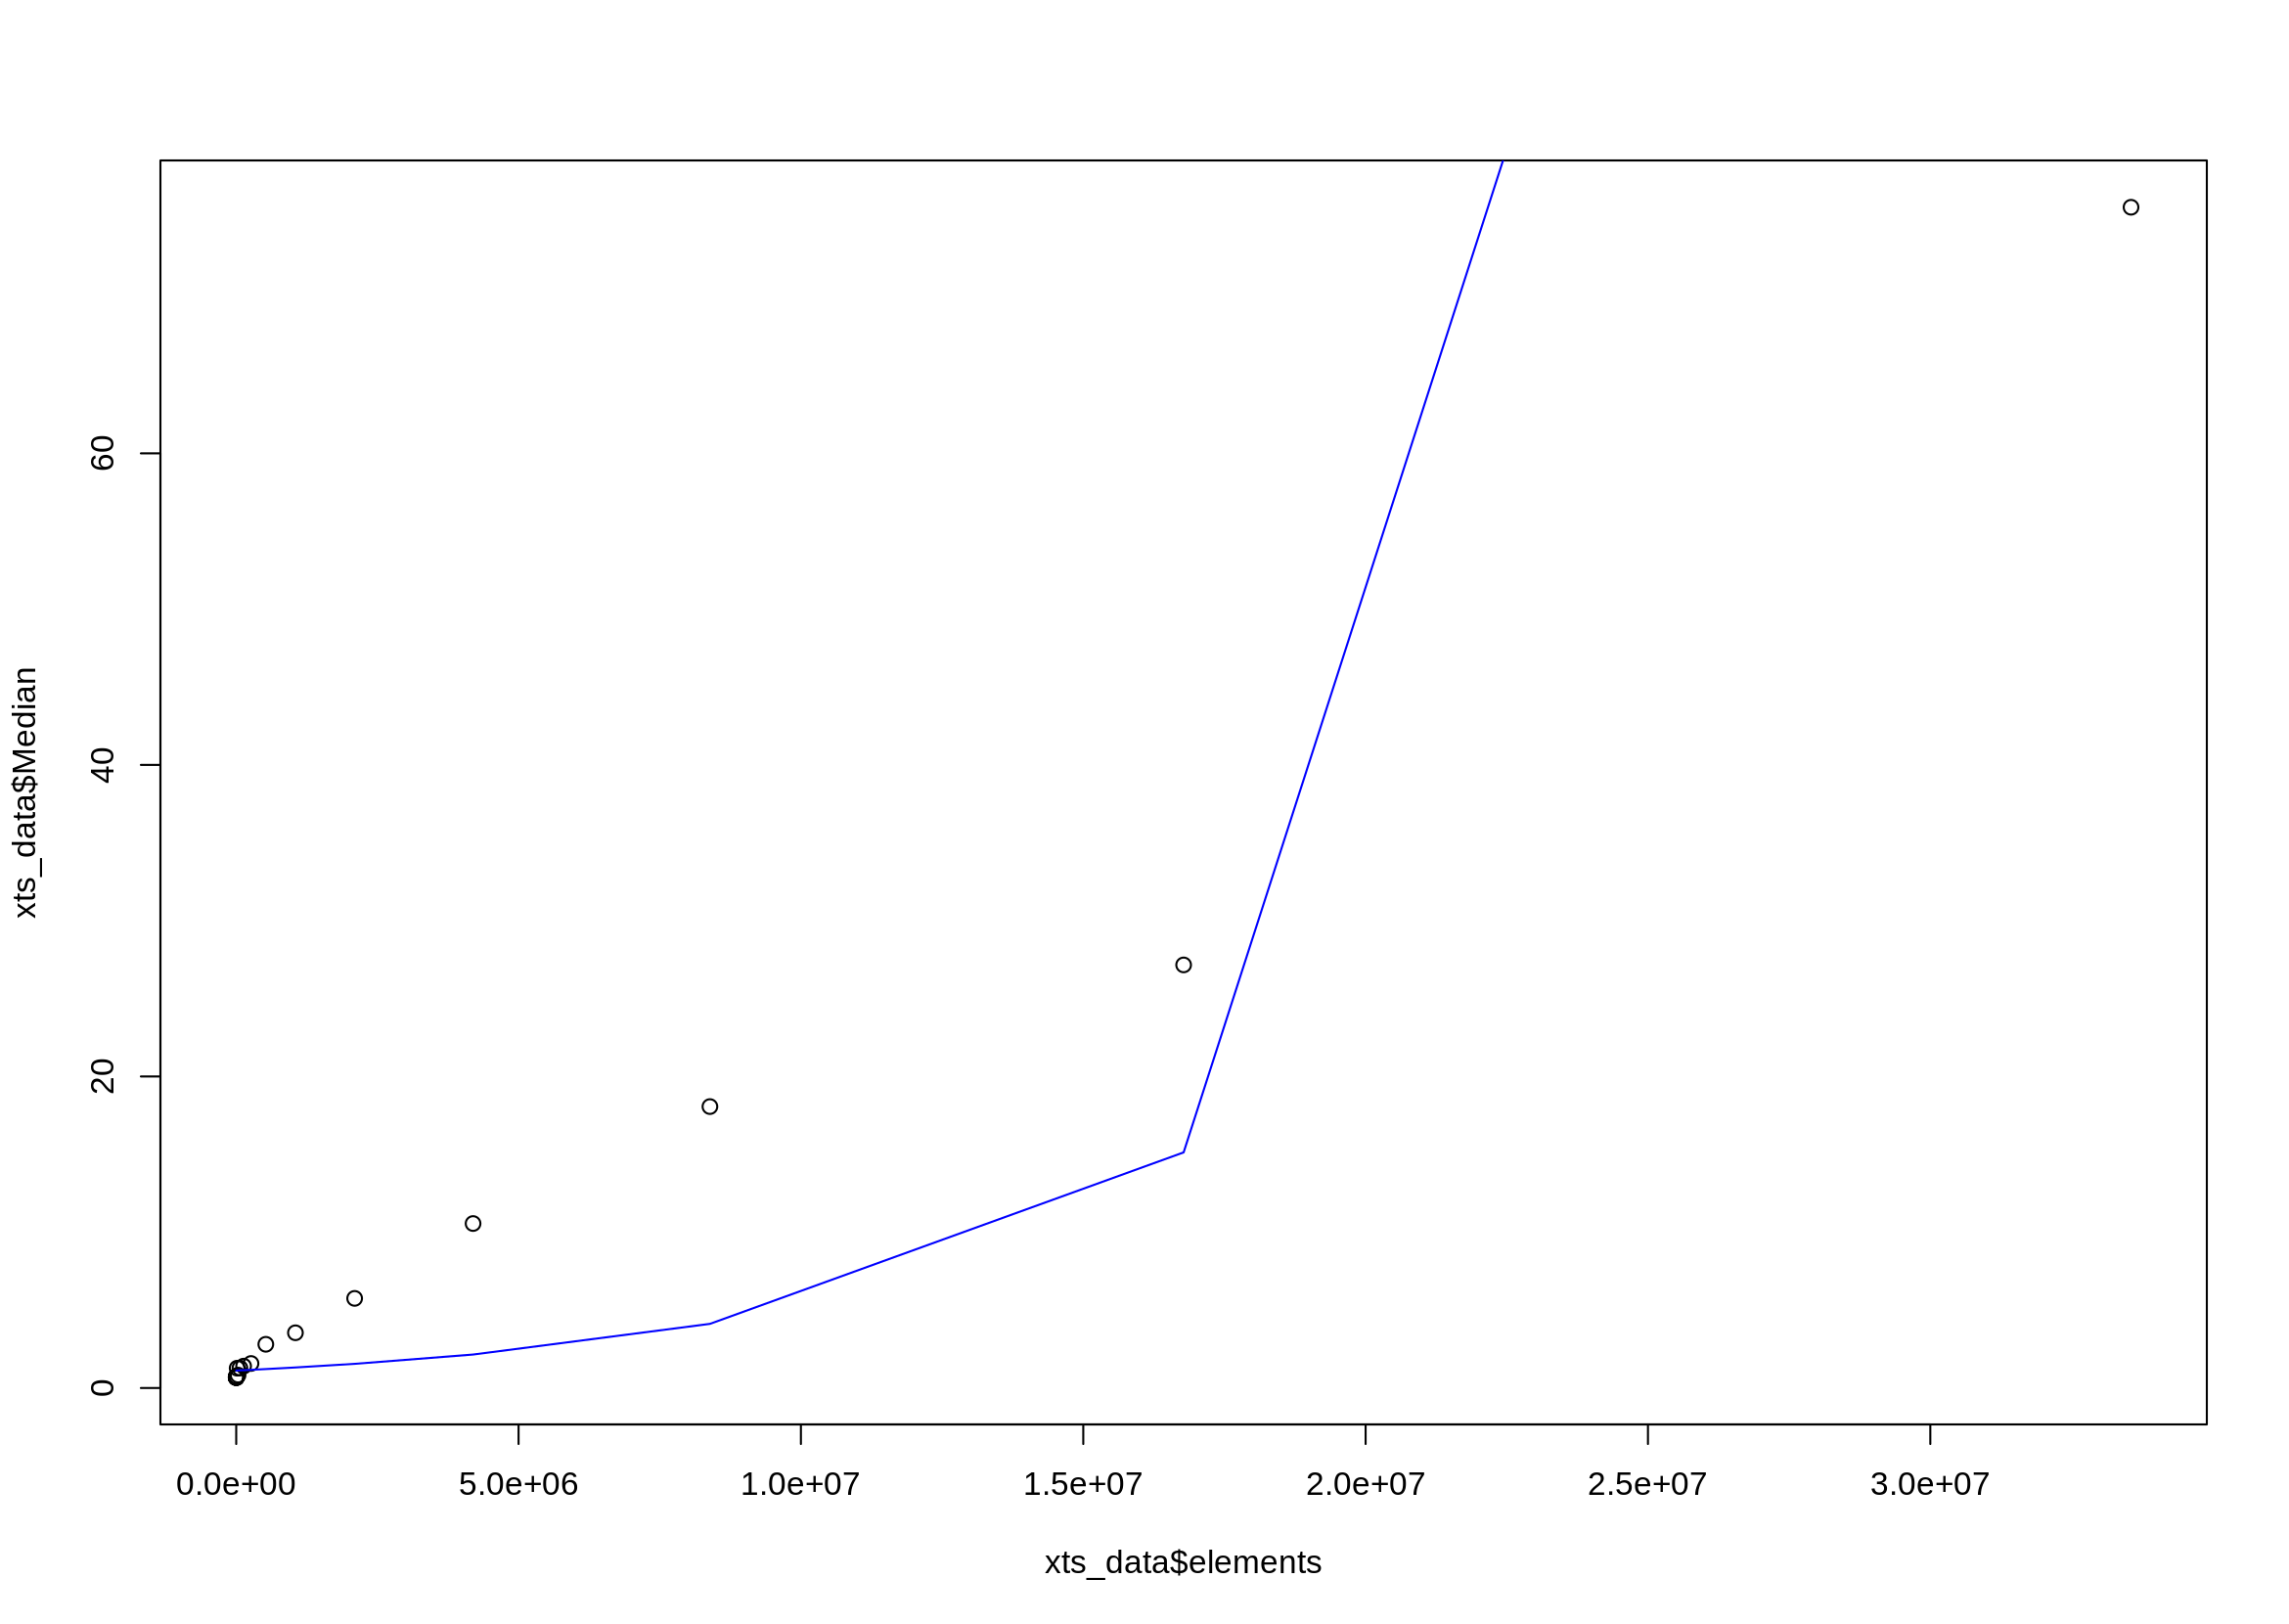

In [386]:
%%R -i model -i xts_data -h 8.3 -w 11.7 --units in -r 200

plot(xts_data$elements,xts_data$Median)
lines(xts_data$elements,exp(fitted(model)),col="blue")

What about with a generalize linear mixed model?

## GLM -- Fit with a Gaussian Distribution


Call:
glm(formula = ms ~ elements, family = gaussian, data = extensive_transfer_size)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-16.903   -0.221   -0.158    0.404   55.644  

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 8.964e-01  2.913e-02   30.77   <2e-16 ***
elements    2.058e-06  3.759e-09  547.53   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for gaussian family taken to be 18.67058)

    Null deviance: 6064068  on 24999  degrees of freedom
Residual deviance:  466727  on 24998  degrees of freedom
AIC: 144125

Number of Fisher Scoring iterations: 2

Elements:  2 	Predicted:  0.896428308468374 	Measured:  0.689864 	Difference:  0.206564308468374 	Relative Difference 23 %
Elements:  4 	Predicted:  0.896432425273128 	Measured:  0.7344485 	Difference:  0.161983925273128 	Relative Difference 18 %
Elements:  8 	Predicted:  0.896440658882635 	Measured:  0.670433 	Differenc

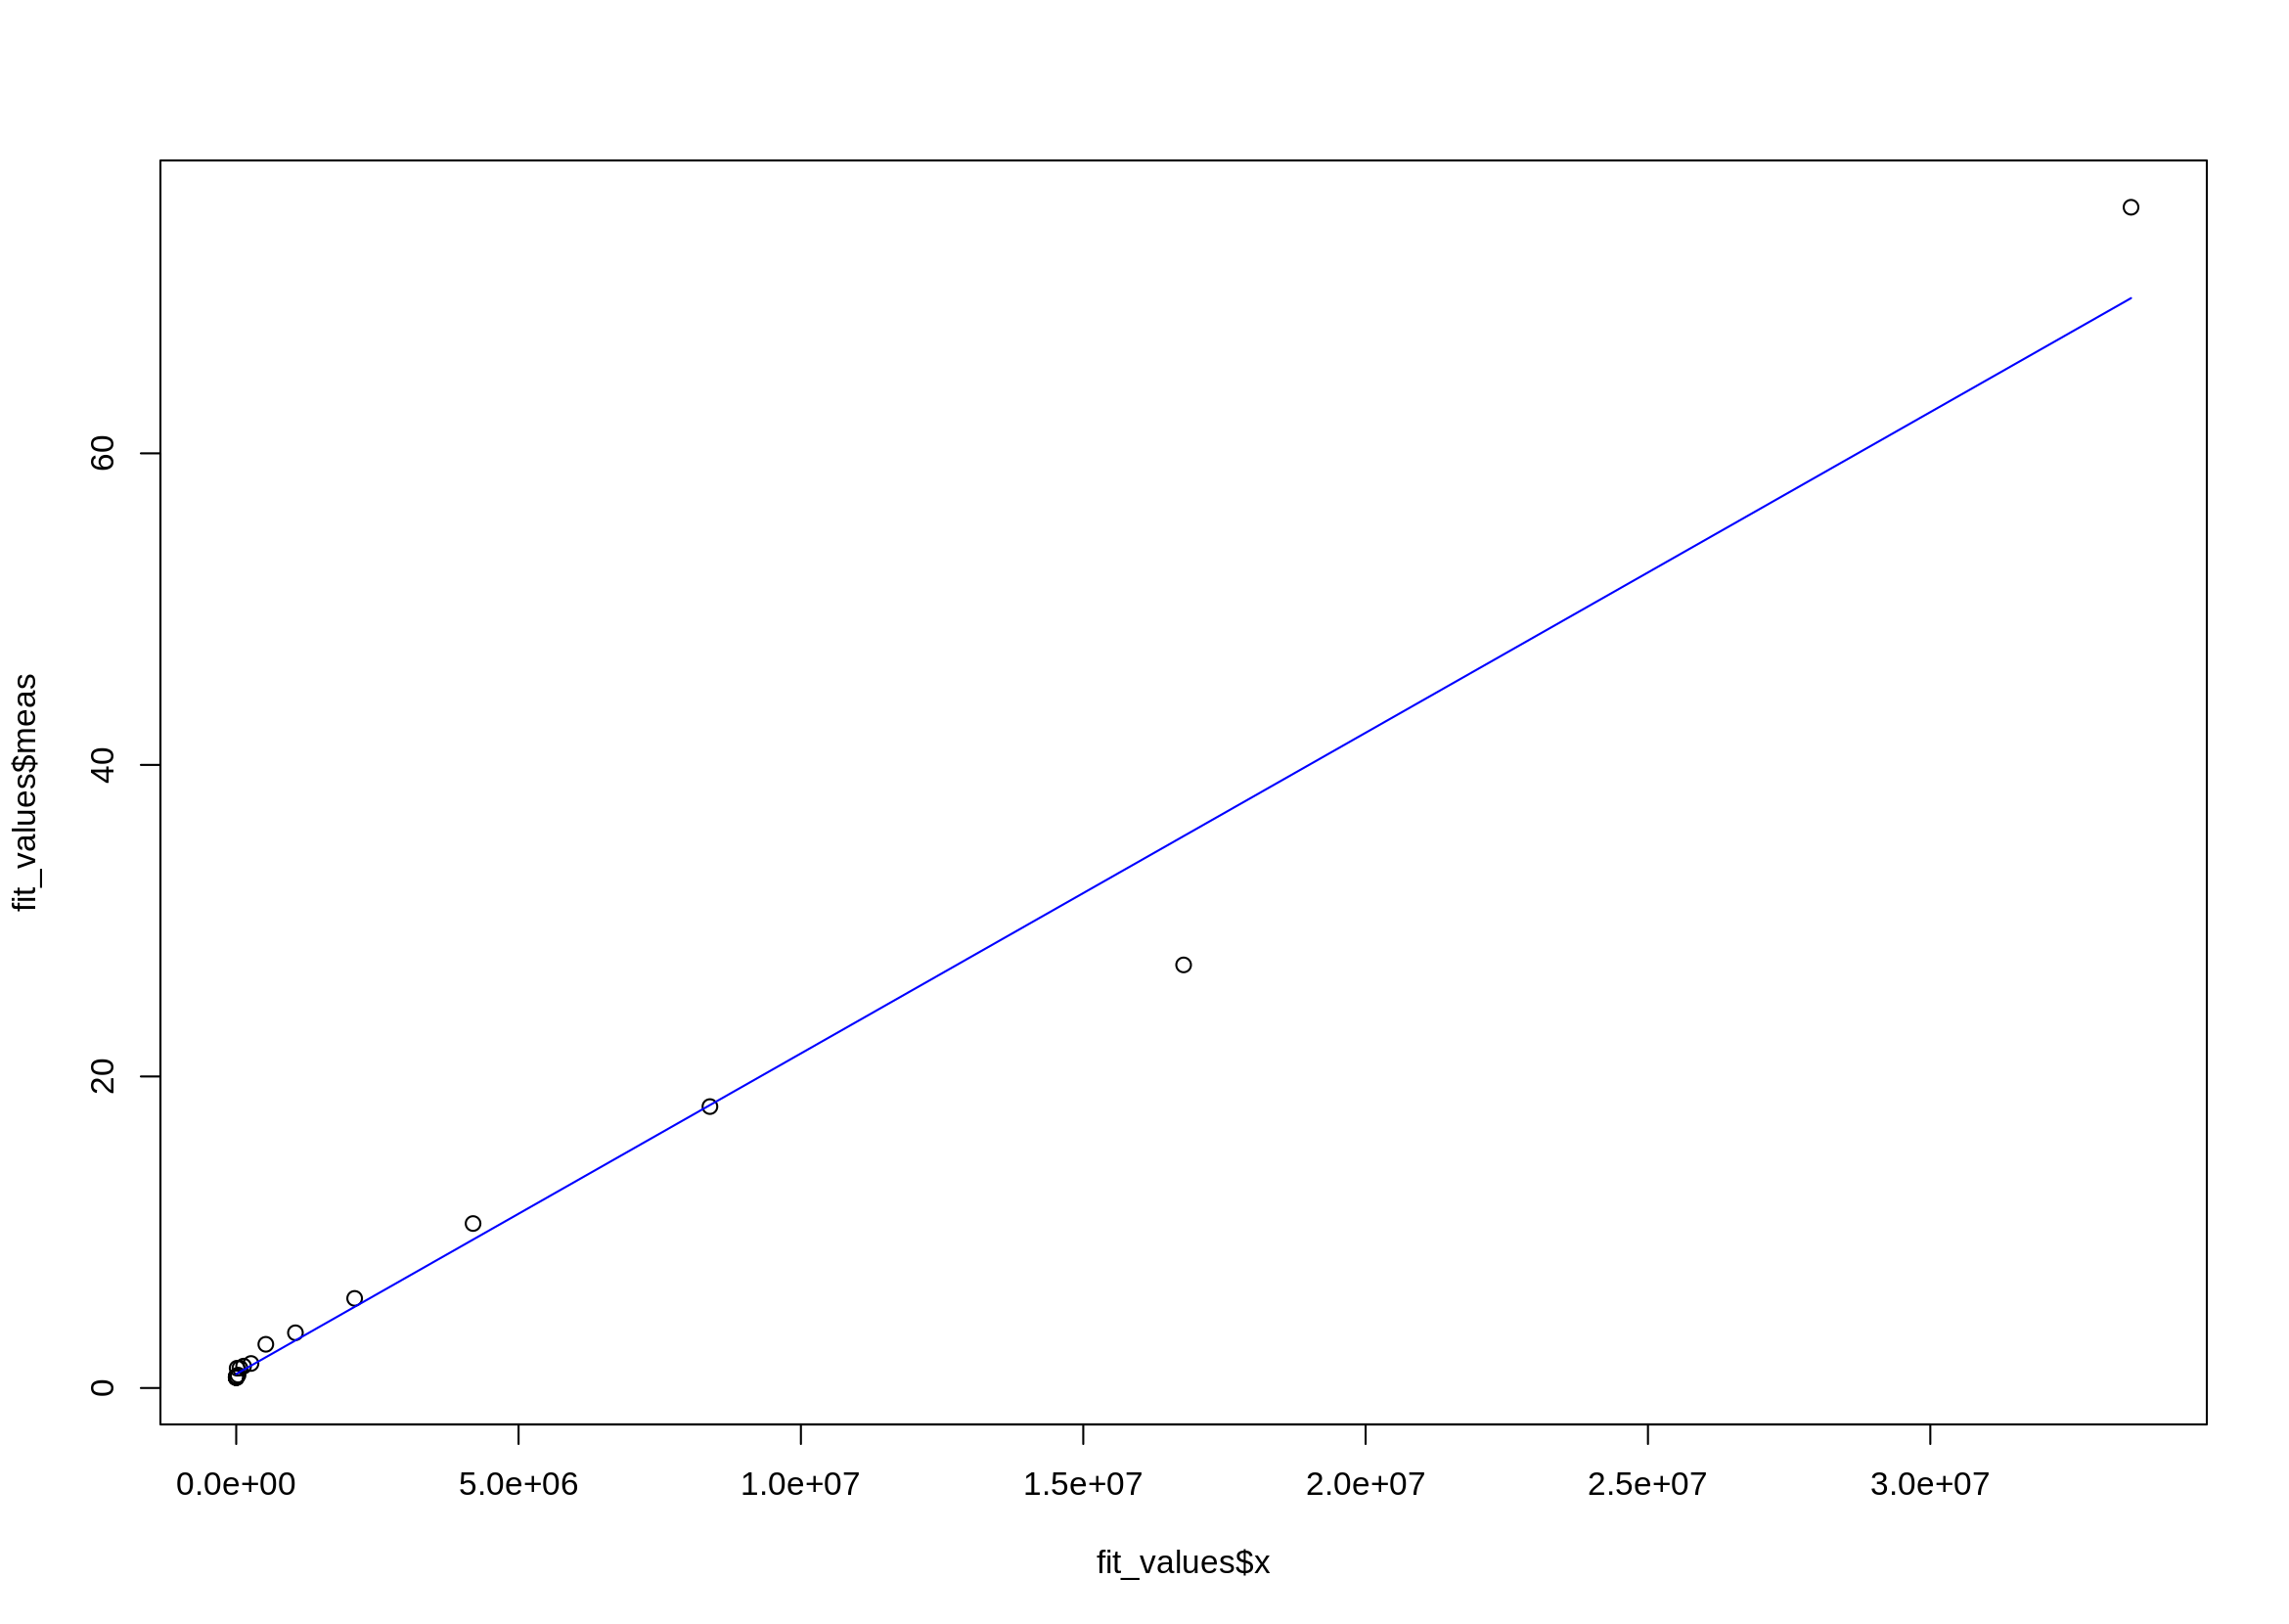

In [387]:
%%R -i extensive_transfer_size -i xts_data -h 8.3 -w 11.7 --units in -r 200

extensive_transfer_size$system <- factor(extensive_transfer_size$system, levels = c("Oswald", "Equinox", "Leconte", "Radeon", "Explorer"))
extensive_transfer_size$elements <- as.integer(extensive_transfer_size$elements)

#print(extensive_transfer_size)
#model <- glm(log(ms) ~ elements + system + version,data=extensive_transfer_size)
model <- glm(ms ~ elements,data=extensive_transfer_size,family=gaussian)
print(summary(model))

#new data frames from plots
fit_values <- data.frame()

for(x in unique(xts_data$elements)){
    tmp <- data.frame(elements = x, system = "Leconte", version = "cuda")
    p <- predict(model,newdata=tmp,se.fit = FALSE,terms="ms",type="response")
    #p <- exp(p)
    m <- xts_data[xts_data$elements == x,]$Median
    r <- round(abs(p-m)/max(p,m),2)*100
    cat(paste("Elements: ", x, "\tPredicted: ", p, "\tMeasured: ", m, "\tDifference: ", abs(p-m), "\tRelative Difference", r, "%\n"))
    
    fit_values <- rbind(fit_values,data.frame(x=x,pred=p,meas=m,relative_difference=r))
}

plot(fit_values$x,fit_values$meas)
lines(fit_values$x,fit_values$pred,col="blue")

coef(model)

paste("Mean Relative Difference = ",mean(fit_values$relative_difference),"%")

## GLM -- Fit with a (Quasi)Poisson Distribution


Call:
glm(formula = ms ~ elements, family = quasipoisson(link = "identity"), 
    data = extensive_transfer_size)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0826  -0.2637  -0.1909   0.2848   6.0104  

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 9.185e-01  4.847e-03   189.5   <2e-16 ***
elements    2.050e-06  3.865e-09   530.4   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for quasipoisson family taken to be 0.4589471)

    Null deviance: 426811  on 24999  degrees of freedom
Residual deviance:  10108  on 24998  degrees of freedom
AIC: NA

Number of Fisher Scoring iterations: 4

Elements:  2 	Predicted:  0.918509398104565 	Measured:  0.689864 	Difference:  0.228645398104565 	Relative Difference 25 %
Elements:  4 	Predicted:  0.918513498457612 	Measured:  0.7344485 	Difference:  0.184064998457612 	Relative Difference 20 %
Elements:  8 	Predicted:  0.918521699163706 	Mea

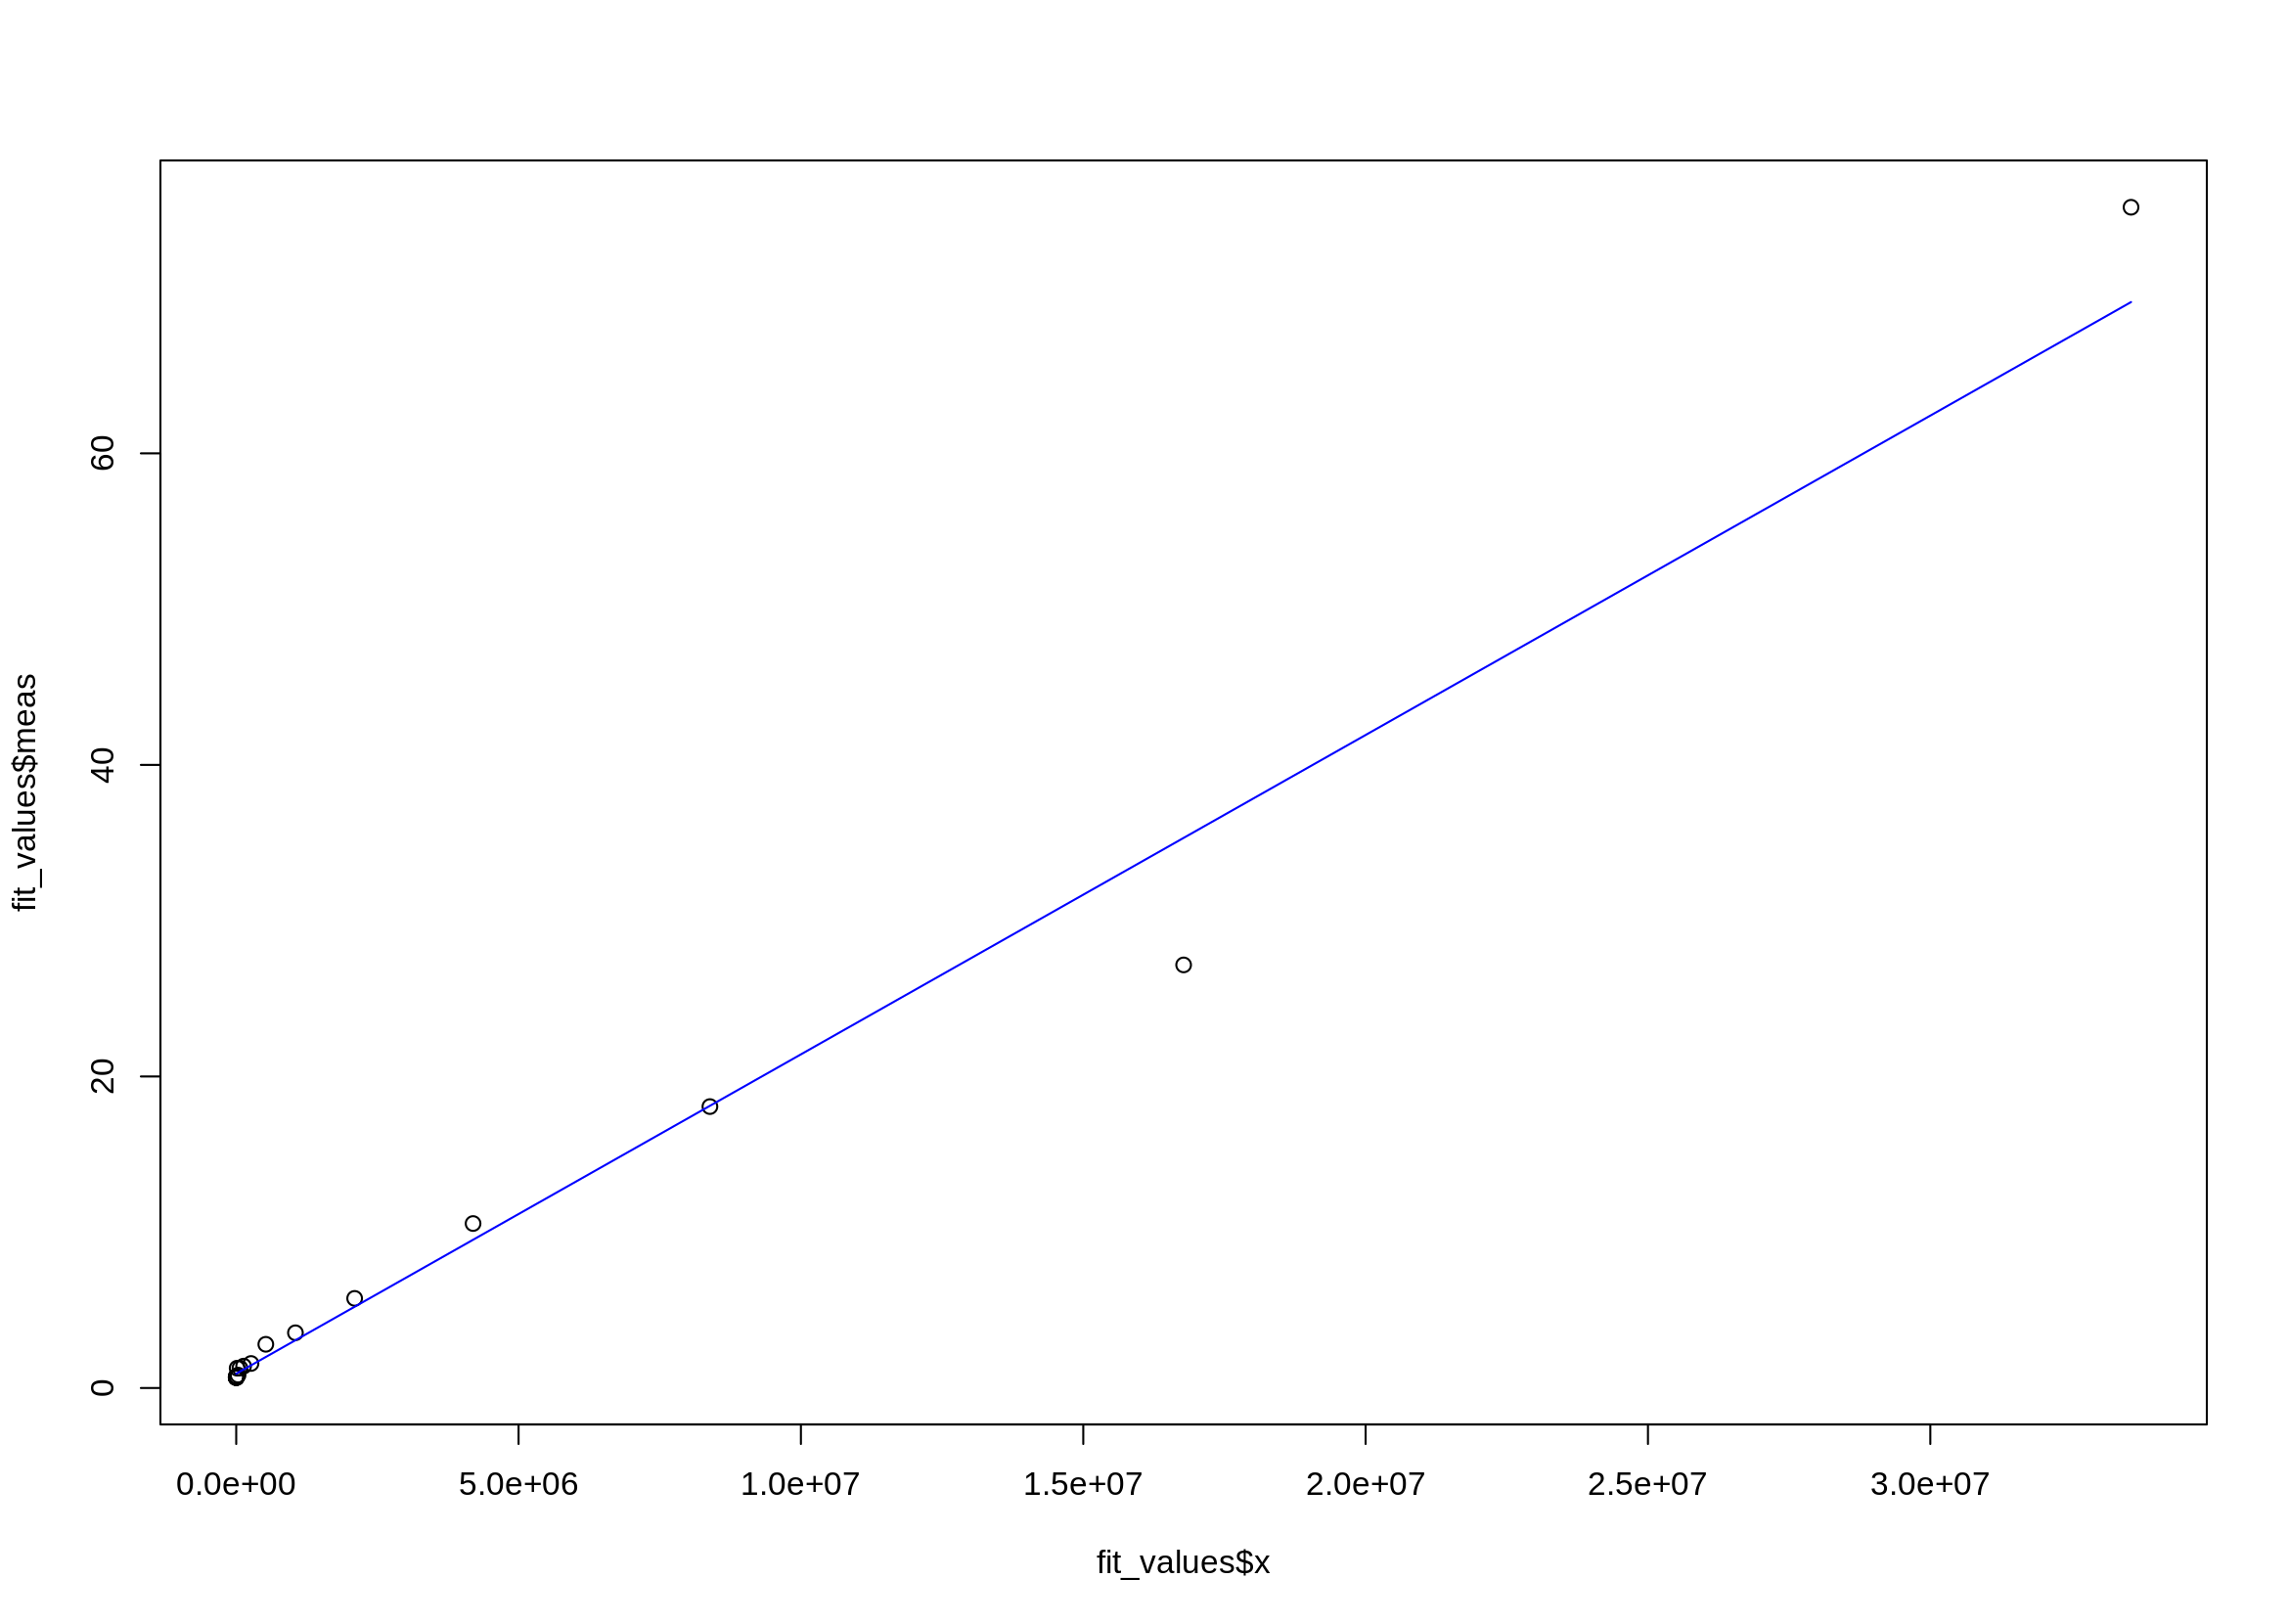

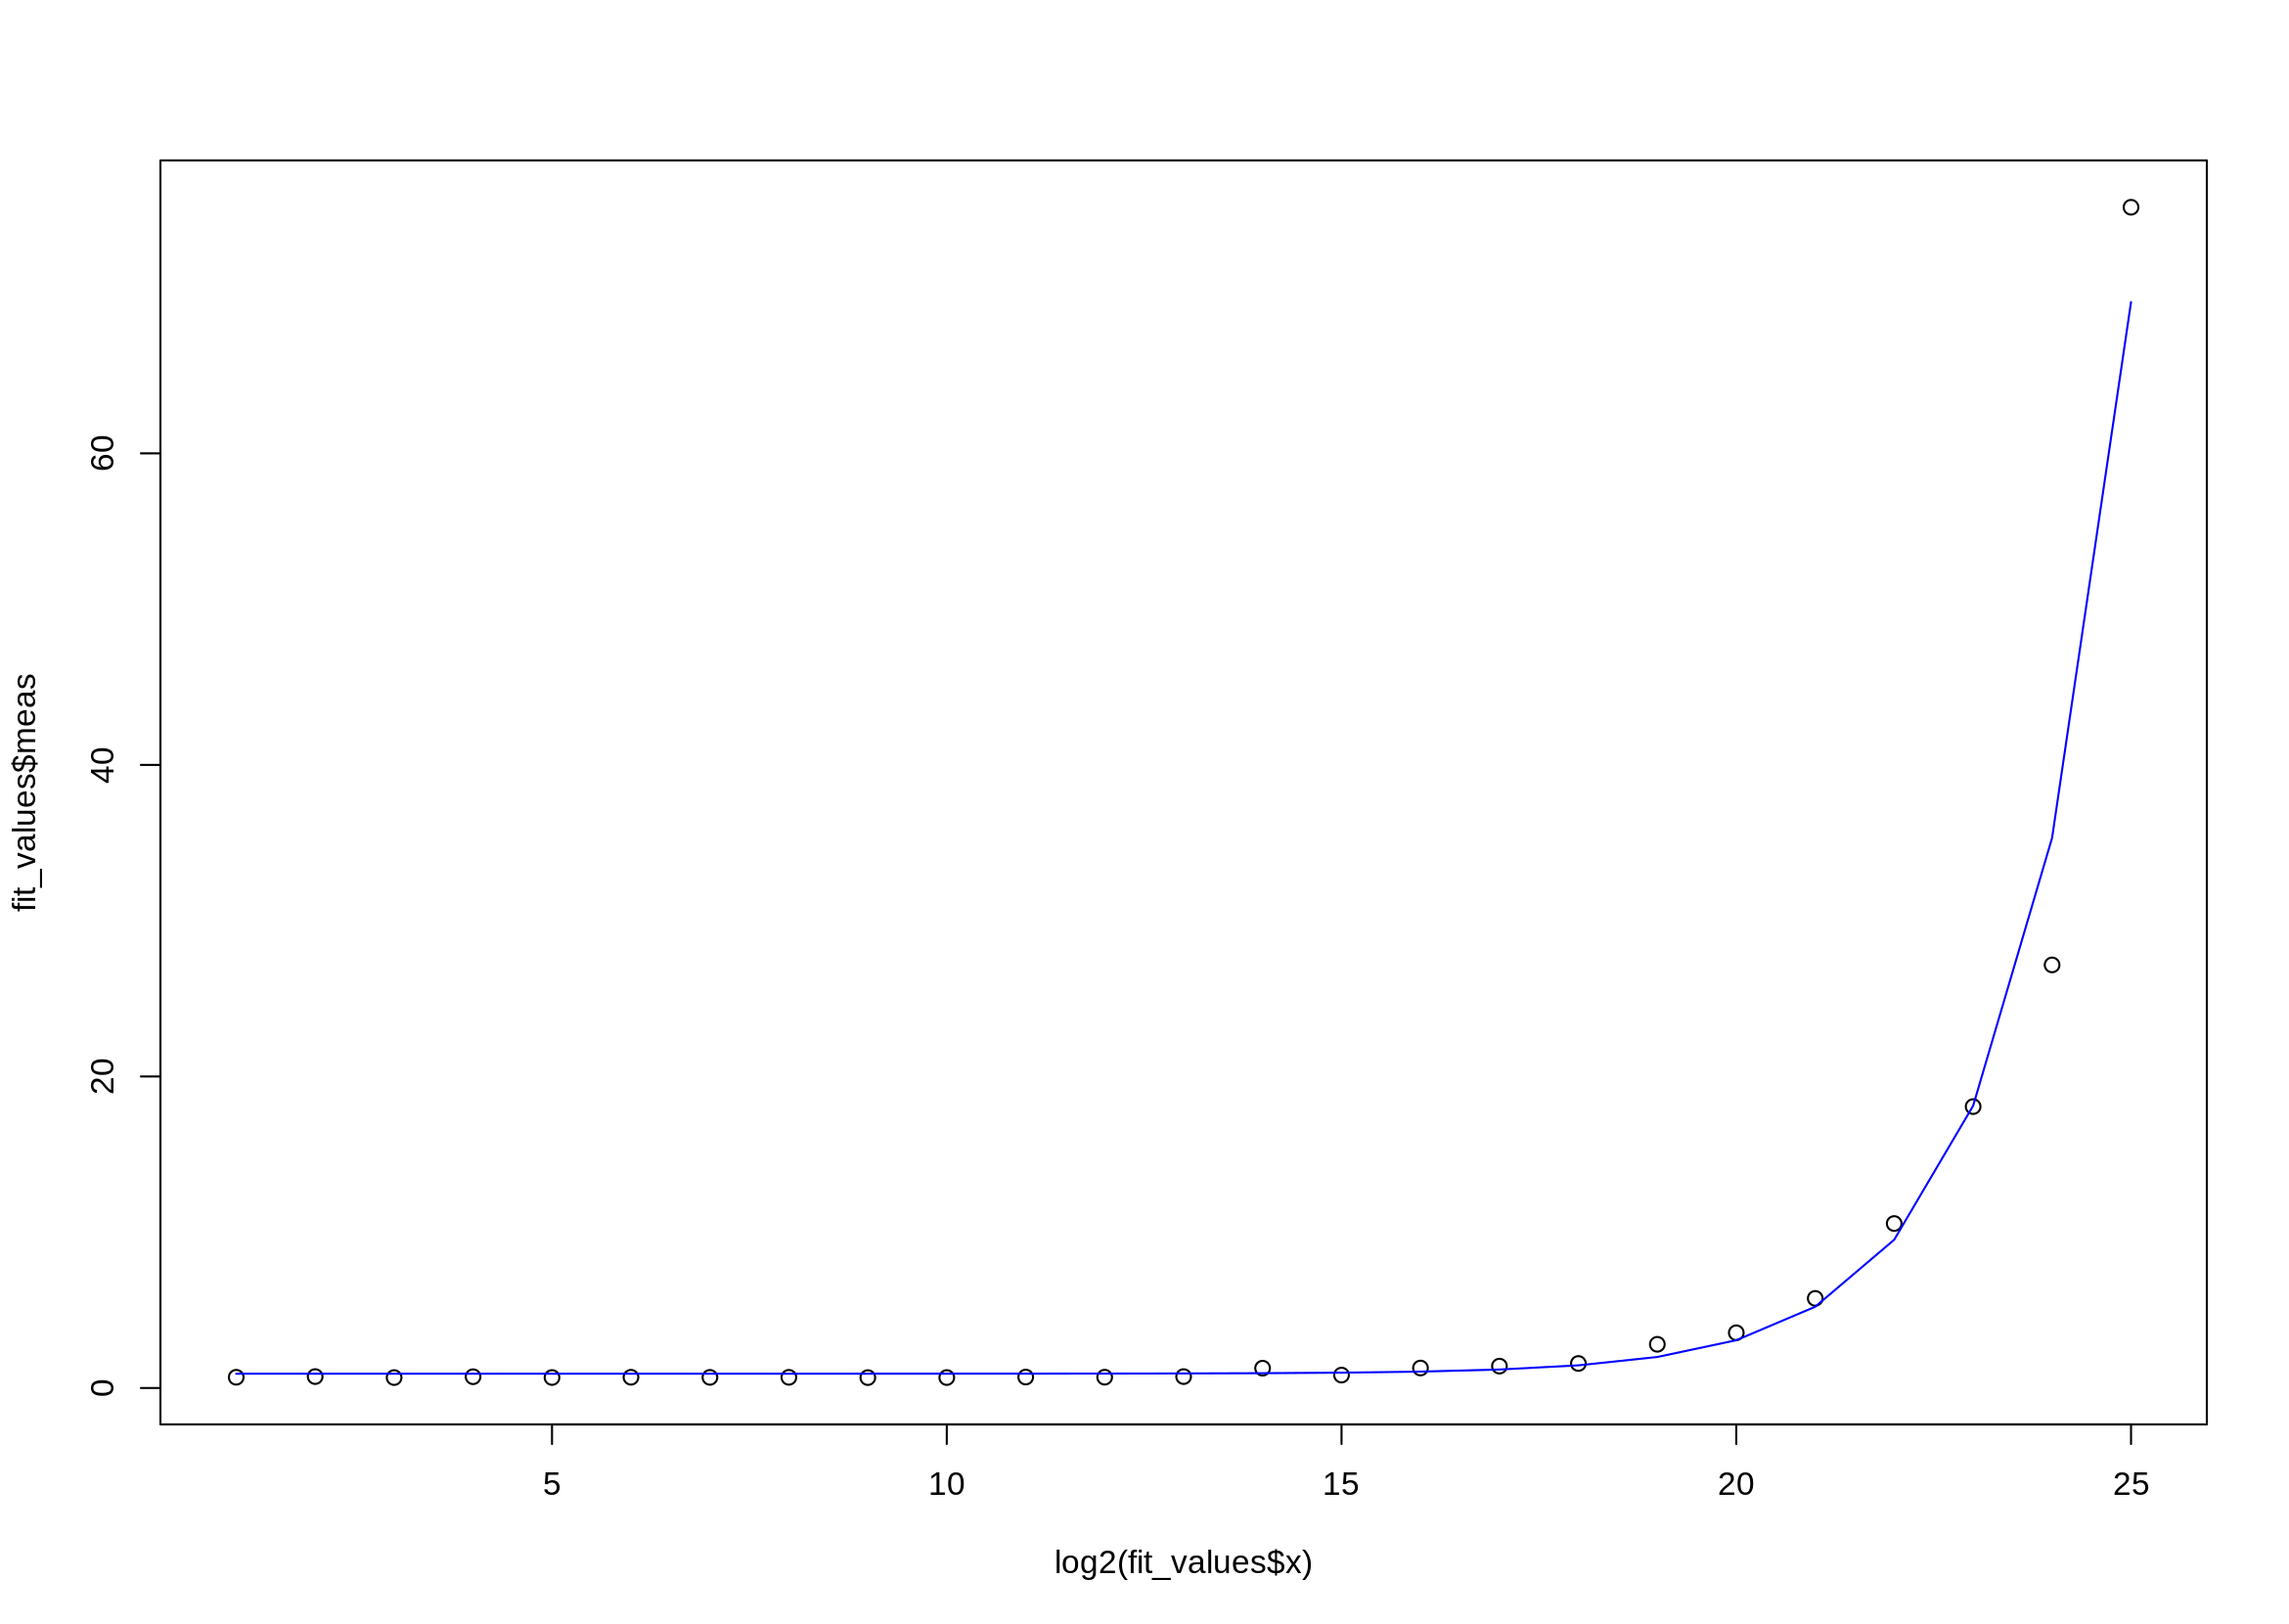

In [388]:
%%R -i extensive_transfer_size -i xts_data -h 8.3 -w 11.7 --units in -r 200

extensive_transfer_size$system <- factor(extensive_transfer_size$system, levels = c("Oswald", "Equinox", "Leconte", "Radeon", "Explorer"))
extensive_transfer_size$elements <- as.integer(extensive_transfer_size$elements)

#print(extensive_transfer_size)
#model <- glm(log(ms) ~ elements + system + version,data=extensive_transfer_size)
model <- glm(ms ~ elements,data=extensive_transfer_size,family=quasipoisson(link = "identity"))
print(summary(model))

fit_values <- data.frame()

for(x in unique(xts_data$elements)){
    tmp <- data.frame(elements = x, system = "Leconte", version = "cuda")
    p <- predict(model,newdata=tmp,se.fit = FALSE,terms="ms",type="response")
    # <- exp(p)
    m <- xts_data[xts_data$elements == x,]$Median
    r <- round(abs(p-m)/max(p,m),2)*100
    cat(paste("Elements: ", x, "\tPredicted: ", p, "\tMeasured: ", m, "\tDifference: ", abs(p-m), "\tRelative Difference", r, "%\n"))
    
    fit_values <- rbind(fit_values,data.frame(x=x,pred=p,meas=m,relative_difference=r))
}

plot(fit_values$x,fit_values$meas)
lines(fit_values$x,fit_values$pred,col="blue")

plot(log2(fit_values$x),fit_values$meas)
lines(log2(fit_values$x),fit_values$pred,col="blue")

coef(model)

paste("Mean Relative Difference = ",mean(fit_values$relative_difference),"%")

## Extracting Terms

We can directly apply this model to our predictions by extracting and testing the linear terms from the model (`coef(model)`).

In [389]:
%%R -i model -i xts_data

pred <- function(x){
    #return(6.830503e-01 + 1.884382e-06*x)
    return(3.295 + 1.976e-06*x)
}

#for each x position in the number of elements see the difference between the models prediction and the measured
for(x in unique(xts_data$elements)){
    p <- pred(x)
    m <- xts_data[xts_data$elements == x,]$Median
    cat(paste("Elements: ", x, "\tPredicted: ", p, "\tMeasured: ", m, "\tDifference: ", abs(p-m), "\tRelative Difference", round(abs(p-m)/max(p,m),2)*100, "%\n"))
}

pred(2**30)


Elements:  2 	Predicted:  3.295003952 	Measured:  0.689864 	Difference:  2.605139952 	Relative Difference 79 %
Elements:  4 	Predicted:  3.295007904 	Measured:  0.7344485 	Difference:  2.560559404 	Relative Difference 78 %
Elements:  8 	Predicted:  3.295015808 	Measured:  0.670433 	Difference:  2.624582808 	Relative Difference 80 %
Elements:  16 	Predicted:  3.295031616 	Measured:  0.7250305 	Difference:  2.570001116 	Relative Difference 78 %
Elements:  32 	Predicted:  3.295063232 	Measured:  0.674486 	Difference:  2.620577232 	Relative Difference 80 %
Elements:  64 	Predicted:  3.295126464 	Measured:  0.690222 	Difference:  2.604904464 	Relative Difference 79 %
Elements:  128 	Predicted:  3.295252928 	Measured:  0.6827115 	Difference:  2.612541428 	Relative Difference 79 %
Elements:  256 	Predicted:  3.295505856 	Measured:  0.6860495 	Difference:  2.609456356 	Relative Difference 79 %
Elements:  512 	Predicted:  3.296011712 	Measured:  0.668049 	Difference:  2.627962712 	Relative Diff

The next question is how general is the formula between hardware (and native language/runtime) or does this mostly just predict the PCI-E transfer cost---the latter is optimal since it gives a rough figure usable in IRIS without being too sensitive.

## Same predict values (fitted on Leconte applied to Explorer)

`summarise()` has grouped output by 'system', 'version'. You can override using the `.groups` argument.
Elements:  2 	Predicted:  3.295003952 	Measured:  0.242591 	Difference:  3.052412952 	Relative Difference 93 %
Elements:  4 	Predicted:  3.295007904 	Measured:  0.2640485 	Difference:  3.030959404 	Relative Difference 92 %
Elements:  8 	Predicted:  3.295015808 	Measured:  0.239134 	Difference:  3.055881808 	Relative Difference 93 %
Elements:  16 	Predicted:  3.295031616 	Measured:  0.234365 	Difference:  3.060666616 	Relative Difference 93 %
Elements:  32 	Predicted:  3.295063232 	Measured:  0.241518 	Difference:  3.053545232 	Relative Difference 93 %
Elements:  64 	Predicted:  3.295126464 	Measured:  0.22316 	Difference:  3.071966464 	Relative Difference 93 %
Elements:  128 	Predicted:  3.295252928 	Measured:  0.248671 	Difference:  3.046581928 	Relative Difference 92 %
Elements:  256 	Predicted:  3.295505856 	Measured:  0.237107 	Difference:  3.058398856 	Relative Difference 93 %
E

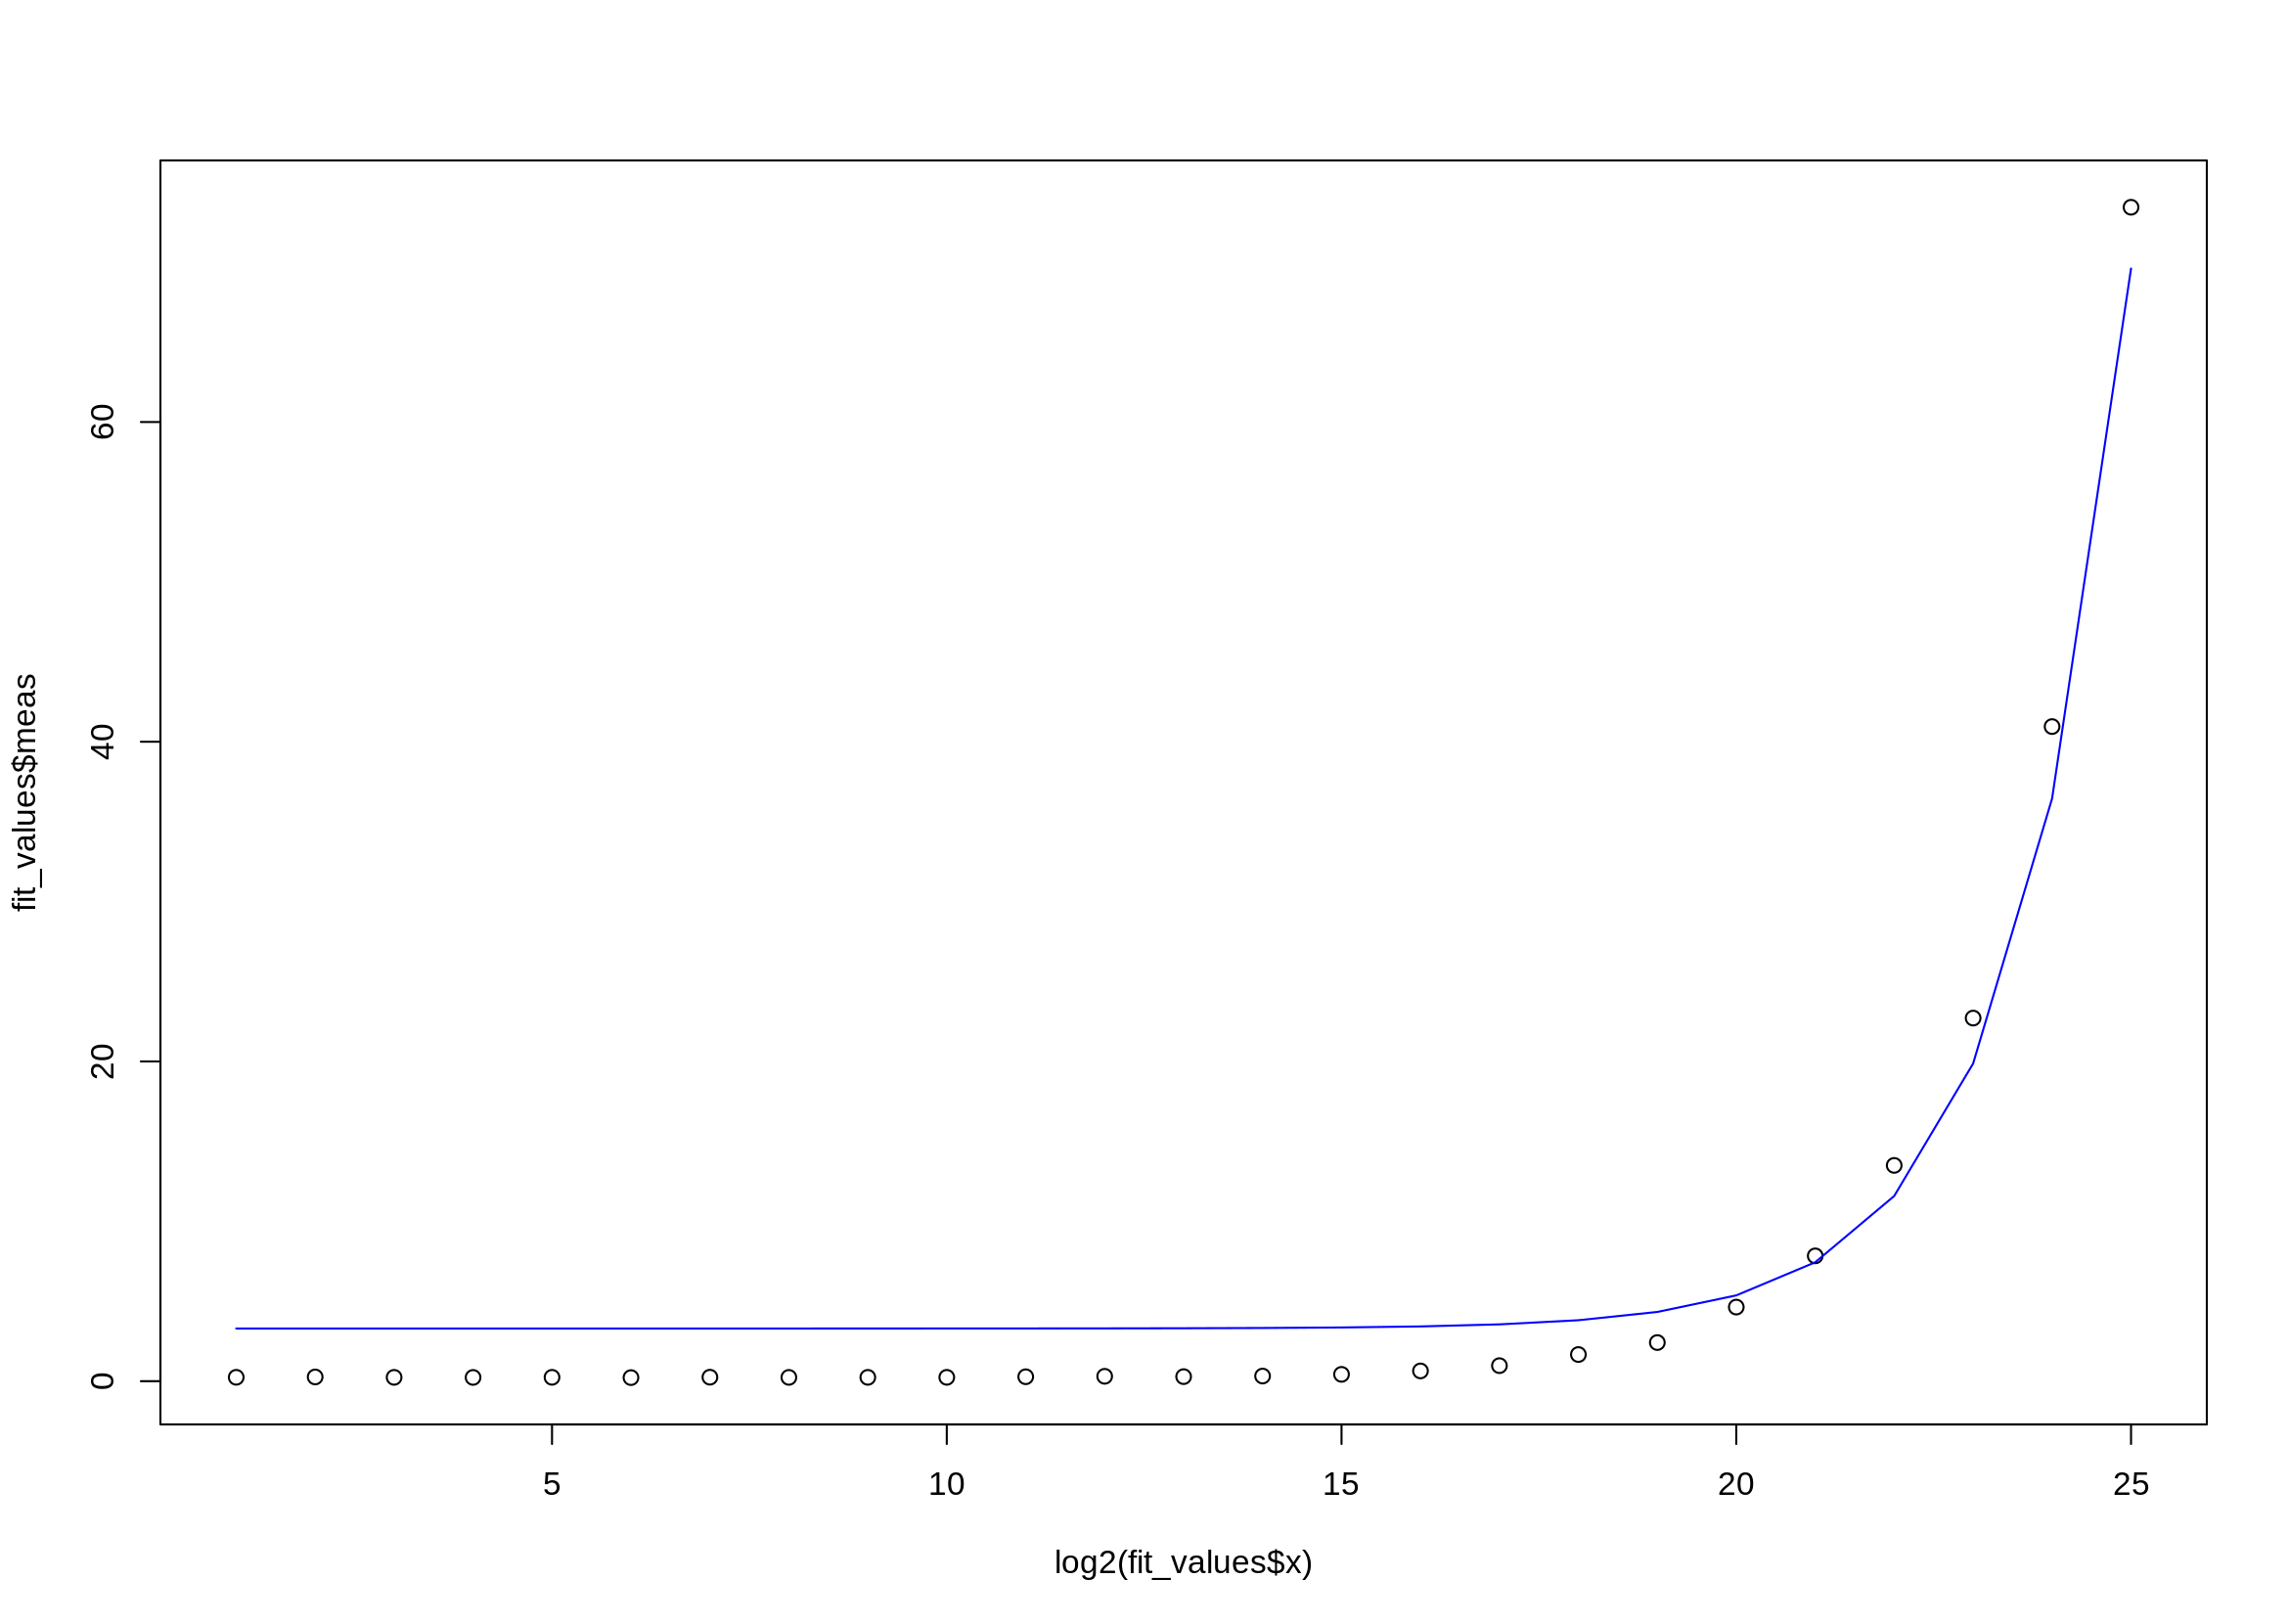

In [393]:
%%R -i full_transfer_size -h 8.3 -w 11.7 --units in -r 200

full_transfer_size$system <- factor(full_transfer_size$system, levels = c("Oswald", "Equinox", "Leconte", "Radeon", "Explorer"))
full_transfer_size$elements <- as.integer(full_transfer_size$elements)

explorer <- full_transfer_size[full_transfer_size$system == "Explorer",]

explorer%>%
group_by(system,  version, elements)%>%
summarise(Mean=mean(ms), Max=max(ms), Min=min(ms), Median=median(ms), Std=sd(ms)) %>%
{. ->> xpl }


fit_values <- data.frame()

#for each x position in the number of elements see the difference between the models prediction and the measured
for(x in unique(xpl$elements)){
    p <- pred(x)
    m <- xpl[xpl$elements == x,]$Median
    r <- round(abs(p-m)/max(p,m),2)*100
    cat(paste("Elements: ", x, "\tPredicted: ", p, "\tMeasured: ", m, "\tDifference: ", abs(p-m), "\tRelative Difference", r, "%\n"))
    
    fit_values <- rbind(fit_values,data.frame(x=x,pred=p,meas=m,relative_difference=r))
}

plot(log2(fit_values$x),fit_values$meas)
lines(log2(fit_values$x),fit_values$pred,col="blue")

paste("Mean Relative Difference = ",mean(fit_values$relative_difference),"%")

pred(2**30)

In [408]:
def predict(x):
    return(3.295 + 1.976e-06*x)

import pandas

with open('../membench/extensive-transfer-size-results/membench-hip-Explorer-1073741824.csv', encoding="utf-8") as file:
        content = [l.rstrip("\n") for l in file]
times = content[0].split(',')
times = [float(ele) for ele in times]
times = pandas.DataFrame(times)
explorer = times

with open('../membench/extensive-transfer-size-results/membench-cuda-Leconte-1073741824.csv', encoding="utf-8") as file:
        content = [l.rstrip("\n") for l in file]
times = content[0].split(',')
times = [float(ele) for ele in times]
times = pandas.DataFrame(times)
leconte = times

print("#Elements {}, Predicted {} ms, Measured on Leconte {} ms, Measured on Explorer {} ms".format(2**30,predict(2**30),leconte.median()[0],explorer.median()[0]))

print("Measured variance on Leconte {} ms, on Explorer {} ms".format(leconte.std()[0],explorer.std()[0]))

#Elements 1073741824, Predicted 2125.008844224 ms, Measured on Leconte 2741.145 ms, Measured on Explorer 2254.01 ms
Measured variance on Leconte 2310.4548552395872 ms, on Explorer 1241.4532049668971 ms


In [1]:
%%R -i full_transfer_size -h 8.3 -w 11.7 --units in -r 200

library('ggplot2')
library('latex2exp')
library("dplyr")

full_transfer_size$system <- factor(full_transfer_size$system, levels = c("Oswald", "Equinox", "Leconte", "Radeon", "Explorer"))
full_transfer_size$elements <- as.integer(full_transfer_size$elements)

myColours <- viridis_pal()(3)
myColours <- c(myColours[1], myColours[2], myColours[6]) 
colScale <- scale_colour_manual(name = "Backend",values = myColours)
colFill <- scale_fill_manual(name="Backend",values=myColours)
full_transfer_size$Backends <- toupper(full_transfer_size$version)
names(myColours) <- levels(full_transfer_size$Backends)

full_transfer_size%>%
group_by(system,  Backends, elements)%>%
summarise(Mean=mean(ms), Max=max(ms), Min=min(ms), Median=median(ms), Std=sd(ms)) %>%
{. ->> res }

res$Predicted <- pred(res$elements)
outlier_size = 0.5

p0 <- ggplot(res, aes(x=elements, y=Median, fill=Backends,colour=Backends, group=interaction(Backends)))
p0 <- p0 + theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 6)) + expand_limits(y = 0) + expand_limits(y = 0)
p0 <- p0 + scale_x_continuous(trans='log2',  breaks = trans_breaks("log2", function(x) 2^x, n = 12), labels = function(x) paste(x/1024,"KiB") )
p0 <- p0 + facet_wrap( ~ system, strip.position = "top", scales = "free_x")
p0 <- p0 + geom_ribbon(aes(ymin = Median-Std, ymax = Median+Std),alpha=0.1, linetype = 0)
p0 <- p0 + geom_line(aes(y = Median), alpha=1.0, size=0.75)
p0 <- p0 + geom_line(aes(y = Predicted),linetype="dotted",colour="black")
p0 <- p0 + colFill + colScale
p0 <- p0 + guides(fill   = guide_legend(override.aes = list(pattern = "none")))
p0 <- p0 + guides(pattern= guide_legend(override.aes = list(fill = "white")))
p0 <- p0 + labs(colour="Backends", pattern="Implementation", y="Transfer Time (ms)", x="Size of Memory Buffer")
p0 <- p0 + theme(legend.position = c(0.95, 0.10))
print(p0)

ggsave(filename="predicted-vs-measured-transfer-size-systems.pdf",path="./iris-and-dagger-paper/figures",width=8.3,height=11.7,units="in",dpi="retina")
                                                                   
                                                                   
p0 <- ggplot(res, aes(x=elements, y=Median, fill=Backends,colour=Backends, group=interaction(Backends)))
p0 <- p0 + theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 6)) + expand_limits(y = 0) + expand_limits(y = 0)
p0 <- p0 + scale_x_continuous(trans='log2',  breaks = trans_breaks("log2", function(x) 2^x, n = 12), labels = function(x) paste(x/1024,"KiB") )
p0 <- p0 + geom_ribbon(aes(ymin = Median-Std, ymax = Median+Std),alpha=0.1, linetype = 0)
p0 <- p0 + geom_line(aes(y = Median), alpha=1.0, size=0.75)
p0 <- p0 + geom_line(aes(y = Predicted),linetype="dotted",colour="black")
p0 <- p0 + colFill + colScale
p0 <- p0 + guides(fill   = guide_legend(override.aes = list(pattern = "none")))
p0 <- p0 + guides(pattern= guide_legend(override.aes = list(fill = "white")))
p0 <- p0 + labs(colour="Backends", pattern="Implementation", y="Transfer Time (ms)", x="Size of Memory Buffer")
p0 <- p0 + theme(legend.position = c(0.95, 0.10))
print(p0)

ggsave(filename="predicted-vs-measured-transfer-size.pdf",path="./iris-and-dagger-paper/figures",width=8.3,height=11.7,units="in",dpi="retina")

UsageError: Cell magic `%%R` not found.


# Membench Figure:

In [1]:
import glob
application_files = glob.glob("../membench/extensive-transfer-size-results/*.csv")

#discard the csv files where are the timeline of task and device it was run, instead we only consider the aggregate summation time logs.
application_files =  [i for i in application_files if i.count('-') == 6]

import pandas
df = None

for af in application_files:
    names = af.replace(".csv","")
    names = names.replace('../membench/extensive-transfer-size-results/',"")
    params = names.split("-")
    params.pop(0)
    elements = params.pop()
    system = params.pop()
    version = params.pop()
    with open(af, encoding="utf-8") as file:
        content = [l.rstrip("\n") for l in file]
    times = content[0].split(',')
    times = [float(ele) for ele in times]
    ndf = pandas.DataFrame({'ms':times,'system':system,'version':version,"elements":elements,'KiB':(int(elements)*4)/1024})
    if df is None:
        df = ndf
    else:
        df = pandas.merge(df,ndf,how='outer')

print(df)
full_transfer_size = df
#extensive_transfer_size = df[df['system'] == "Leconte"]

           ms    system version  elements            KiB
0     649.224  Explorer     hip      8192      32.000000
1     635.039  Explorer     hip        16       0.062500
2     635.531  Explorer     hip         8       0.031250
3   22672.300   Leconte    cuda  33554432  131072.000000
4     251.117   Leconte    cuda        32       0.125000
5    1421.240  Explorer     hip    524288    2048.000000
6     168.351   Leconte    cuda         2       0.007812
7    6404.890   Leconte    cuda   8388608   32768.000000
8     822.310  Explorer     hip    131072     512.000000
9     281.492   Leconte    cuda      1024       4.000000
10    631.016  Explorer     hip       256       1.000000
11    107.785   Leconte    cuda        16       0.062500
12    639.638  Explorer     hip      2048       8.000000
13   5967.420  Explorer     hip   4194304   16384.000000
14    638.505  Explorer     hip       512       2.000000
15    659.441  Explorer     hip     16384      64.000000
16    315.497   Leconte    cuda

`summarise()` has grouped output by 'system', 'Backends', 'elements'. You can override using the `.groups` argument.


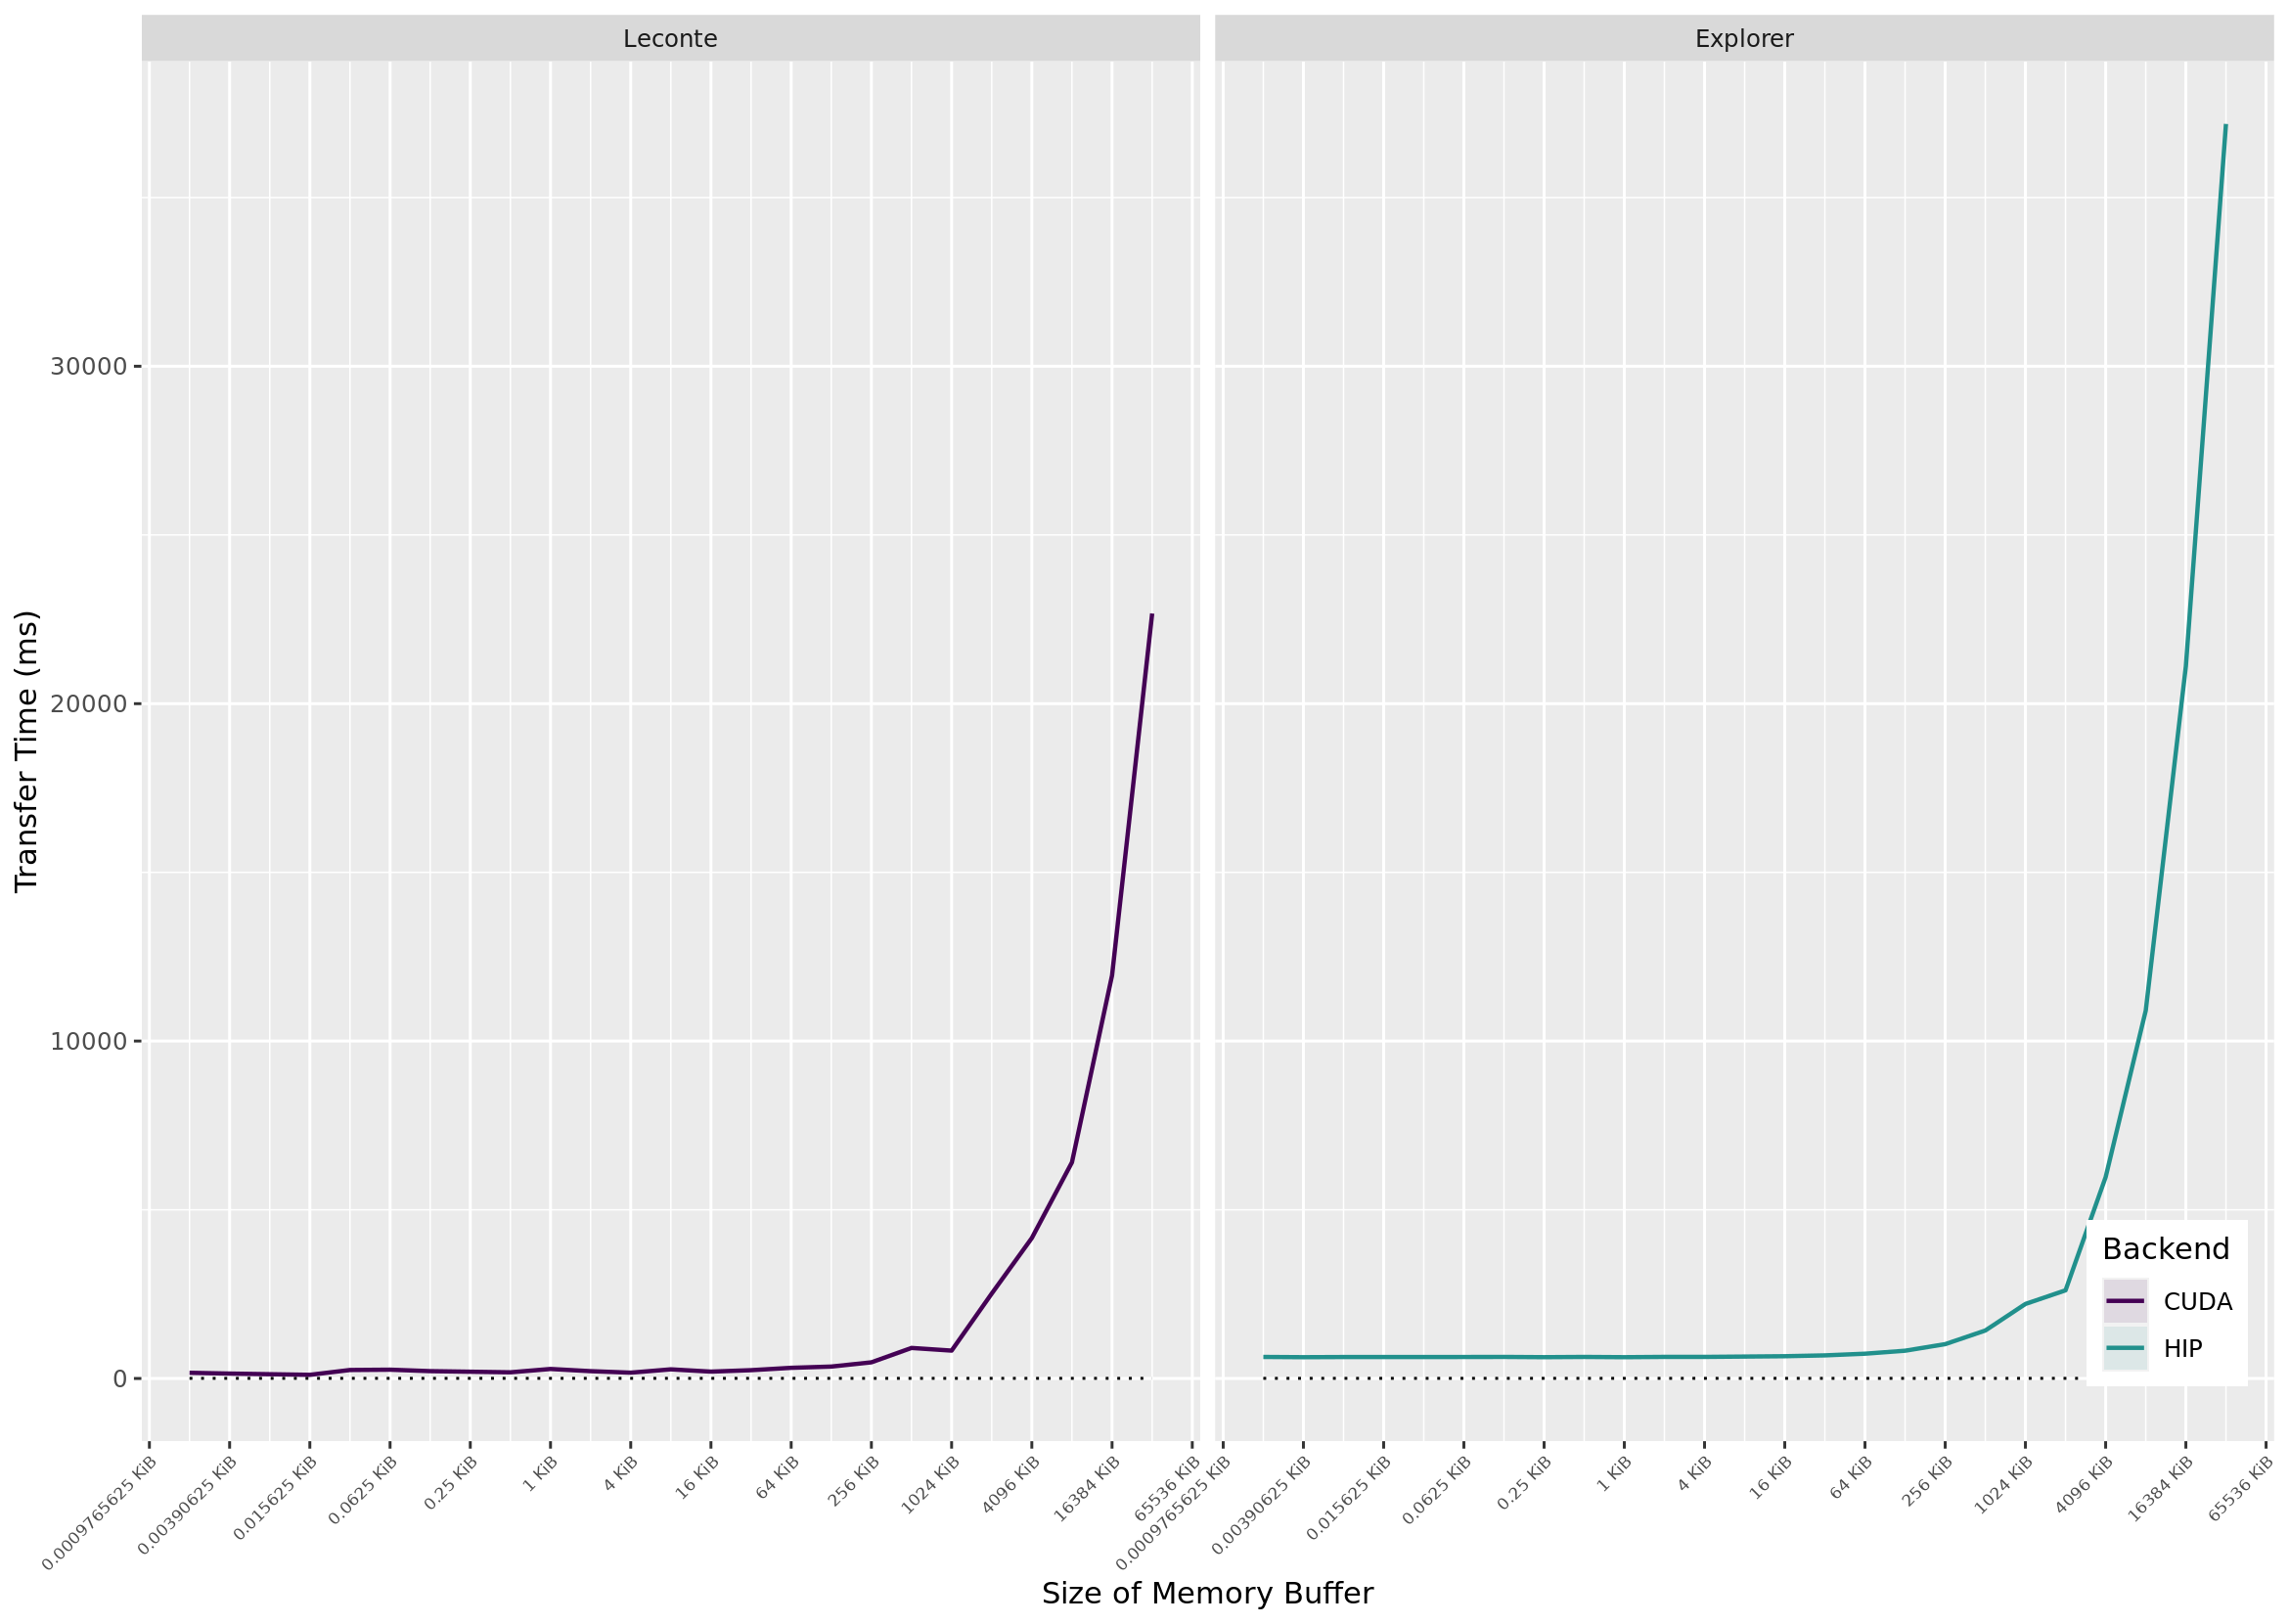

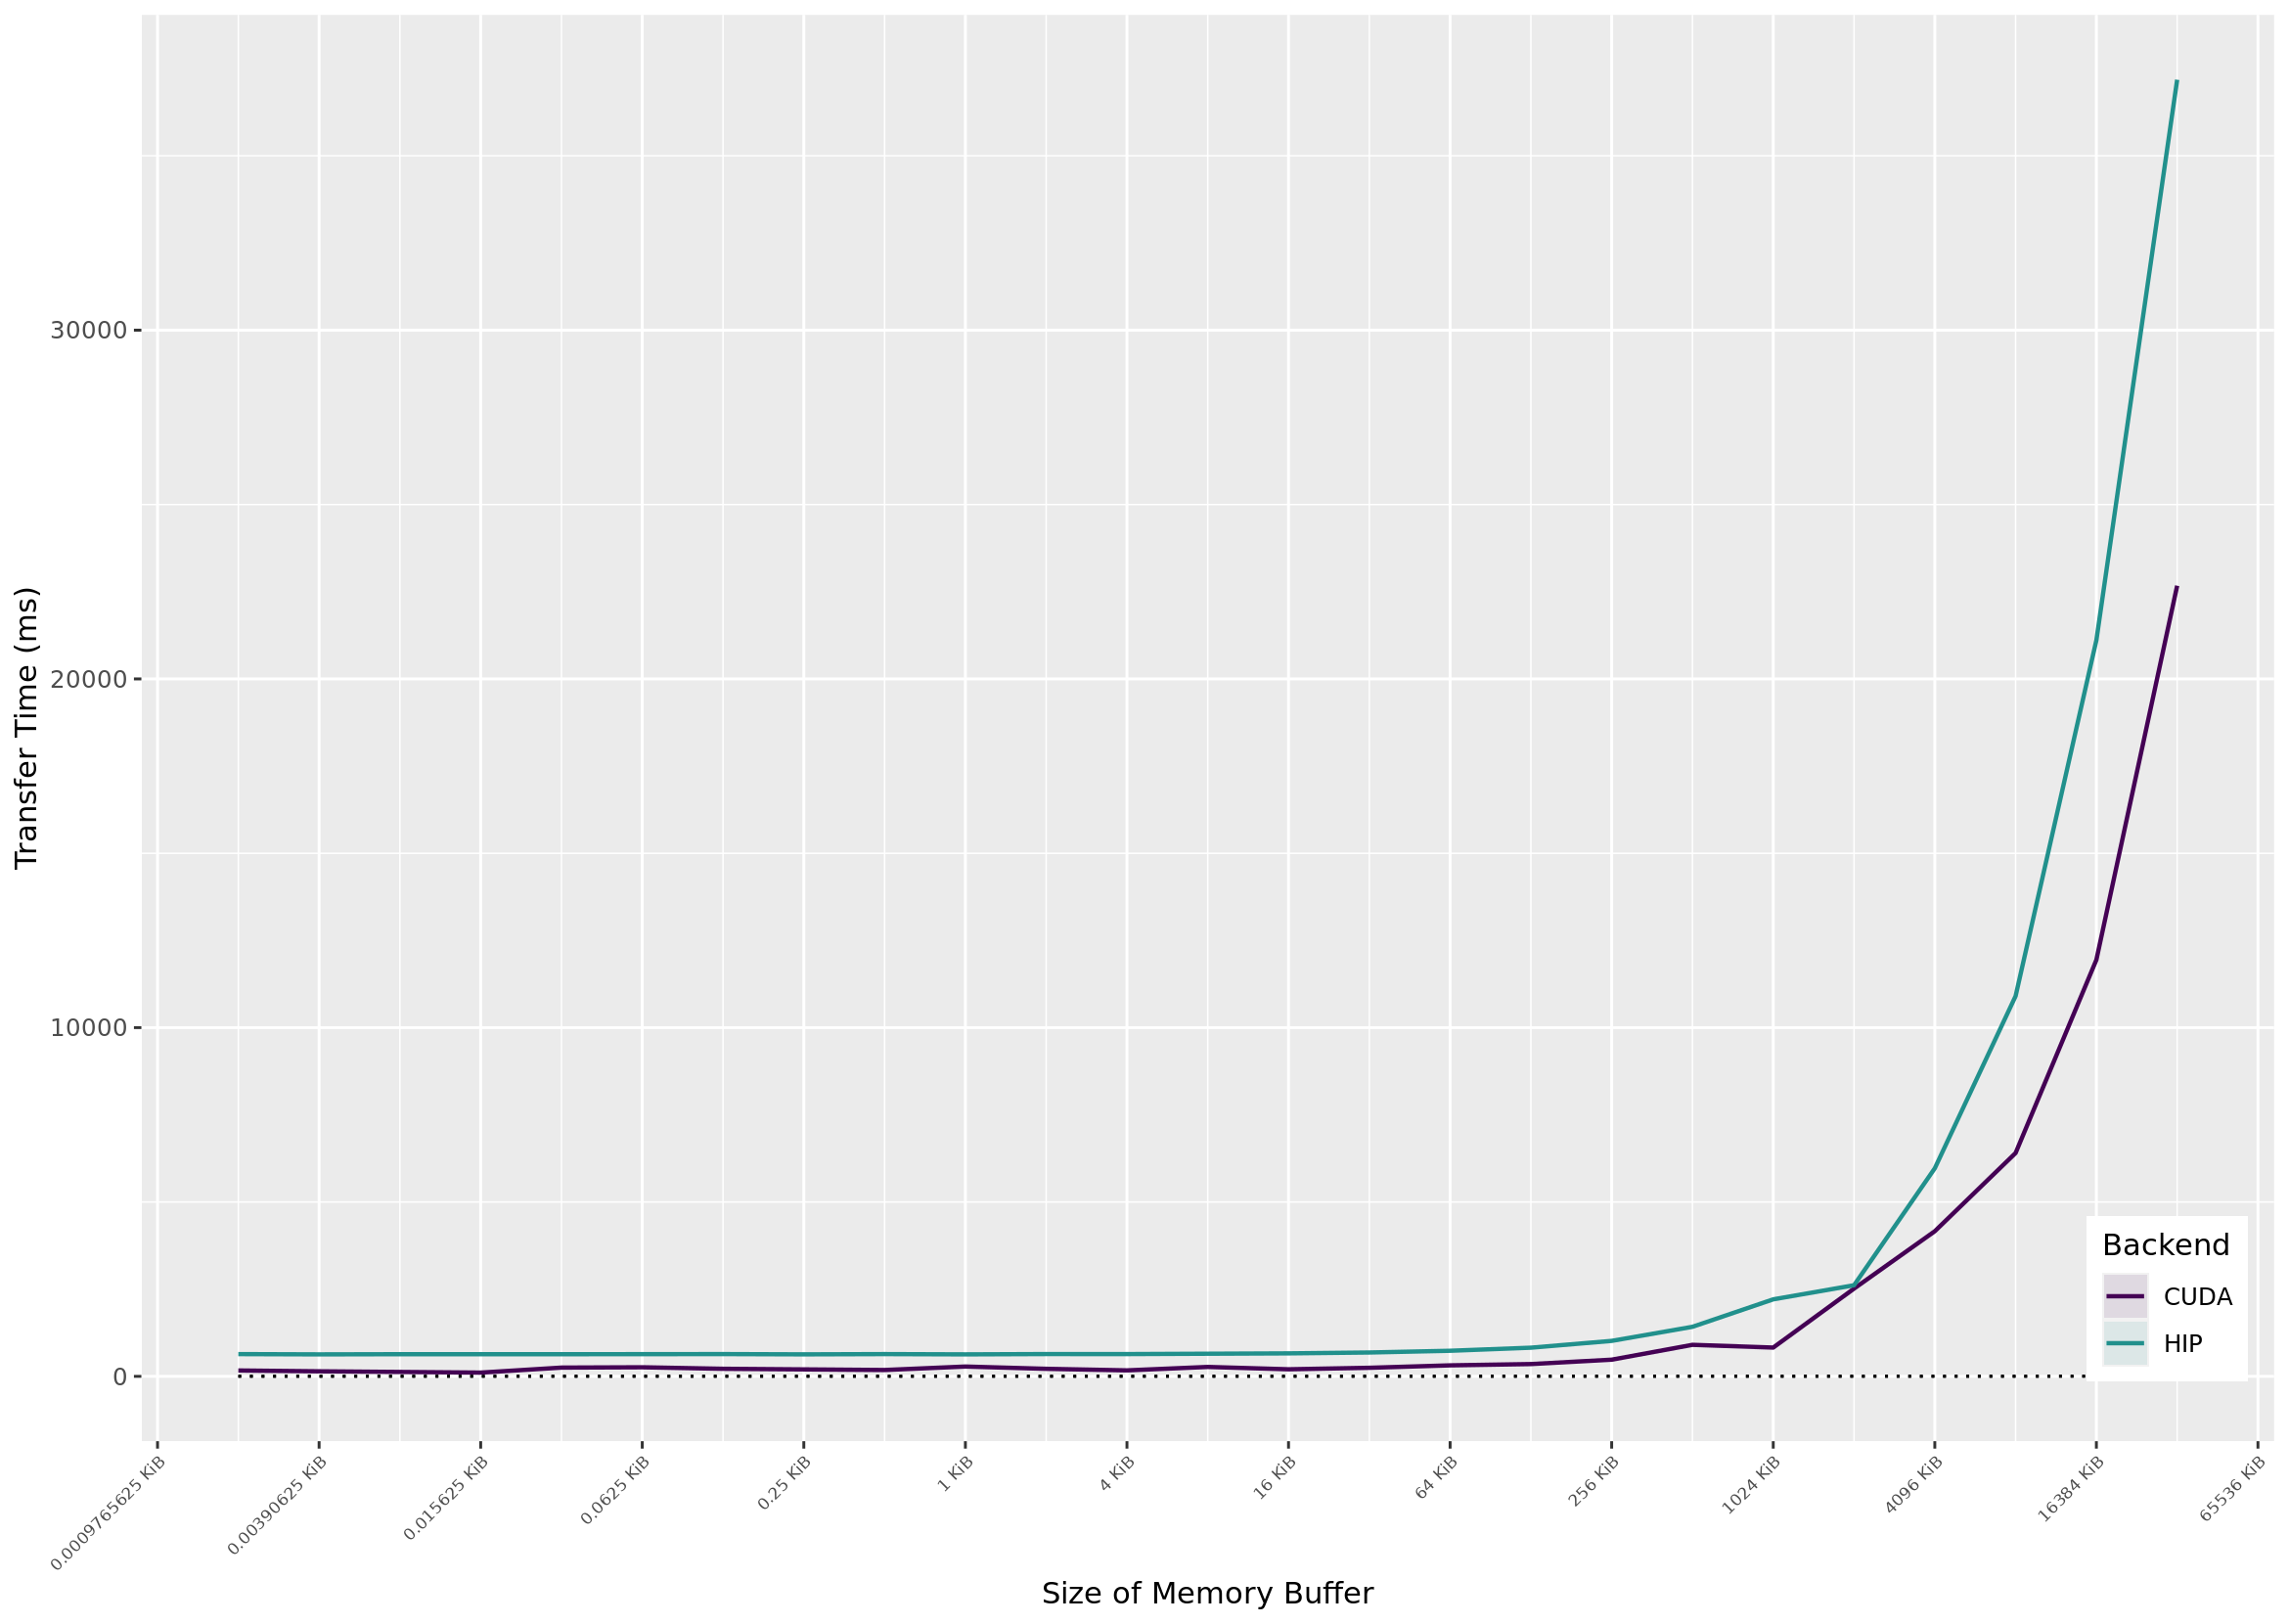

In [11]:
%%R -i full_transfer_size -h 8.3 -w 11.7 --units in -r 200

library('ggplot2')
library('latex2exp')
library("dplyr")
library('viridis')
library('scales')

pred <- function(x){
    #return(6.830503e-01 + 1.884382e-06*x)
    return(3.295 + 1.976e-06*x)
}

full_transfer_size$system <- factor(full_transfer_size$system, levels = c("Oswald", "Equinox", "Leconte", "Radeon", "Explorer"))
full_transfer_size$elements <- as.integer(full_transfer_size$elements)

myColours <- viridis_pal()(3)
myColours <- c(myColours[1], myColours[2], myColours[6]) 
colScale <- scale_colour_manual(name = "Backend",values = myColours)
colFill <- scale_fill_manual(name="Backend",values=myColours)
full_transfer_size$Backends <- toupper(full_transfer_size$version)
names(myColours) <- levels(full_transfer_size$Backends)

full_transfer_size%>%
group_by(system,  Backends, elements, KiB)%>%
summarise(Mean=mean(ms), Max=max(ms), Min=min(ms), Median=median(ms), Std=sd(ms)) %>%
{. ->> res }

res$Predicted <- pred(res$KiB)
outlier_size = 0.5

p0 <- ggplot(res, aes(x=elements, y=Median, fill=Backends,colour=Backends, group=interaction(Backends)))
p0 <- p0 + theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 6)) + expand_limits(y = 0) + expand_limits(y = 0)
p0 <- p0 + scale_x_continuous(trans='log2',  breaks = trans_breaks("log2", function(x) 2^x, n = 12), labels = function(x) paste(x/1024,"KiB") )
p0 <- p0 + facet_wrap( ~ system, strip.position = "top", scales = "free_x")
p0 <- p0 + geom_ribbon(aes(ymin = Median-Std, ymax = Median+Std),alpha=0.1, linetype = 0)
p0 <- p0 + geom_line(aes(y = Median), alpha=1.0, size=0.75)
p0 <- p0 + geom_line(aes(y = Predicted),linetype="dotted",colour="black")
p0 <- p0 + colFill + colScale
p0 <- p0 + guides(fill   = guide_legend(override.aes = list(pattern = "none")))
p0 <- p0 + guides(pattern= guide_legend(override.aes = list(fill = "white")))
p0 <- p0 + labs(colour="Backends", pattern="Implementation", y="Transfer Time (ms)", x="Size of Memory Buffer")
p0 <- p0 + theme(legend.position = c(0.95, 0.10))
print(p0)

ggsave(filename="predicted-vs-measured-transfer-size-systems.pdf",path="./iris-and-dagger-paper/figures",width=8.3,height=11.7,units="in",dpi="retina")
                                                                   
                                                                   
p0 <- ggplot(res, aes(x=elements, y=Median, fill=Backends,colour=Backends, group=interaction(Backends)))
p0 <- p0 + theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 6)) + expand_limits(y = 0) + expand_limits(y = 0)
p0 <- p0 + scale_x_continuous(trans='log2',  breaks = trans_breaks("log2", function(x) 2^x, n = 12), labels = function(x) paste(x/1024,"KiB") )
p0 <- p0 + geom_ribbon(aes(ymin = Median-Std, ymax = Median+Std),alpha=0.1, linetype = 0)
p0 <- p0 + geom_line(aes(y = Median), alpha=1.0, size=0.75)
p0 <- p0 + geom_line(aes(y = Predicted),linetype="dotted",colour="black")
p0 <- p0 + colFill + colScale
p0 <- p0 + guides(fill   = guide_legend(override.aes = list(pattern = "none")))
p0 <- p0 + guides(pattern= guide_legend(override.aes = list(fill = "white")))
p0 <- p0 + labs(colour="Backends", pattern="Implementation", y="Transfer Time (ms)", x="Size of Memory Buffer")
p0 <- p0 + theme(legend.position = c(0.95, 0.10))
print(p0)

ggsave(filename="predicted-vs-measured-transfer-size.pdf",path="./iris-and-dagger-paper/figures",width=8.3,height=11.7,units="in",dpi="retina")